# Detecting AI Generated Images using Deep Learning
## CS5242 Group 32 Project Report

Team Members:
- Aaron Teo Rui Kang (A0155714E)
- Jason Ciu Putra Sung (A0219734Y)
- Kok Yi Ling (A0203933L)
- Putri Darmawan (A0200717R)
- Wilson Kurniawan (A0093874N)

# Introduction

## Project Motivation

<p align="justify">In recent years, advancements in deep learning have led to the development of new and better generative models for various forms of media such as language and images. They have transformed many industries and helped to improve productivity [1]. However, the development of generative models have also led to an influx of deepfakes, which are media generated using artificial intelligence tools. The rise of deepfakes have significant implications as it can be used for the spread of misinformation and fraudulent activities [2]. This project seeks to show that deep learning models can be trained and used to differentiate between real and generated images.</p>

## Dataset

<p align="justify">The model will be initially trained on an image dataset from Kaggle's 2025 Women in AI Kaggle Challenge [3]. It consists of real images obtained from Shutterstock, and generated images from DeepMedia's image generative models.</p>
<p align="justify">Later on, the model will also be trained on images generated in-house, using different generative models.</p>


# Initialization

In [ ]:
# Standard Libraries
import os
import numpy as np
import pandas as pd
import warnings

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

# Machine Learning & Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Kagglehub
import kagglehub

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# PyTorch Vision Libraries
import torchvision.transforms.v2 as transforms

# Progress Bar
from tqdm import tqdm

# Image Libraries
import cv2
from scipy.fftpack import fft2, fftshift
import seaborn as sns
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import sobel
from skimage.io import imread
from skimage.transform import resize

# Google Drive
from google.colab import drive

In [ ]:
# Download data
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")
print(path) # Print to verify; sometimes the dataset is downloaded to a different directory
data_path = '/kaggle/input/ai-vs-human-generated-dataset'

# Possible values: colab, kaggle, gdrive, custom
DATA_SRC = 'colab'

# Mount gdrive regardless of source because the generated images are in there
drive.mount('/content/drive')

# The following is the Google Drive used for the project.
# This consists of the in-house generated images as well as the PyTorch artifacts;
# please request access from us should access to them is needed.
PROJECT_GOOGLE_DRIVE_DIR = '/content/drive/MyDrive/CS5242-2025/final_report'

if DATA_SRC == 'colab' or DATA_SRC == 'kaggle':
    %cd /kaggle/input/ai-vs-human-generated-dataset
    cache_path = '/kaggle/tempcache'
    artifact_path = '/kaggle/artifacts'
    os.makedirs(cache_path, exist_ok=True)
    os.makedirs(artifact_path, exist_ok=True)
elif DATA_SRC == 'gdrive':
    os.chdir(PROJECT_GOOGLE_DRIVE_DIR)
    cache_path = 'tempcache'
    artifact_path = 'artifacts'
    os.makedirs(cache_path, exist_ok=True)
    os.makedirs(artifact_path, exist_ok=True)
else:
    # TODO cd to a specific directory
    cache_path = '' # specify custom directory
    artifact_path = '' # specify custom directory

# Uncomment this to use artifacts generated during training for evaluation
# eval_artifact_path = artifact_path

# Uncomment this to use artifacts from Google Drive for evaluation; this can be changed as appropriate
eval_artifact_path = f"{PROJECT_GOOGLE_DRIVE_DIR}/artifacts"

/kaggle/input/ai-vs-human-generated-dataset
Mounted at /content/drive
/kaggle/input/ai-vs-human-generated-dataset


In [ ]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths and parameters
BATCH_SIZE = 2**7
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
IMAGE_SIZE = 128

warnings.simplefilter("ignore", category=FutureWarning)

Using device: cuda


# Data Exploration

In [ ]:
# Read data
df = pd.read_csv(f"{data_path}/train.csv", index_col=0).rename(columns={"file_name": "id"})

# Basic information on dataset
print(f'Dataset shape: {df.shape}')
print("Dataset columns:", df.columns)
print("Dataset Info\n", df.info())
display(df.head())

# Print class distribution
print("Class Distribution in Dataset:\n", df["label"].value_counts())
print()

gen_data_path = f"{PROJECT_GOOGLE_DRIVE_DIR}/generative_models"

# Basic information on self-generated datasets
df_vae = pd.read_csv(f"{gen_data_path}/vae/iname_vae.csv")
print(f'Dataset (VAE) shape: {df_vae.shape}')
df_ganpt = pd.read_csv(f"{gen_data_path}/gan/iname_gan_pretrained.csv")
print(f'Dataset (GAN-PT) shape: {df_ganpt.shape}')
df_ganft = pd.read_csv(f"{gen_data_path}/gan/iname_gan_finetuned.csv")
print(f'Dataset (GAN-FT) shape: {df_ganft.shape}')
df_dm = pd.read_csv(f"{gen_data_path}/diffusion_model/iname_diffusion_model.csv")
print(f'Dataset (DM) shape: {df_dm.shape}')

Dataset shape: (79950, 2)
Dataset columns: Index(['id', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 79950 entries, 0 to 79949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      79950 non-null  object
 1   label   79950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB
Dataset Info
 None


id  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1

Class Distribution in Dataset:
 label
1    39975
0    39975
Name: count, dtype: int64

Dataset (VAE) shape: (5000, 2)
Dataset (GAN-PT) shape: (5000, 2)
Dataset (GAN-FT) shape: (5000, 2)
Dataset (DM) shape: (438, 2)


From the (Kaggle) data distribution, we can see that the data is balanced, thus there is no need to handle imbalanced dataset.

<h3>Key Differences Between Real and AI-Generated Images<br></h3>

Recent research has revealed several common characteristics that can help distinguish between real and AI-generated images:

- Differences in Frequency Patterns:
AI-generated images often show unusual patterns in their frequency spectrum, especially in the high-frequency areas, because they struggle to reproduce very fine details.
(https://arxiv.org/abs/1911.06465)
- Uncertainty in Model Predictions:
Machine learning models tend to be less confident when analyzing AI-generated images. This is likely because the distribution of synthetic images differs significantly from that of real images.
(https://arxiv.org/html/2412.05897v1)
- Inconsistent Textures:
Generated images may include textures that look unnatural or inconsistent, especially in scenes that require complex surface details. This happens because it’s difficult for AI to model realistic textures accurately.
(https://www.mdpi.com/2073-431X/14/1/1)
- Unnatural Lighting and Shadows:
AI models sometimes produce lighting and shadow effects that don't match the geometry or context of the image, making them look unrealistic.
(https://elearn.eb.com/real-vs-ai-images/)
- Odd or Illogical Backgrounds:
Background elements in AI-generated images may appear out of place or contain patterns that don't logically connect to the main subject, which can be a clear indicator of artificial generation.
(https://elearn.eb.com/real-vs-ai-images/)

In [ ]:
# Convert label: 0 = real, 1 = fake
real_paths = df[df['label'] == 0]['id'].tolist()
fake_paths = df[df['label'] == 1]['id'].tolist()

vae_paths = (gen_data_path + '/' + df_vae['id']).tolist()
ganpt_paths = (gen_data_path + '/' + df_ganpt['id']).tolist()
ganft_paths = (gen_data_path + '/' + df_ganft['id']).tolist()
dm_paths = (gen_data_path + '/' + df_dm['id']).tolist()

# Sample subset for quick visualization
real_sample = real_paths[:10]
fake_sample = fake_paths[:10]
vae_sample = vae_paths[:10]
ganpt_sample = ganpt_paths[:10]
ganft_sample = ganft_paths[:10]
dm_sample = dm_paths[:10]

In [ ]:
def load_img(path, size=(256, 256)):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.resize(img, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Plot real vs AI-generated images
def plot_samples():
    fig, axes = plt.subplots(6, len(real_sample), figsize=(15, 10))
    for i, (r, f, v, gp, gf, d) in enumerate(zip(real_sample, fake_sample, vae_sample, ganpt_sample, ganft_sample, dm_sample)):
        r_img = load_img(r)
        f_img = load_img(f)
        v_img = load_img(v)
        gp_img = load_img(gp)
        gf_img = load_img(gf)
        d_img = load_img(d)
        axes[0, i].imshow(r_img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Real')
        axes[1, i].imshow(f_img)
        axes[1, i].axis('off')
        axes[1, i].set_title('AI-Gen')
        axes[2, i].imshow(v_img)
        axes[2, i].axis('off')
        axes[2, i].set_title('VAE')
        axes[3, i].imshow(gp_img)
        axes[3, i].axis('off')
        axes[3, i].set_title('GAN-PT')
        axes[4, i].imshow(gf_img)
        axes[4, i].axis('off')
        axes[4, i].set_title('GAN-FT')
        axes[5, i].imshow(d_img)
        axes[5, i].axis('off')
        axes[5, i].set_title('DM')
    plt.tight_layout()
    plt.show()

plot_samples()

Output hidden; open in https://colab.research.google.com to view.

#### FFT
FFT converts an image from pixels to how much of the image is made up of patterns of various sizes. It helps us see repetitions, textures, and fine details in terms of frequency components.


Real Images
- Contain natural textures and noise, leading to a wide spread of frequencies.
- Have high-frequency components (sharp edges, small details) that are distributed more naturally.

AI-Generated Images
- Tend to show frequency artifacts, especially from upsampling or imperfect generation techniques.
- May lack high-frequency richness or show repetitive patterns (grid-like textures, checkerboard noise).

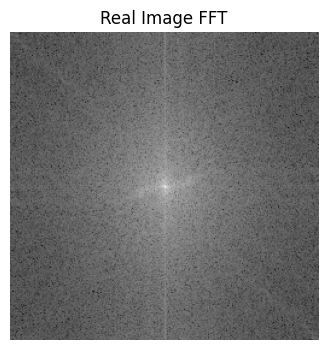

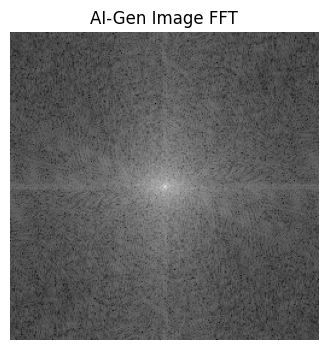

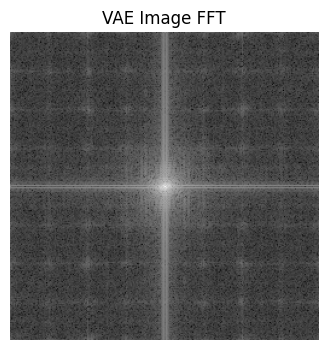

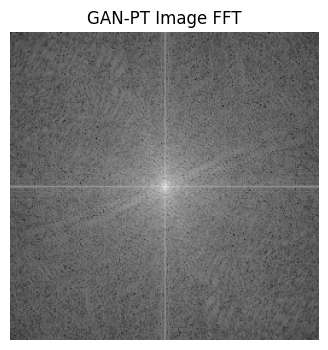

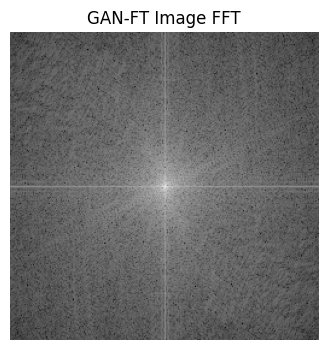

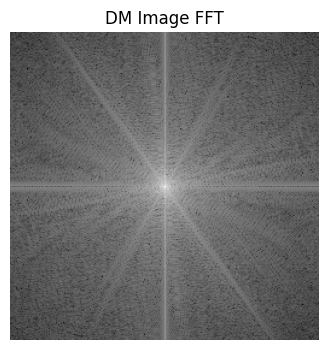

In [ ]:
# FFT (frequency domain) comparison
def plot_fft(img_path, title):
    img = load_img(img_path, size=(256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fft_img = np.log1p(np.abs(fftshift(fft2(gray))))
    plt.imshow(fft_img, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10, 4))
plot_fft(real_sample[0], 'Real Image FFT')
plt.figure(figsize=(10, 4))
plot_fft(fake_sample[0], 'AI-Gen Image FFT')
plt.figure(figsize=(10, 4))
plot_fft(vae_sample[0], 'VAE Image FFT')
plt.figure(figsize=(10, 4))
plot_fft(ganpt_sample[0], 'GAN-PT Image FFT')
plt.figure(figsize=(10, 4))
plot_fft(ganft_sample[0], 'GAN-FT Image FFT')
plt.figure(figsize=(10, 4))
plot_fft(dm_sample[0], 'DM Image FFT')
plt.show()

FFT from real images:

- Has a strong central concentration of brightness (as expected).
- The distribution of noise and high-frequency components looks more random and natural.
- Less visible artifacts or repetitive structures.

FFT from AI-generated images:

- Also has central brightness, but:
  - Shows more symmetry or repetitive patterns (e.g. cross or grid-like texture).
  - Might look over-structured, lacking the natural randomness of real-world textures.

#### Edge detection

We tried to see if the edges is able to differentiate between real and AI-generated images. Techniques like Canny edge detection, Sobel filters, or Edge density analysis can help isolate how well-formed and dense the edges are. We can compare real and AI-generated images based on edge behavior, e.g. number of edges, their length, how "natural" they look.

- Real images: edges are diverse, localized, and aligned with natural shapes.
- AI-generated images: edges can be over-simplified, misaligned, or repetitive

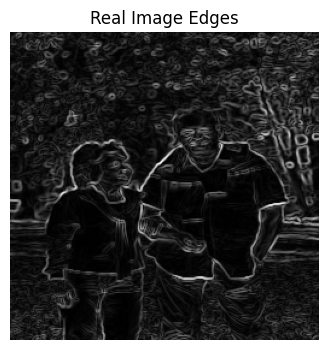

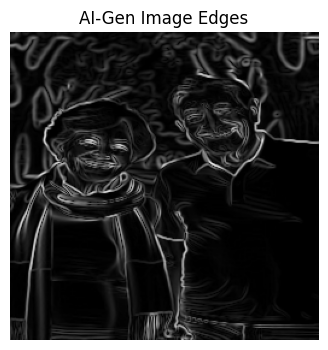

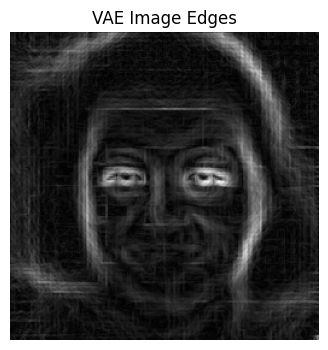

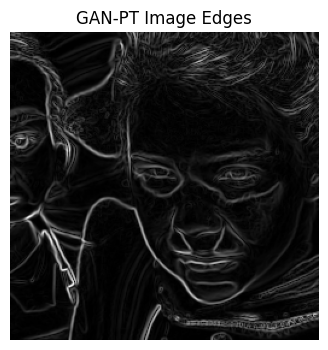

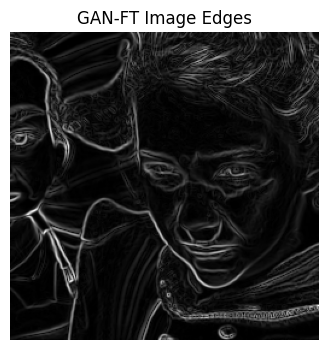

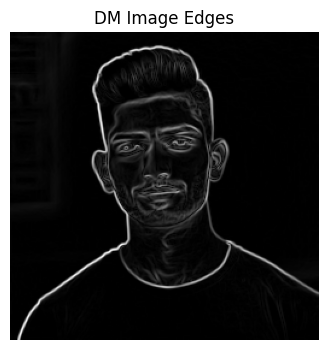

In [ ]:
def plot_edge_map(img_path, title):
    img = load_img(img_path, size=(256, 256))
    gray = rgb2gray(img)
    edges = sobel(gray)
    plt.imshow(edges, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10, 4))
plot_edge_map(real_sample[0], 'Real Image Edges')
plt.figure(figsize=(10, 4))
plot_edge_map(fake_sample[0], 'AI-Gen Image Edges')
plt.figure(figsize=(10, 4))
plot_edge_map(vae_sample[0], 'VAE Image Edges')
plt.figure(figsize=(10, 4))
plot_edge_map(ganpt_sample[0], 'GAN-PT Image Edges')
plt.figure(figsize=(10, 4))
plot_edge_map(ganft_sample[0], 'GAN-FT Image Edges')
plt.figure(figsize=(10, 4))
plot_edge_map(dm_sample[0], 'DM Image Edges')
plt.show()

100%|██████████| 438/438 [01:50<00:00,  3.97it/s]


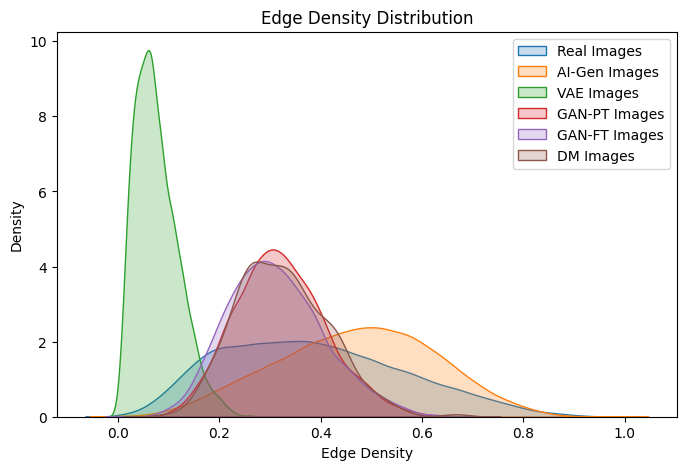

In [ ]:
def compute_edge_density(img_paths, size=(128, 128)):
    densities = []
    for path in tqdm(img_paths):
        img = load_img(path, size=size)
        if img is not None:
            gray = rgb2gray(img)
            edge_map = sobel(gray)
            density = np.mean(edge_map > 0.05)  # Threshold to count strong edges
            densities.append(density)
    return densities

# Plot edge density comparison
def plot_edge_density_comparison():
    real_density = compute_edge_density(real_paths)
    fake_density = compute_edge_density(fake_paths)
    vae_density = compute_edge_density(vae_paths)
    ganpt_density = compute_edge_density(ganpt_paths)
    ganft_density = compute_edge_density(ganft_paths)
    dm_density = compute_edge_density(dm_paths)

    plt.figure(figsize=(8, 5))
    sns.kdeplot(real_density, label='Real Images', fill=True)
    sns.kdeplot(fake_density, label='AI-Gen Images', fill=True)
    sns.kdeplot(vae_density, label='VAE Images', fill=True)
    sns.kdeplot(ganpt_density, label='GAN-PT Images', fill=True)
    sns.kdeplot(ganft_density, label='GAN-FT Images', fill=True)
    sns.kdeplot(dm_density, label='DM Images', fill=True)
    plt.xlabel('Edge Density')
    plt.title('Edge Density Distribution')
    plt.legend()
    plt.show()

plot_edge_density_comparison()

From the graph, we can see that the AI-generated images has narrower distribution compared to real images in term of edge density. This means that most of generated images have a similar level of edge detail, which indicates a lack of variability in the textures and structures. While, real images typically show a wider spread in edge density. This shows the real images have more variations of scenes, objects, and lighting.

#### Brightness

We also want to analyse the brightness of the images. By analysing the brightness, we can:

- Detect synthetic uniformity: AI-generated images often have uniform brightness due to limited variation in lighting simulation, while real-world images usually have more variation
- Understand scene composition: Brightness can tell us how well the image mimics natural light and shadow dynamics. If the image is lacking in term of natural contrast between bright and dark areas, it might means there are some inconsistencies in scene geometry or lighting, which are common flaws in AI-generated images.

100%|██████████| 438/438 [00:03<00:00, 135.41it/s]


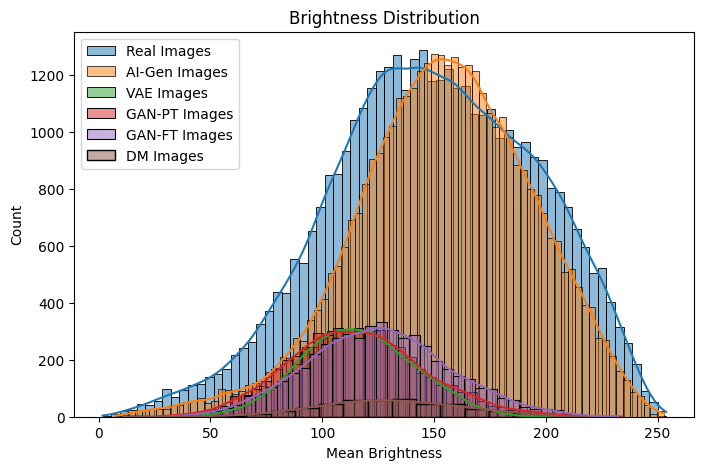

In [ ]:
# Brightness histogram comparison
def plot_histogram(img_paths, label):
    means = []
    for path in tqdm(img_paths):
        img = load_img(path)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            means.append(np.mean(gray))
    sns.histplot(means, kde=True, label=label)

plt.figure(figsize=(8, 5))
plot_histogram(real_paths, 'Real Images')
plot_histogram(fake_paths, 'AI-Gen Images')
plot_histogram(vae_paths, 'VAE Images')
plot_histogram(ganpt_paths, 'GAN-PT Images')
plot_histogram(ganft_paths, 'GAN-FT Images')
plot_histogram(dm_paths, 'DM Images')

plt.xlabel('Mean Brightness')
plt.title('Brightness Distribution')
plt.legend()
plt.show()

As we can see from the graph, real images has a bit more varied brightness (wider distribution). This means that they contain more natural variations in lighting, shading, and texture. On the other hand, AI-generated images looks balanced in brightness, most likely because of the AI models try to generalize lighting and avoid harsh contrasts that could give away inconsistencies

#### LBP
LBP (Local Binary Pattern) is used to describe the texture of images. This binary pattern is then used to summarize the texture at that spot.


AI models, often struggle to perfectly reproduce the variations of textures from real images. This leads to a few effects:

- More uniformity: AI-generated images often have repetitive or overly smooth patterns
- Lack of natural micro-patterns: Real images usually have subtle variations in things like skin texture, grass, fabric, etc. However, AI generated images sometimes smooth over these details or repeat patterns unnaturally

100%|██████████| 438/438 [00:04<00:00, 96.97it/s] 


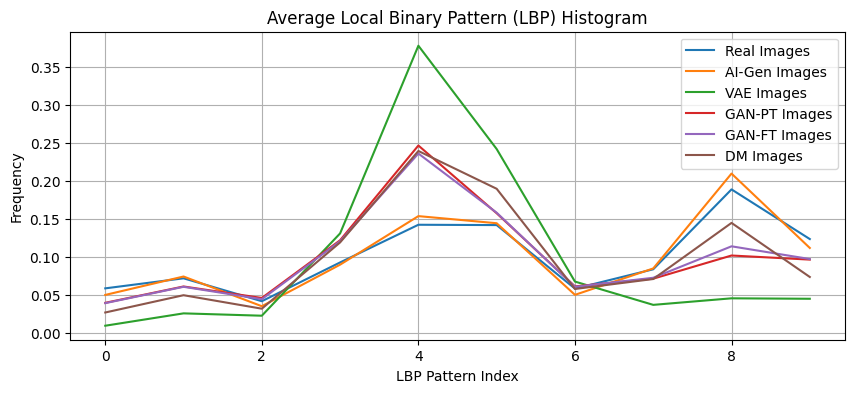

In [ ]:
def compute_lbp_features(img_paths, size=(128, 128), P=8, R=1):
    lbp_histograms = []
    for path in tqdm(img_paths):
        img = load_img(path, size=size)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            lbp = local_binary_pattern(gray, P, R, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2), density=True)
            lbp_histograms.append(hist)
    return np.array(lbp_histograms)

def plot_lbp_histograms(real_paths, fake_paths):
    real_lbp = compute_lbp_features(real_paths)
    fake_lbp = compute_lbp_features(fake_paths)
    vae_lbp = compute_lbp_features(vae_paths)
    ganpt_lbp = compute_lbp_features(ganpt_paths)
    ganft_lbp = compute_lbp_features(ganft_paths)
    dm_lbp = compute_lbp_features(dm_paths)

    real_avg = np.mean(real_lbp, axis=0)
    fake_avg = np.mean(fake_lbp, axis=0)
    vae_avg = np.mean(vae_lbp, axis=0)
    ganpt_avg = np.mean(ganpt_lbp, axis=0)
    ganft_avg = np.mean(ganft_lbp, axis=0)
    dm_avg = np.mean(dm_lbp, axis=0)

    plt.figure(figsize=(10, 4))
    plt.plot(real_avg, label='Real Images')
    plt.plot(fake_avg, label='AI-Gen Images')
    plt.plot(vae_avg, label='VAE Images')
    plt.plot(ganpt_avg, label='GAN-PT Images')
    plt.plot(ganft_avg, label='GAN-FT Images')
    plt.plot(dm_avg, label='DM Images')
    plt.title('Average Local Binary Pattern (LBP) Histogram')
    plt.xlabel('LBP Pattern Index')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_lbp_histograms(real_paths, fake_paths)

From the graph, we can see that the lines between real and AI-generated images are very similar, which means that the AI-generated images are mimicking the real images LBP distribution. This means the AI might be good at replicating basic texture. However, we can see at index 8, the AI-generated images has higher value than real images, and at index 4, the rest of generated image have very high peak. This could mean that AI-generated images tend to repeat certain uniform patterns more often than real images.

#### GLCM

We used GLCM (Gray Level Co-occurrence Matrix) to study the image textures. Some features that we tested:

- Contrast: measures the pixel values across images. Real images usually show more variation.
- Homogeneity: measures how smooth or uniform the images. AI-generated images can sometimes look too consistent or too perfect, so the homogeneity increases.
- Correlation: measures how the pixels relate to one another. Real images usually have more structure and consistent patterns, so the correlation will be high. AI images can have awkward transitions or pattern which makes them have lower correlation. However, too high correlation might indicate that the image is "too similar" or "too clean", which means neighboring pixels or features are more correlated than in chaotic real-world images
- Energy: how repetitive or simple the texture is. AI-generated images usually have high energy, since usually the image has uniform or repetitive pattern, while real images have more complex texture, thus they have lower energy.

In [ ]:
def compute_glcm_features(img_paths, size=(128, 128), distances=[1], angles=[0]):
    features = {'contrast': [], 'homogeneity': [], 'energy': [], 'correlation': []}

    for path in tqdm(img_paths):
        img = load_img(path, size=size)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
            for prop in features.keys():
                val = graycoprops(glcm, prop)[0, 0]
                features[prop].append(val)
    return features

100%|██████████| 438/438 [00:04<00:00, 93.63it/s] 


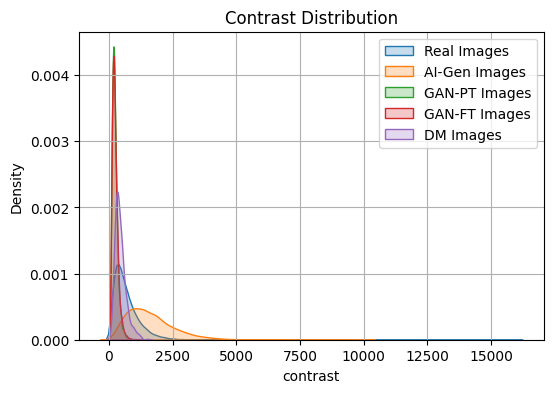

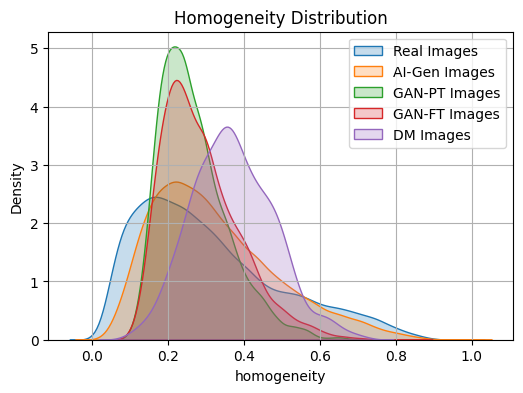

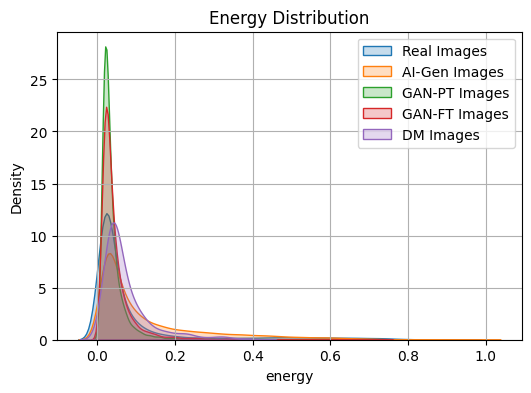

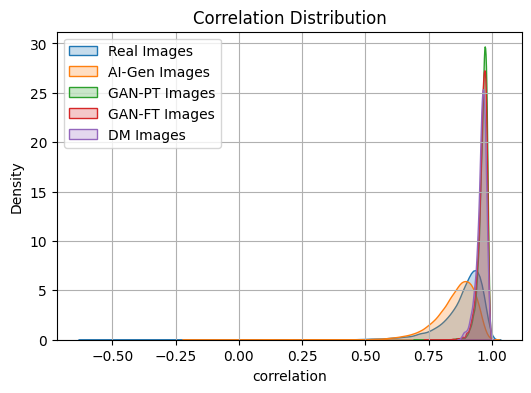

100%|██████████| 5000/5000 [00:53<00:00, 94.18it/s]


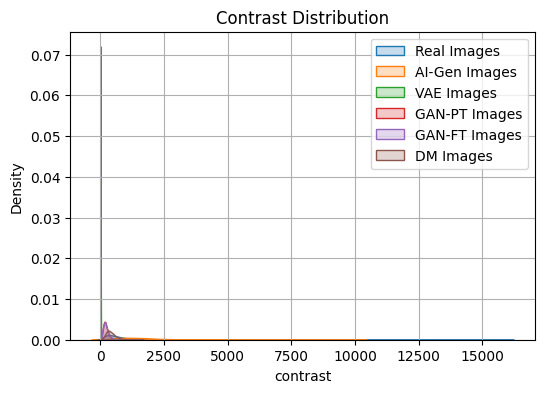

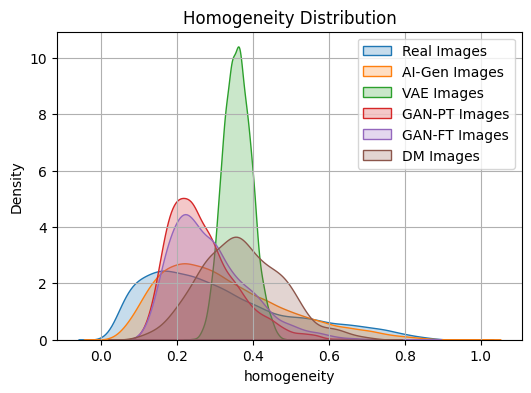

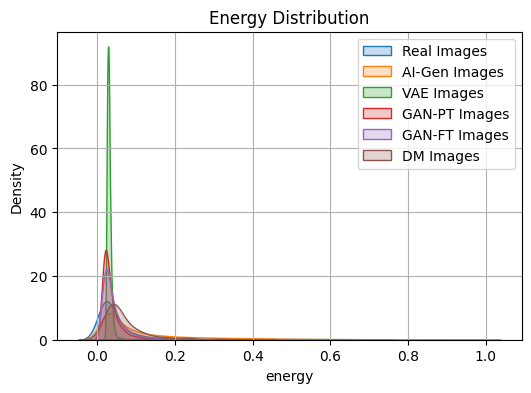

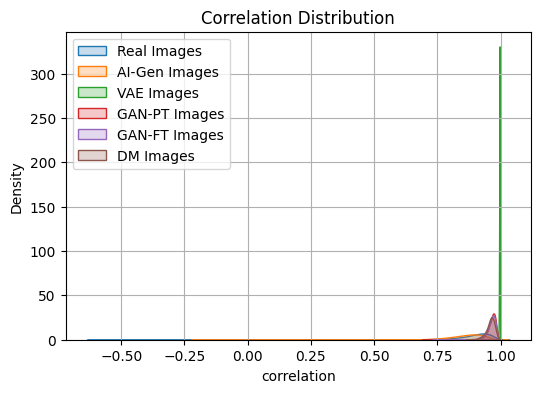

In [ ]:
real_feats = compute_glcm_features(real_paths)
fake_feats = compute_glcm_features(fake_paths)
ganpt_feats = compute_glcm_features(ganpt_paths)
ganft_feats = compute_glcm_features(ganft_paths)
dm_feats = compute_glcm_features(dm_paths)

for prop in real_feats:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(real_feats[prop], label='Real Images', fill=True)
    sns.kdeplot(fake_feats[prop], label='AI-Gen Images', fill=True)
    sns.kdeplot(ganpt_feats[prop], label='GAN-PT Images', fill=True)
    sns.kdeplot(ganft_feats[prop], label='GAN-FT Images', fill=True)
    sns.kdeplot(dm_feats[prop], label='DM Images', fill=True)
    plt.title(f'{prop.capitalize()} Distribution')
    plt.xlabel(prop)
    plt.legend()
    plt.grid(True)
    plt.show()

print()
print()

# Plot with VAE separately because the numbers are very off-the-charts

vae_feats = compute_glcm_features(vae_paths)

for prop in real_feats:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(real_feats[prop], label='Real Images', fill=True)
    sns.kdeplot(fake_feats[prop], label='AI-Gen Images', fill=True)
    sns.kdeplot(vae_feats[prop], label='VAE Images', fill=True)
    sns.kdeplot(ganpt_feats[prop], label='GAN-PT Images', fill=True)
    sns.kdeplot(ganft_feats[prop], label='GAN-FT Images', fill=True)
    sns.kdeplot(dm_feats[prop], label='DM Images', fill=True)
    plt.title(f'{prop.capitalize()} Distribution')
    plt.xlabel(prop)
    plt.legend()
    plt.grid(True)
    plt.show()

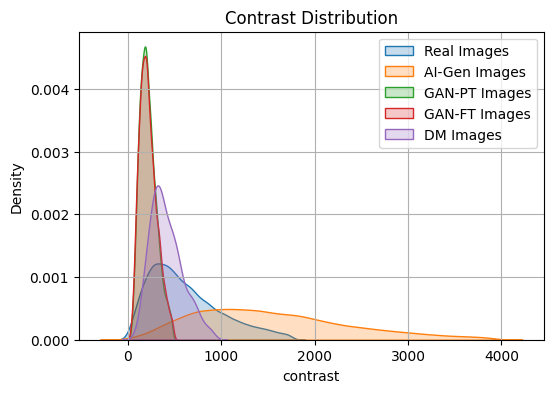

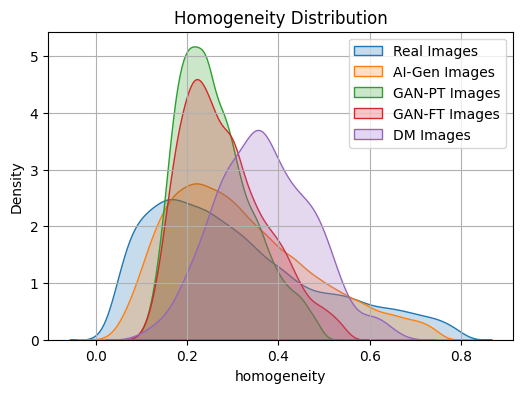

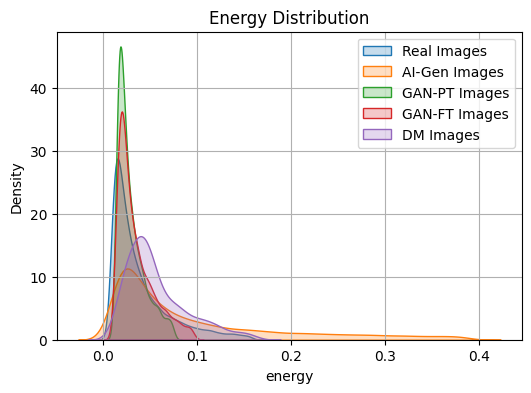

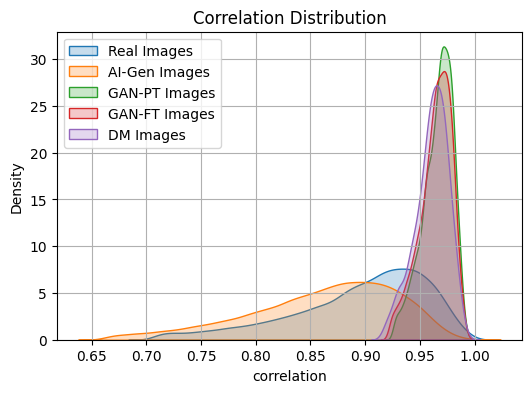

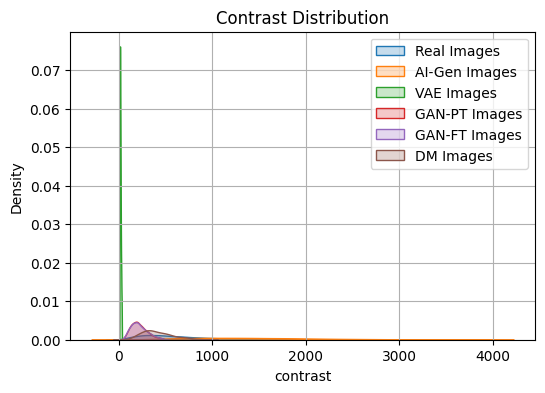

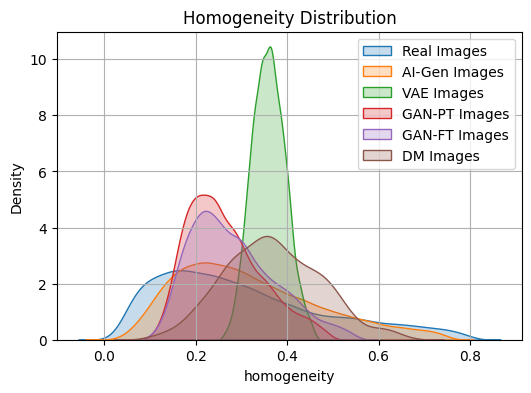

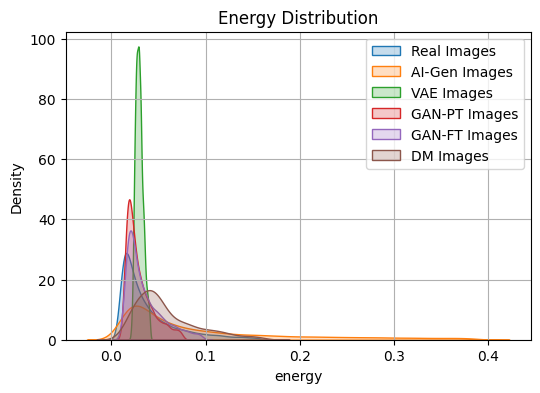

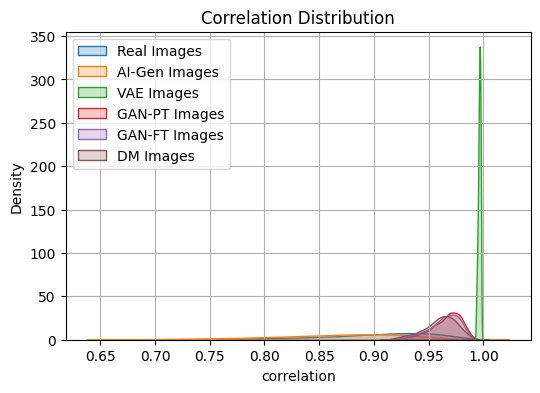

In [ ]:
def remove_outliers(data, k=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return [x for x in data if lower <= x <= upper]

# No need to recalculate if the previous cell has been run,
# but remember to run the compute_glcm_features definition first

# real_feats = compute_glcm_features(real_paths)
# fake_feats = compute_glcm_features(fake_paths)
# ganpt_feats = compute_glcm_features(ganpt_paths)
# ganft_feats = compute_glcm_features(ganft_paths)
# dm_feats = compute_glcm_features(dm_paths)

for prop in real_feats:
    real_clean = remove_outliers(real_feats[prop])
    fake_clean = remove_outliers(fake_feats[prop])
    ganpt_clean = remove_outliers(ganpt_feats[prop])
    ganft_clean = remove_outliers(ganft_feats[prop])
    dm_clean = remove_outliers(dm_feats[prop])

    plt.figure(figsize=(6, 4))
    sns.kdeplot(real_clean, label='Real Images', fill=True)
    sns.kdeplot(fake_clean, label='AI-Gen Images', fill=True)
    sns.kdeplot(ganpt_clean, label='GAN-PT Images', fill=True)
    sns.kdeplot(ganft_clean, label='GAN-FT Images', fill=True)
    sns.kdeplot(dm_clean, label='DM Images', fill=True)
    plt.title(f'{prop.capitalize()} Distribution')
    plt.xlabel(prop)
    plt.legend()
    plt.grid(True)
    plt.show()

print()
print()

# Plot with VAE separately because the numbers are very off-the-charts

# No need to recalculate if the previous cell has been run
# vae_feats = compute_glcm_features(vae_paths)

for prop in real_feats:
    real_clean = remove_outliers(real_feats[prop])
    fake_clean = remove_outliers(fake_feats[prop])
    vae_clean = remove_outliers(vae_feats[prop])
    ganpt_clean = remove_outliers(ganpt_feats[prop])
    ganft_clean = remove_outliers(ganft_feats[prop])
    dm_clean = remove_outliers(dm_feats[prop])

    plt.figure(figsize=(6, 4))
    sns.kdeplot(real_clean, label='Real Images', fill=True)
    sns.kdeplot(fake_clean, label='AI-Gen Images', fill=True)
    sns.kdeplot(vae_clean, label='VAE Images', fill=True)
    sns.kdeplot(ganpt_clean, label='GAN-PT Images', fill=True)
    sns.kdeplot(ganft_clean, label='GAN-FT Images', fill=True)
    sns.kdeplot(dm_clean, label='DM Images', fill=True)
    plt.title(f'{prop.capitalize()} Distribution')
    plt.xlabel(prop)
    plt.legend()
    plt.grid(True)
    plt.show()

The graphs show the percentage of image in the y-axis, and the value of each features in the x-axis.

As we can see from the graphs, more AI-generated images have higher energy, higher homogeneity than real images. While, for the contrast, the AI-generated images generally have lower variation and higher contrast, indicated by narrower distribution.

For correlation, some generated images have higher correlation distribution than real images. It might be because of generated images might rely too much on a few familiar patterns. It creates artifacts that are more correlated across different regions or across samples

In [ ]:
def compute_glcm_metrics(img_paths, size=(128, 128), distances=[1], angles=[0]):
    metrics = []

    for path in tqdm(img_paths):
        try:
            img = imread(path)
            img = resize(img, size, anti_aliasing=True)
            gray = (rgb2gray(img) * 255).astype(np.uint8)
            glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

            contrast = graycoprops(glcm, 'contrast')[0, 0]
            homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

            metrics.append({'path': path, 'contrast': contrast, 'homogeneity': homogeneity})
        except:
            continue

    return metrics

def find_extreme_images(paths, label):
    metrics = compute_glcm_metrics(paths)

    if not metrics:
        print("No valid images found.")
        return

    # Find max contrast and max homogeneity
    max_contrast_img = max(metrics, key=lambda x: x['contrast'])
    max_homogeneity_img = max(metrics, key=lambda x: x['homogeneity'])

    print(f"Highest Contrast Image ({label}):", max_contrast_img['path'], f"(contrast={max_contrast_img['contrast']:.2f})")
    print(f"Highest Homogeneity Image ({label}):", max_homogeneity_img['path'], f"(homogeneity={max_homogeneity_img['homogeneity']:.2f})")

    # Display the images
    for img_info, title in zip([max_contrast_img, max_homogeneity_img],
                               ['Highest Contrast', 'Highest Homogeneity']):
        img = imread(img_info['path'])
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"{title} ({label})\n{img_info['path']}")
        plt.axis('off')
        plt.show()

find_extreme_images(fake_paths, 'AI-Gen')
find_extreme_images(vae_paths, 'VAE')
find_extreme_images(ganpt_paths, 'GAN-PT')
find_extreme_images(ganft_paths, 'GAN-FT')
find_extreme_images(dm_paths, 'DM')

Output hidden; open in https://colab.research.google.com to view.

### Laplacian Variance
Next, we use Laplacian variance as a measure of the smoothness in the images. It computes the variance of the second-derivative (Laplacian) response over a grayscale image and a measure of the sharpness or bluriness of an image where a high variance could indicate many sharp edges and texture changes whereas a low variance might indicate smoother regions.

In [ ]:
# ——— Plot distributions ———
def plot_comp(real, fake, vae, ganpt, ganft, dm, name):
    plt.figure(figsize=(6,4))
    if real is not None:
        sns.kdeplot(real, label='Real Images', fill=True)
    if fake is not None:
        sns.kdeplot(fake, label='AI-Gen Images', fill=True)
    if vae is not None:
        sns.kdeplot(vae, label='VAE Images', fill=True)
    if ganpt is not None:
        sns.kdeplot(ganpt, label='GAN-PT Images', fill=True)
    if ganft is not None:
        sns.kdeplot(ganft, label='GAN-FT Images', fill=True)
    if dm is not None:
        sns.kdeplot(dm, label='DM Images', fill=True)
    plt.title(f'{name} Distribution')
    plt.xlabel(name)
    plt.legend()
    plt.show()

Laplacian var: 100%|██████████| 438/438 [00:03<00:00, 115.29it/s]


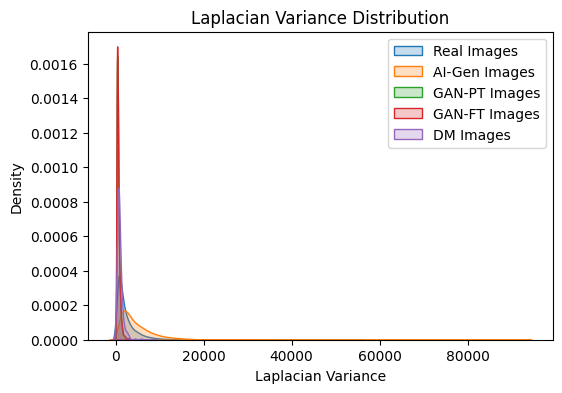

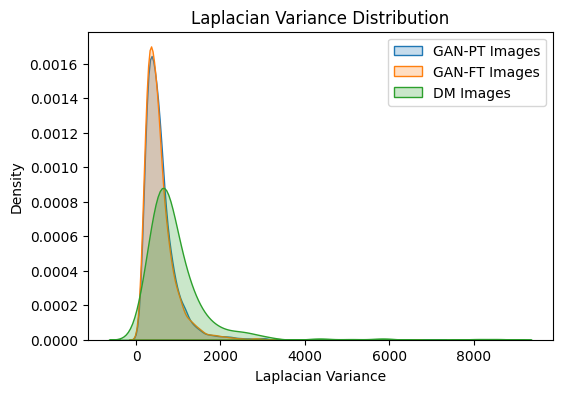

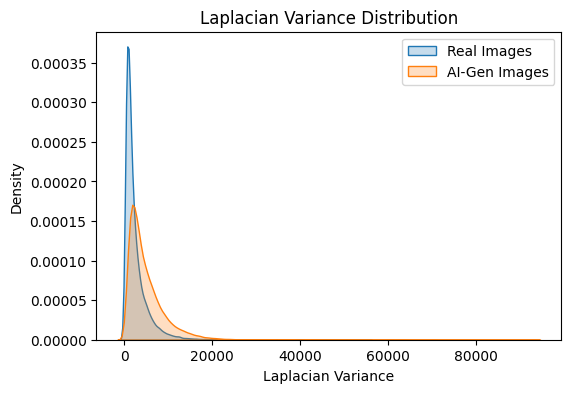

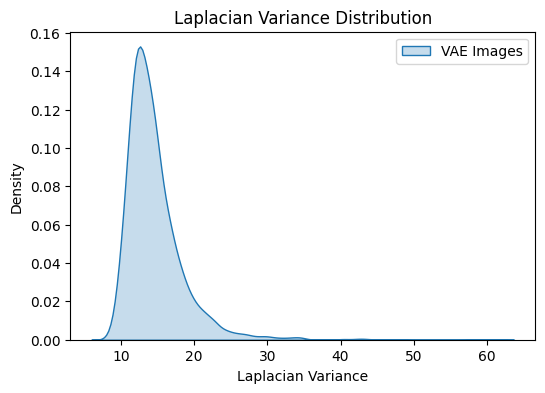

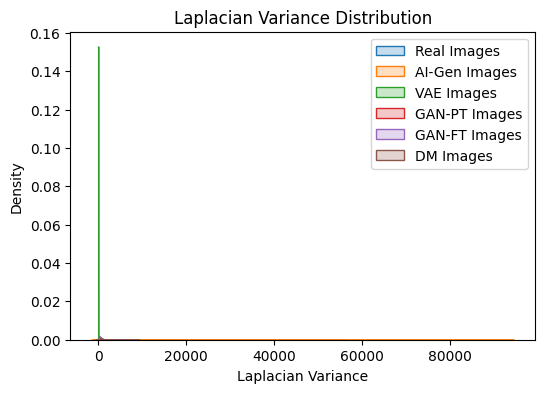

In [ ]:
def laplacian_variance(paths, size=(256,256)):
    vars_ = []
    for p in tqdm(paths, desc='Laplacian var'):
        img = cv2.imread(p)
        if img is None: continue
        gray = cv2.cvtColor(cv2.resize(img, size), cv2.COLOR_BGR2GRAY)
        vars_.append(cv2.Laplacian(gray, cv2.CV_64F).var())
    return vars_

real_var = laplacian_variance(real_paths)
fake_var = laplacian_variance(fake_paths)
vae_var = laplacian_variance(vae_paths)
ganpt_var = laplacian_variance(ganpt_paths)
ganft_var = laplacian_variance(ganft_paths)
dm_var = laplacian_variance(dm_paths)

# Plot in a few different variants because some numbers are off the charts

plot_comp(real_var, fake_var, None, ganpt_var, ganft_var, dm_var, 'Laplacian Variance')
plot_comp(None, None, None, ganpt_var, ganft_var, dm_var, 'Laplacian Variance')
plot_comp(real_var, fake_var, None, None, None, None, 'Laplacian Variance')
plot_comp(None, None, vae_var, None, None, None, 'Laplacian Variance')
plot_comp(real_var, fake_var, vae_var, ganpt_var, ganft_var, dm_var, 'Laplacian Variance')

From our observations real images show a more concentrated peak at lower Laplacian variance values, with a sharper, taller distribution.
AI-generated images have a slightly more spread-out distribution that extends further to the right, indicating more variance in texture quality.

This suggests that real images have more consistent texture patterns, while AI-generated images display more variability in their texture quality. Some AI images might be overly smooth (very low variance) while others might have artificially enhanced textures (higher variance). The real image distribution's sharper peak suggests more natural and consistent texture patterns across the dataset.

### Keypoint Richness

ORB (Oriented FAST and Rotated BRIEF) detects and describes local feature points—corners and blobs. Counting how many keypoints an image yields gives a sense of feature complexity.

ORB keypoints: 100%|██████████| 438/438 [00:04<00:00, 101.46it/s]


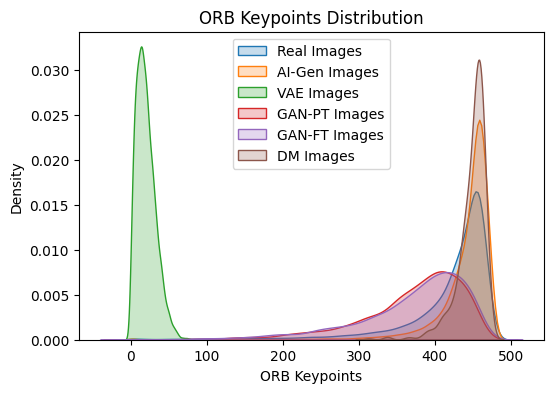

In [ ]:
def orb_keypoints_count(paths, size=(256,256)):
    orb = cv2.ORB_create()
    counts = []
    for p in tqdm(paths, desc='ORB keypoints'):
        img = cv2.imread(p)
        if img is None: continue
        gray = cv2.cvtColor(cv2.resize(img, size), cv2.COLOR_BGR2GRAY)
        kp = orb.detect(gray, None)
        counts.append(len(kp))
    return counts

real_kp = orb_keypoints_count(real_paths)
fake_kp = orb_keypoints_count(fake_paths)
vae_kp = orb_keypoints_count(vae_paths)
ganpt_kp = orb_keypoints_count(ganpt_paths)
ganft_kp = orb_keypoints_count(ganft_paths)
dm_kp = orb_keypoints_count(dm_paths)

plot_comp(real_kp, fake_kp, vae_kp, ganpt_kp, ganft_kp, dm_kp, 'ORB Keypoints')

From our observations, both distributions peak near the upper range of 300-500 keypoints, but AI-generated images are shifted slightly higher on average and are more tightly concentrated.
Real images show greater spread, dipping down into lower keypoint counts when scenes lack strong corners or textured patches.
One possible explanation could be that since GAN artifacts or synthesized textures introduce repetitive patterns, ORB might pick up features that might not be semantically meaningful.

For VAE, it has a very low ORB. It might be because of VAE generate a lot of blur images. It has fewer high-frequency features

# Data Pre-processing

Data augmentation is often performed in image processing to increase the data size, performance, and model generalization:
- Resizing of the image to 128x128 was done so that all images have the same size.
- Random image rotation and colour jitters were used to augment new images to increase the robustness of the model and can make the model more translational- and rotational-invariant.

However, processing images is computationally expensive, and image augmentation further increases computation demand. With limited hardware in our machines, we relied on lazy augmentation and retrieval of the images by only processing the images when they are required by the data loader. In addition, as the model will be trained on multiple epochs of the same data, the tensors were temporarily saved on disk so that they do not need to be processed again, thereby saving computational time.
</p>

In [ ]:
# General Dataset
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, augmented, data_dir=data_path, cache_dir=cache_path, lazy=True):
        self.dataframe = dataframe
        self.augmented = augmented
        self.data_dir = data_dir
        self.cache_dir = cache_dir
        # self.cache = {}
        self.lazy = lazy

        if self.cache_dir and not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)

        # If lazy is False, preprocess all images
        if self.lazy is False:
            self.img = []
            self.label = []
            for idx, row in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
                self.label.append(row["label"])
                self.img.append(self._load_and_augment_image(row["id"], self.augmented))

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.lazy is False:
            return self.img[idx], self.label[idx]

        label = self.dataframe.iloc[idx]["label"]
        # Only save in cache if it is augmented
        if self.augmented:
            # Create cache key
            cache_key = os.path.basename(f"{self.dataframe.iloc[idx]['id']}_augm")
            # if cache_key in self.cache:
            #     return self.cache[cache_key], label

            # Check disk cache
            if self.cache_dir:
                cache_path = os.path.join(self.cache_dir, f"{cache_key}.pt")
                if os.path.exists(cache_path):
                    try:
                        augm = torch.load(cache_path)
                        return augm, label
                    except Exception:
                        pass

            # Append both original and augmented images
            augm = self._load_and_augment_image(self.dataframe.iloc[idx]["id"], self.augmented)
            # Store on disk if enabled
            if self.cache_dir:
                cache_path = os.path.join(self.cache_dir, f"{cache_key}.pt")
                torch.save(augm, cache_path)
            return augm, label
        else:
            cache_key = os.path.basename(f"{self.dataframe.iloc[idx]['id']}_orig")
            if self.cache_dir:
                cache_path = os.path.join(self.cache_dir, f"{cache_key}.pt")
                if os.path.exists(cache_path):
                    try:
                        orig = torch.load(cache_path)
                        return orig, label
                    except Exception:
                        pass
            orig = self._load_and_augment_image(self.dataframe.iloc[idx]["id"], self.augmented)  # Only original
            if self.cache_dir:
                cache_path = os.path.join(self.cache_dir, f"{cache_key}.pt")
                torch.save(orig, cache_path)
            return orig, label

    # Function to apply augmentation & preprocessing
    def _load_and_augment_image(self, img_path, augmented):
        # Need to hard-code because the generated images come from Drive
        if img_path.startswith('gan') or img_path.startswith('diffusion') or img_path.startswith('vae'):
            path = f"{gen_data_path}/{img_path}"
        else:
            path = f"{self.data_dir}/{img_path}"
        img = Image.open(path).convert("RGB")

        # Define augmentation transforms
        augmentation_transforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(p=0.5),  # Flip 50% of images
                transforms.RandomRotation(15),  # Rotate within ±15 degrees
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color adjustments
            ]
        )

        # Define preprocessing (normalization + resizing)
        preprocess_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToImage().to(device), transforms.ToDtype(torch.float32, scale=True)])  # Converts to tensor and scales from [0, 255] to [0, 1]

        # Create both original & augmented images
        if augmented:
            # original_img = preprocess_transform(img)  # Resized and normalized original image
            augmented_img = preprocess_transform(augmentation_transforms(img))  # Augmented version
            return augmented_img
        else:
            return preprocess_transform(img)


In [ ]:
# Load data
df = pd.read_csv(f"{data_path}/train.csv", index_col=0).rename(columns={"file_name": "id"})
# df_test = pd.read_csv(f"{data_path}/test.csv", index_col=0).rename(columns={"file_name": "id"})

# Split into train, validation, and test - 80-10-10
df_train, df_valtest = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
df_test, df_val = train_test_split(df_valtest, test_size=0.5, random_state=42, stratify=df_valtest["label"])

gen_data_path = f"{PROJECT_GOOGLE_DRIVE_DIR}/generative_models"

df_vae = pd.read_csv(f"{gen_data_path}/vae/iname_vae.csv")
df_train_vae, df_valtest_vae = train_test_split(df_vae, test_size=0.2, random_state=42)
df_val_vae, df_test_vae = train_test_split(df_valtest_vae, test_size=0.5, random_state=42)

df_ganpt = pd.read_csv(f"{gen_data_path}/gan/iname_gan_pretrained.csv")
df_train_ganpt, df_valtest_ganpt = train_test_split(df_ganpt, test_size=0.2, random_state=42)
df_val_ganpt, df_test_ganpt = train_test_split(df_valtest_ganpt, test_size=0.5, random_state=42)

df_ganft = pd.read_csv(f"{gen_data_path}/gan/iname_gan_finetuned.csv")
df_train_ganft, df_valtest_ganft = train_test_split(df_ganft, test_size=0.2, random_state=42)
df_val_ganft, df_test_ganft = train_test_split(df_valtest_ganft, test_size=0.5, random_state=42)

df_dm = pd.read_csv(f"{gen_data_path}/diffusion_model/iname_diffusion_model.csv")
df_train_dm, df_valtest_dm = train_test_split(df_dm, test_size=0.2, random_state=42)
df_val_dm, df_test_dm = train_test_split(df_valtest_dm, test_size=0.5, random_state=42)

# Sample for quick check/testing; to train the model fully, set this to False
SHOULD_SAMPLE = True

if SHOULD_SAMPLE:
    sample_size = 0.99 # change as needed
    df_train_subs, _ = train_test_split(df_train, test_size=sample_size, random_state=42, stratify=df_train['label'])
    df_val_subs, _ = train_test_split(df_val, test_size=sample_size, random_state=42, stratify=df_val['label'])
    df_test_subs, _ = train_test_split(df_test, test_size=sample_size, random_state=42, stratify=df_test['label'])
else:
    df_train_subs = df_train
    df_val_subs = df_val
    df_test_subs = df_test

# Create train and test datasets
train_orig_dataset = CustomImageDataset(df_train_subs, augmented=False)  # Original training dataset
train_augm_dataset = CustomImageDataset(df_train_subs, augmented=True)  # Original training dataset
val_dataset = CustomImageDataset(df_val_subs, augmented=False)  # No augmentation for validation
test_dataset = CustomImageDataset(df_test_subs, augmented=False)  # No augmentation for test

# Create DataLoaders
train_orig_loader = DataLoader(train_orig_dataset, batch_size=BATCH_SIZE // 2, shuffle=True, num_workers=0)
train_augm_loader = DataLoader(train_augm_dataset, batch_size=BATCH_SIZE // 2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Print the number of train, validation and test set with their labels
print("Train set:", df_train_subs.shape)
print(df_train_subs["label"].value_counts())
print("Validation set:", df_val_subs.shape)
print(df_val_subs["label"].value_counts())
print("Test set:", df_test_subs.shape)
print(df_test_subs["label"].value_counts())

Train set: (639, 2)
label
1    320
0    319
Name: count, dtype: int64
Validation set: (79, 2)
label
0    40
1    39
Name: count, dtype: int64
Test set: (79, 2)
label
1    40
0    39
Name: count, dtype: int64


In [ ]:
# Create separate objects for self-generated test datasets

test_dataset_vae = CustomImageDataset(df_test_vae, augmented=False, data_dir=gen_data_path, lazy=False)  # No augmentation for test
test_dataset_ganpt = CustomImageDataset(df_test_ganpt, augmented=False, data_dir=gen_data_path, lazy=False)  # No augmentation for test
test_dataset_ganft = CustomImageDataset(df_test_ganft, augmented=False, data_dir=gen_data_path, lazy=False)  # No augmentation for test
test_dataset_dm = CustomImageDataset(df_test_dm, augmented=False, data_dir=gen_data_path, lazy=False)  # No augmentation for test

test_loader_vae = DataLoader(test_dataset_vae, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_ganpt = DataLoader(test_dataset_ganpt, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_ganft = DataLoader(test_dataset_ganft, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_dm = DataLoader(test_dataset_dm, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

100%|██████████| 44/44 [00:15<00:00,  2.78it/s]


# Classifier Models

## Convolutional Neural Networks (Baseline)
<p align='justify'>
CNNs has been the main algorithm of choice for image related tasks since its popularisation in the late 1980s [4]. As a baseline for model comparison, we implemented a simple two-layer vanilla CNN with 16 and 32 channels. We also implemented batch normalization after every ReLu activation function to ensure stability during model training. Two fully connected layers were also added after the convolutional layers, with the final linear layer having an output of two for the binary prediction of whether the image is real or fake. Dropout regularization was also used in this model.
</p>

In [ ]:
# Define a simple CNN model
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        # Single convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adding a few more layers for better performance
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Add batch norm 2d for better stability
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)

        # Calculate the size after convolutions and pooling
        # After 2 pooling layers with stride 2, the size is reduced to IMAGE_SIZE/4
        flat_size = 32 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4)

        # Fully connected layers
        self.fc1 = nn.Linear(flat_size, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: real or AI-generated

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.pool(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## ResNet
ResNet proposed the residual connection in 2015 for an image classification task [5]. A residual connection is a shortcut within a neural network architecture that allows inputs to skip intermediate layers and flow directly to the output of another layer. The gradients can be maintained even as more layers are added to the model. This allows for the training of deeper neural networks, which were suffering from the vanishing gradient problem.

There are several common implementations of ResNet, which consists of repeated residuals blocks of convolutional layers, batch normalisation, ReLu activation function, and max pooling. Residual connections were added to connect the inputs and outputs of these blocks. An average pooling layer and fully connected layer are added after the repeated blocks. In this project, we will be implementing the simplest ResNet architecture known as the ResNet 18 [5], which has five repeated blocks. Other implementations of ResNet usually increase the number of repetitions. Similar to the baseline vanilla CNN, the final linear layer has an output of two for the binary prediction.

## CBAM ResNet
Attention mechanism is one of the most important architectures in machine learning in recent years [6]. The main idea behind attention is to allow the model to focus more on the important and relevant parts of the data. While originally developed for text related tasks, its uses has spread to other fields of machine learning, such as image classification. One such example is the Convolutional Block Attention Module ResNet (CBAM ResNet) [7].

CBAM ResNet proposes to combine attention mechanism with CNNs, specifically ResNet [7]. It uses two new attention types - channel and spatial attention. These special attention layers are added sequentially within the residual blocks after the convolutional layers. Both channel and spatial attention uses average and max pooling to create feature maps along either the spatial or channel dimension. Fully connected linear layers, and the ReLu and sigmoid activation functions were also included in the attention layers.

In [ ]:
# ResNet and CBAM-ResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, cbam=False):
        super(ResidualBlock, self).__init__()
        self.cbam = cbam
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out_channels))
        if cbam:
            self.cbam1 = CBAMBlock(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels))

        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.conv2(out)
        if self.cbam:
            out = self.cbam1(out)
        out += residual
        out = self.relu(out)
        return out

# ResNet 18
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()

        # First block
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False), nn.BatchNorm2d(64), nn.ReLU())

        # Max pooling
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Second block
        self.conv2 = nn.Sequential(ResidualBlock(64, 64), ResidualBlock(64, 64))

        # Third block
        self.conv3 = nn.Sequential(ResidualBlock(64, 128), ResidualBlock(128, 128))

        # Fourth block
        self.conv4 = nn.Sequential(ResidualBlock(128, 256), ResidualBlock(256, 256))

        # Fifth block
        self.conv5 = nn.Sequential(ResidualBlock(256, 512), ResidualBlock(512, 512))

        # Average pool
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Linear layer for prediction
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


# CBAM-ResNet
class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super(ChannelAttention, self).__init__()
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.mlp = nn.Sequential(nn.Linear(channel, channel // reduction), nn.ReLU(), nn.Linear(channel // reduction, channel))
        self.sigmoid = nn.Sigmoid()

        # Store the attention map for visualization
        self.attention_map = None

    def forward(self, x):
        max_result = self.maxpool(x)
        avg_result = self.avgpool(x)
        max_out = self.mlp(max_result.view(max_result.size(0), -1))
        avg_out = self.mlp(avg_result.view(avg_result.size(0), -1))
        output = self.sigmoid(max_out + avg_out)

        # Store the attention map for visualization
        self.attention_map = output.detach().clone()

        return output.unsqueeze(2).unsqueeze(3)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

        # Store the attention map for visualization
        self.attention_map = None

    def forward(self, x):
        max_result, _ = torch.max(x, dim=1, keepdim=True)
        avg_result = torch.mean(x, dim=1, keepdim=True)
        result = torch.cat([max_result, avg_result], 1)
        output = self.conv(result)
        output = self.sigmoid(output)

        # Store the attention map for visualization
        self.attention_map = output.detach().clone()

        return output


class CBAMBlock(nn.Module):
    def __init__(self, channel=512, reduction=16, kernel_size=49):
        super().__init__()
        self.ca = ChannelAttention(channel=channel, reduction=reduction)
        self.sa = SpatialAttention(kernel_size=kernel_size)

        # Store the attention-modulated feature map for visualization
        self.feature_map = None

    def forward(self, x):
        residual = x
        out = x * self.ca(x)
        out = out * self.sa(out)

        # Store the final output before residual addition for visualization
        self.feature_map = out.detach().clone()

        return out + residual


class CBAMResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(CBAMResNet18, self).__init__()

        # First block
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False), nn.BatchNorm2d(64), nn.ReLU())

        # Max pooling
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Second block
        self.conv2 = nn.Sequential(ResidualBlock(64, 64, cbam=True), ResidualBlock(64, 64, cbam=True))

        # Third block
        self.conv3 = nn.Sequential(ResidualBlock(64, 128, cbam=True), ResidualBlock(128, 128, cbam=True))

        # Fourth block
        self.conv4 = nn.Sequential(ResidualBlock(128, 256, cbam=True), ResidualBlock(256, 256, cbam=True))

        # Fifth block
        self.conv5 = nn.Sequential(ResidualBlock(256, 512, cbam=True), ResidualBlock(512, 512, cbam=True))

        # Average pool
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Linear layer for prediction
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def get_last_cbam_block(self):
        """Get the CBAM block from the last residual block"""
        return self.conv5[1].cbam1

# Generative Models

The actual training and generation code for each of the models can be seen in the `./generative_models` folder. Please request access from us should access to them is needed.

## Variational Autoencoder (VAE)
Variational Autoencoders (VAEs) are a type of generative model that learns to encode input data into a structured latent space and then decode from that space to reconstruct the original data [8]. Unlike traditional autoencoders, VAEs introduce a probabilistic element: they encode inputs as parameters of a probability distribution (usually a Gaussian) rather than fixed points. During training, the model optimizes both the reconstruction accuracy and a regularization term that encourages the learned latent distributions to match a prior distribution, typically a standard normal. This structure allows VAEs to generate new, coherent data samples by sampling from the latent space, making them widely used for applications like image generation, semi-supervised learning, and anomaly detection.

The VAE model was trained from scratch on the Flickr-Faces-HQ (FFHQ) dataset [9], generating 256×256 RGB face images with a 128-dimensional latent space. The VAE follows a standard convolutional encoder-decoder architecture inspired by the original work of Kingma & Welling (2014) [8].



## Generative Adversarial Network (GAN)
Generative Adversarial Networks (GANs) are a class of machine learning frameworks where two neural networks, the generator and the discriminator, are trained simultaneously in a game-theoretic setup [14]. The generator tries to produce data that is indistinguishable from real data, while the discriminator attempts to correctly identify whether a given sample is real or generated. During training, the generator improves by learning to fool the discriminator, and the discriminator improves by getting better at spotting fake data, creating a dynamic competition. Ideally, this adversarial process pushes the generator to produce increasingly realistic outputs, eventually converging to a point where generated data is nearly indistinguishable from real data, effectively minimizing the difference between the two distributions.

For our project, we employed transfer learning using the pretrained StyleGAN3 model implemented by NVIDIA [9], [10]. StyleGAN3 was originally trained on the FFHQ dataset [9], and we resumed training by fine-tuning it on the authentic portion of our own dataset, specifically face images which are detected by an object detection module. This fine-tuning allowed the model to learn more diverse and representative features of human faces beyond those present in the FFHQ dataset. The use of StyleGAN3 [9], which incorporates improved training stability and architecture over previous GAN models, enables high-quality image generation. The model generates high-resolution images with improved consistency and sharpness compared to earlier GAN variants.



## Diffusion Model
Diffusion models are a class of generative models that create data by simulating a gradual noising and denoising process [15]. They work by first adding small amounts of random noise to data over many steps until it becomes pure noise, and then learning to reverse this process to generate new, realistic data from noise. During training, the model learns the conditional probability of removing noise at each step. Sampling from a diffusion model involves starting with random noise and iteratively denoising it to form coherent data, such as an image or audio signal. Diffusion models have recently gained popularity for producing high-quality, diverse outputs and are seen as strong competitors to GANs in tasks like image generation and editing.

For the Diffusion model, we directly utilized the Stable Diffusion 3.5 Large model [11], accessible via the Hugging Face API. This decision was made due to the high cost and time required to train a Diffusion model from scratch. To maintain consistency with the other two generation models, we focused on face generation by providing only face-related prompts, which were generated by ChatGPT. However, due to API costs, only a limited number of images could be generated.

# Training on Original Dataset

The models were trained on 80% of the original dataset, with additional data through image augmentation, for 10 epochs. 10% was used for the validation set and another 10% for the test set. Within each epoch, a batch size of 128 was used, with a learning rate of 0.001. Cross entropy loss was used as this is a classification problem with a binary output. We also tracked the accuracy and F1 score. AdamW was chosen as the optimiser. We also tracked the accuracy and F1 score for each epoch. The epoch with the best validation F1 score was chosen for each model. Finally, vanilla CNN, ResNet-18, and CBAM-ResNet18 was compared by F1 score using the holdout test set. The model with the highest F1 score was selected as the best model.

In [ ]:
# Function to train for one epoch
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for (inputs_1, labels_1), (inputs_2, labels_2) in tqdm(zip(dataloader[0], dataloader[1]), desc="Training", total=len(dataloader[0])):
        inputs = torch.cat((inputs_1, inputs_2), dim=0).to(device)
        labels = torch.cat((labels_1, labels_2), dim=0).to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)

        # Collect predictions
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    epoch_loss = running_loss / (2 * len(dataloader[0].dataset))
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average="weighted")

    return epoch_loss, epoch_acc, epoch_f1


# Function to validate the model
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)

            # Collect predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average="weighted")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    return epoch_loss, epoch_acc, epoch_f1


def train_model(model, train_loader, val_loader, num_epochs, device, name):
    # Initialize model, loss function, and optimizer
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Train the model
    print("Starting training...")
    history = {"train_loss": [], "train_acc": [], "train_f1": [], "val_loss": [], "val_acc": [], "val_f1": []}

    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train one epoch
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

        # Save metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # Print epoch results
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), f"{artifact_path}/{name}/best_{name}_model.pth")
            print(f"Model saved with F1 score: {val_f1:.4f}")

    print("Training complete!")

    # Plot history
    plot_history(history, name)

    # Save DataFrames
    df_train.to_csv(f"{cache_path}/train_data.csv", index=False)
    df_val.to_csv(f"{cache_path}/val_data.csv", index=False)

    # Save model and artifacts
    save_project_state(model, optimizer, history, epoch, name, path=artifact_path)

    return model, history


def plot_history(history, name):
    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_f1"], label="Train F1")
    plt.plot(history["val_f1"], label="Val F1")
    plt.title("F1 Score over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{artifact_path}/{name}/training_history_{name}.png")
    plt.show()

    return


def save_project_state(model, optimizer, history, epoch, name, path=artifact_path):
    """Save all project components to the specified path."""

    # Create directory if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Save model and optimizer state
    checkpoint = {"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "history": history}
    torch.save(checkpoint, f"{path}/{name}/model_{name}_checkpoint.pth")

    print(f"Project state saved to {path}/{name}")

    return path

Starting training...

Epoch 1/10


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        40
           1       0.00      0.00      0.00        39

    accuracy                           0.51        79
   macro avg       0.25      0.50      0.34        79
weighted avg       0.26      0.51      0.34        79

Confusion Matrix:
[[40  0]
 [39  0]]
Train - Loss: 1.0853, Acc: 0.7527, F1: 0.7527
Val - Loss: 6.5684, Acc: 0.5063, F1: 0.3404
Model saved with F1 score: 0.3404

Epoch 2/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        40
           1       0.00      0.00      0.00        39

    accuracy                           0.51        79
   macro avg       0.25      0.50      0.34        79
weighted avg       0.26      0.51      0.34        79

Confusion Matrix:
[[40  0]
 [39  0]]
Train - Loss: 0.5267, Acc: 0.7621, F1: 0.7614
Val - Loss: 11.9400, Acc: 0.5063, F1: 0.3404

Epoch 3/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        40
           1       0.00      0.00      0.00        39

    accuracy                           0.51        79
   macro avg       0.25      0.50      0.34        79
weighted avg       0.26      0.51      0.34        79

Confusion Matrix:
[[40  0]
 [39  0]]
Train - Loss: 0.4172, Acc: 0.8255, F1: 0.8255
Val - Loss: 12.7214, Acc: 0.5063, F1: 0.3404

Epoch 4/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        40
           1       0.00      0.00      0.00        39

    accuracy                           0.51        79
   macro avg       0.25      0.50      0.34        79
weighted avg       0.26      0.51      0.34        79

Confusion Matrix:
[[40  0]
 [39  0]]
Train - Loss: 0.3667, Acc: 0.8341, F1: 0.8341
Val - Loss: 9.1908, Acc: 0.5063, F1: 0.3404

Epoch 5/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        40
           1       1.00      0.05      0.10        39

    accuracy                           0.53        79
   macro avg       0.76      0.53      0.39        79
weighted avg       0.76      0.53      0.39        79

Confusion Matrix:
[[40  0]
 [37  2]]
Train - Loss: 0.3365, Acc: 0.8560, F1: 0.8560
Val - Loss: 3.7008, Acc: 0.5316, F1: 0.3944
Model saved with F1 score: 0.3944

Epoch 6/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        40
           1       1.00      0.41      0.58        39

    accuracy                           0.71        79
   macro avg       0.82      0.71      0.68        79
weighted avg       0.82      0.71      0.68        79

Confusion Matrix:
[[40  0]
 [23 16]]
Train - Loss: 0.3003, Acc: 0.8552, F1: 0.8552
Val - Loss: 0.8111, Acc: 0.7089, F1: 0.6805
Model saved with F1 score: 0.6805

Epoch 7/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        40
           1       0.97      0.74      0.84        39

    accuracy                           0.86        79
   macro avg       0.88      0.86      0.86        79
weighted avg       0.88      0.86      0.86        79

Confusion Matrix:
[[39  1]
 [10 29]]
Train - Loss: 0.2899, Acc: 0.8756, F1: 0.8756
Val - Loss: 0.3491, Acc: 0.8608, F1: 0.8587
Model saved with F1 score: 0.8587

Epoch 8/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        40
           1       0.88      0.97      0.93        39

    accuracy                           0.92        79
   macro avg       0.93      0.92      0.92        79
weighted avg       0.93      0.92      0.92        79

Confusion Matrix:
[[35  5]
 [ 1 38]]
Train - Loss: 0.2605, Acc: 0.8897, F1: 0.8897
Val - Loss: 0.2482, Acc: 0.9241, F1: 0.9239
Model saved with F1 score: 0.9239

Epoch 9/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        40
           1       0.82      0.95      0.88        39

    accuracy                           0.87        79
   macro avg       0.88      0.87      0.87        79
weighted avg       0.88      0.87      0.87        79

Confusion Matrix:
[[32  8]
 [ 2 37]]
Train - Loss: 0.2638, Acc: 0.8897, F1: 0.8897
Val - Loss: 0.2512, Acc: 0.8734, F1: 0.8728

Epoch 10/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88        40
           1       0.84      0.95      0.89        39

    accuracy                           0.89        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.89      0.89      0.89        79

Confusion Matrix:
[[33  7]
 [ 2 37]]
Train - Loss: 0.2397, Acc: 0.8959, F1: 0.8959
Val - Loss: 0.2837, Acc: 0.8861, F1: 0.8857
Training complete!


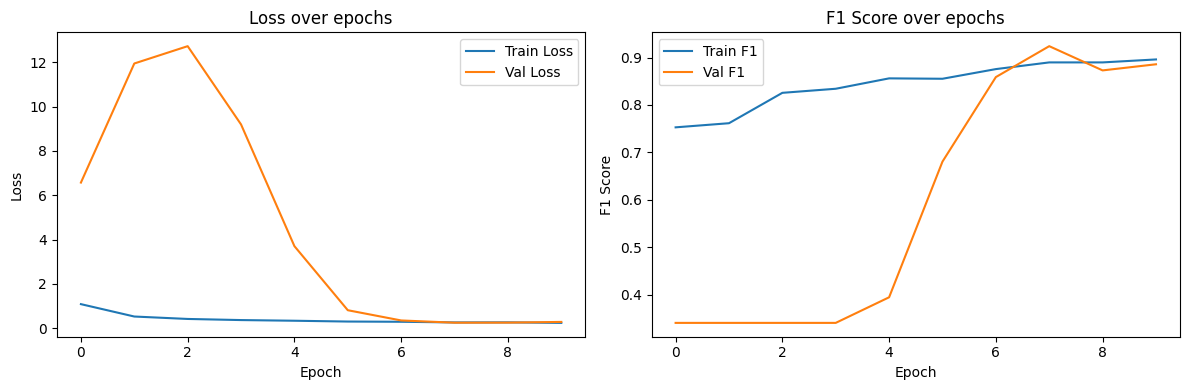

Project state saved to /kaggle/artifacts/baseline


In [ ]:
# Baseline CNN
os.makedirs(f'{artifact_path}/baseline', exist_ok=True)
model_baselinecnn, history_baseline = train_model(BaselineCNN(), [train_orig_loader, train_augm_loader], val_loader, NUM_EPOCHS, device, "baseline")

Starting training...

Epoch 1/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.49      1.00      0.66        39

    accuracy                           0.49        79
   macro avg       0.25      0.50      0.33        79
weighted avg       0.24      0.49      0.33        79

Confusion Matrix:
[[ 0 40]
 [ 0 39]]
Train - Loss: 0.7993, Acc: 0.7128, F1: 0.7095
Val - Loss: 49.4474, Acc: 0.4937, F1: 0.3263
Model saved with F1 score: 0.3263

Epoch 2/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.49      1.00      0.66        39

    accuracy                           0.49        79
   macro avg       0.25      0.50      0.33        79
weighted avg       0.24      0.49      0.33        79

Confusion Matrix:
[[ 0 40]
 [ 0 39]]
Train - Loss: 0.4804, Acc: 0.7887, F1: 0.7882
Val - Loss: 10.2834, Acc: 0.4937, F1: 0.3263

Epoch 3/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.70        40
           1       1.00      0.10      0.19        39

    accuracy                           0.56        79
   macro avg       0.77      0.55      0.44        79
weighted avg       0.76      0.56      0.44        79

Confusion Matrix:
[[40  0]
 [35  4]]
Train - Loss: 0.4449, Acc: 0.8146, F1: 0.8145
Val - Loss: 1.1068, Acc: 0.5570, F1: 0.4441
Model saved with F1 score: 0.4441

Epoch 4/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.97      0.83        40
           1       0.96      0.62      0.75        39

    accuracy                           0.80        79
   macro avg       0.84      0.80      0.79        79
weighted avg       0.84      0.80      0.79        79

Confusion Matrix:
[[39  1]
 [15 24]]
Train - Loss: 0.4089, Acc: 0.8177, F1: 0.8174
Val - Loss: 0.3480, Acc: 0.7975, F1: 0.7904
Model saved with F1 score: 0.7904

Epoch 5/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        40
           1       0.97      0.74      0.84        39

    accuracy                           0.86        79
   macro avg       0.88      0.86      0.86        79
weighted avg       0.88      0.86      0.86        79

Confusion Matrix:
[[39  1]
 [10 29]]
Train - Loss: 0.3895, Acc: 0.8279, F1: 0.8279
Val - Loss: 0.3067, Acc: 0.8608, F1: 0.8587
Model saved with F1 score: 0.8587

Epoch 6/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        40
           1       1.00      0.51      0.68        39

    accuracy                           0.76        79
   macro avg       0.84      0.76      0.74        79
weighted avg       0.84      0.76      0.74        79

Confusion Matrix:
[[40  0]
 [19 20]]
Train - Loss: 0.4089, Acc: 0.8130, F1: 0.8126
Val - Loss: 0.4235, Acc: 0.7595, F1: 0.7438

Epoch 7/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        40
           1       0.94      0.79      0.86        39

    accuracy                           0.87        79
   macro avg       0.88      0.87      0.87        79
weighted avg       0.88      0.87      0.87        79

Confusion Matrix:
[[38  2]
 [ 8 31]]
Train - Loss: 0.3844, Acc: 0.8326, F1: 0.8323
Val - Loss: 0.3204, Acc: 0.8734, F1: 0.8726
Model saved with F1 score: 0.8726

Epoch 8/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        40
           1       0.88      0.90      0.89        39

    accuracy                           0.89        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.89      0.89      0.89        79

Confusion Matrix:
[[35  5]
 [ 4 35]]
Train - Loss: 0.3707, Acc: 0.8333, F1: 0.8333
Val - Loss: 0.3266, Acc: 0.8861, F1: 0.8861
Model saved with F1 score: 0.8861

Epoch 9/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        40
           1       0.86      0.82      0.84        39

    accuracy                           0.85        79
   macro avg       0.85      0.85      0.85        79
weighted avg       0.85      0.85      0.85        79

Confusion Matrix:
[[35  5]
 [ 7 32]]
Train - Loss: 0.3825, Acc: 0.8200, F1: 0.8200
Val - Loss: 0.3282, Acc: 0.8481, F1: 0.8480

Epoch 10/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        40
           1       0.82      0.92      0.87        39

    accuracy                           0.86        79
   macro avg       0.87      0.86      0.86        79
weighted avg       0.87      0.86      0.86        79

Confusion Matrix:
[[32  8]
 [ 3 36]]
Train - Loss: 0.3914, Acc: 0.8153, F1: 0.8150
Val - Loss: 0.3098, Acc: 0.8608, F1: 0.8603
Training complete!


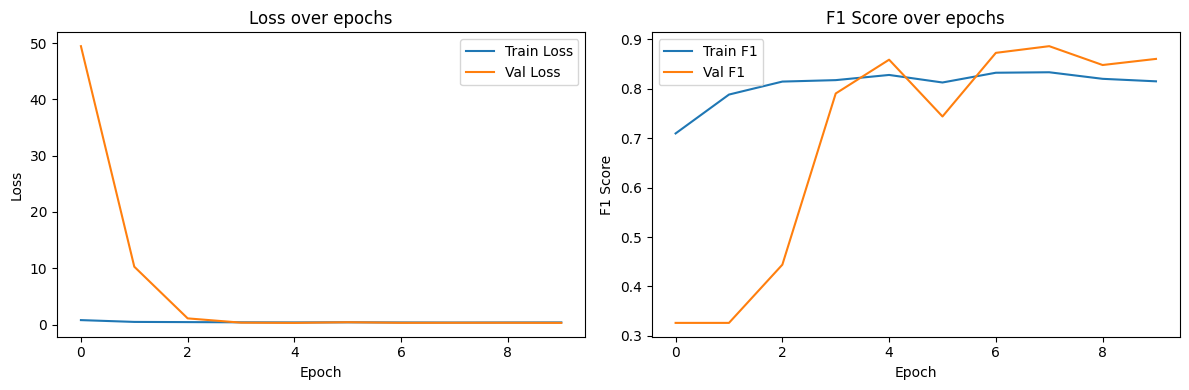

Project state saved to /kaggle/artifacts/resnet18


In [ ]:
# ResNet18 implementation
os.makedirs(f'{artifact_path}/resnet18', exist_ok=True)
model_resnet18, history_resnet18 = train_model(ResNet18(), [train_orig_loader, train_augm_loader], val_loader, NUM_EPOCHS, device, 'resnet18')

Starting training...

Epoch 1/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.49      1.00      0.66        39

    accuracy                           0.49        79
   macro avg       0.25      0.50      0.33        79
weighted avg       0.24      0.49      0.33        79

Confusion Matrix:
[[ 0 40]
 [ 0 39]]
Train - Loss: 0.7972, Acc: 0.6878, F1: 0.6824
Val - Loss: 0.9061, Acc: 0.4937, F1: 0.3263
Model saved with F1 score: 0.3263

Epoch 2/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        40
           1       1.00      0.05      0.10        39

    accuracy                           0.53        79
   macro avg       0.76      0.53      0.39        79
weighted avg       0.76      0.53      0.39        79

Confusion Matrix:
[[40  0]
 [37  2]]
Train - Loss: 0.4836, Acc: 0.7981, F1: 0.7972
Val - Loss: 0.8206, Acc: 0.5316, F1: 0.3944
Model saved with F1 score: 0.3944

Epoch 3/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.97      0.76        40
           1       0.94      0.41      0.57        39

    accuracy                           0.70        79
   macro avg       0.79      0.69      0.67        79
weighted avg       0.78      0.70      0.67        79

Confusion Matrix:
[[39  1]
 [23 16]]
Train - Loss: 0.4712, Acc: 0.8059, F1: 0.8057
Val - Loss: 0.4836, Acc: 0.6962, F1: 0.6693
Model saved with F1 score: 0.6693

Epoch 4/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        40
           1       0.90      0.67      0.76        39

    accuracy                           0.80        79
   macro avg       0.82      0.80      0.79        79
weighted avg       0.82      0.80      0.79        79

Confusion Matrix:
[[37  3]
 [13 26]]
Train - Loss: 0.4380, Acc: 0.8138, F1: 0.8137
Val - Loss: 0.3573, Acc: 0.7975, F1: 0.7938
Model saved with F1 score: 0.7938

Epoch 5/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        40
           1       0.78      1.00      0.88        39

    accuracy                           0.86        79
   macro avg       0.89      0.86      0.86        79
weighted avg       0.89      0.86      0.86        79

Confusion Matrix:
[[29 11]
 [ 0 39]]
Train - Loss: 0.3878, Acc: 0.8192, F1: 0.8189
Val - Loss: 0.3325, Acc: 0.8608, F1: 0.8583
Model saved with F1 score: 0.8583

Epoch 6/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        40
           1       1.00      0.51      0.68        39

    accuracy                           0.76        79
   macro avg       0.84      0.76      0.74        79
weighted avg       0.84      0.76      0.74        79

Confusion Matrix:
[[40  0]
 [19 20]]
Train - Loss: 0.4035, Acc: 0.8349, F1: 0.8349
Val - Loss: 0.4073, Acc: 0.7595, F1: 0.7438

Epoch 7/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        40
           1       0.97      0.85      0.90        39

    accuracy                           0.91        79
   macro avg       0.92      0.91      0.91        79
weighted avg       0.92      0.91      0.91        79

Confusion Matrix:
[[39  1]
 [ 6 33]]
Train - Loss: 0.3920, Acc: 0.8263, F1: 0.8256
Val - Loss: 0.2923, Acc: 0.9114, F1: 0.9110
Model saved with F1 score: 0.9110

Epoch 8/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        40
           1       0.94      0.74      0.83        39

    accuracy                           0.85        79
   macro avg       0.86      0.85      0.85        79
weighted avg       0.86      0.85      0.85        79

Confusion Matrix:
[[38  2]
 [10 29]]
Train - Loss: 0.3903, Acc: 0.8333, F1: 0.8333
Val - Loss: 0.3170, Acc: 0.8481, F1: 0.8463

Epoch 9/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.85        40
           1       0.93      0.72      0.81        39

    accuracy                           0.84        79
   macro avg       0.85      0.83      0.83        79
weighted avg       0.85      0.84      0.83        79

Confusion Matrix:
[[38  2]
 [11 28]]
Train - Loss: 0.3655, Acc: 0.8365, F1: 0.8362
Val - Loss: 0.3399, Acc: 0.8354, F1: 0.8330

Epoch 10/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        40
           1       0.74      1.00      0.85        39

    accuracy                           0.82        79
   macro avg       0.87      0.82      0.82        79
weighted avg       0.87      0.82      0.82        79

Confusion Matrix:
[[26 14]
 [ 0 39]]
Train - Loss: 0.3707, Acc: 0.8396, F1: 0.8396
Val - Loss: 0.4212, Acc: 0.8228, F1: 0.8175
Training complete!


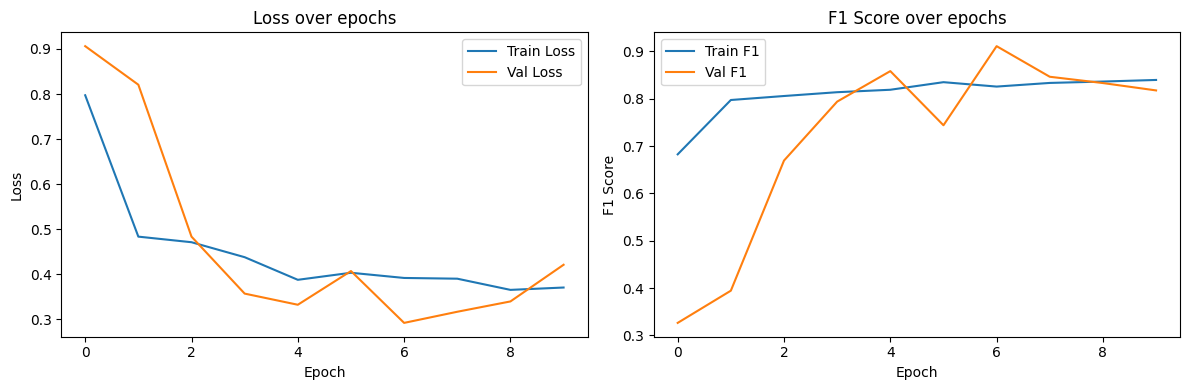

Project state saved to /kaggle/artifacts/cbamresnet18


In [ ]:
# CBAM-ResNet18
os.makedirs(f'{artifact_path}/cbamresnet18', exist_ok=True)
model_cbamresnet18, history_cbamresnet18 = train_model(CBAMResNet18(), [train_orig_loader, train_augm_loader], val_loader, NUM_EPOCHS, device, 'cbamresnet18')

## Evaluation on Original Test Data



In [ ]:
# Baseline CNN
# The code was ran on Kaggle, read the model artifacts instead
baseline_cnn_model = BaselineCNN()
baseline_cnn_model.load_state_dict(torch.load(f"{eval_artifact_path}/baseline/best_baseline_model.pth"))
baseline_cnn_artifacts = torch.load(f"{eval_artifact_path}/baseline/model_baseline_checkpoint.pth", weights_only=False)

In [ ]:
# ResNet18
resnet_model = ResNet18()
resnet_model.load_state_dict(torch.load(f"{eval_artifact_path}/resnet18/best_resnet18_model.pth"))
resnet_artifacts = torch.load(f"{eval_artifact_path}/resnet18/model_resnet18_checkpoint.pth", weights_only=False)

In [ ]:
# CBAM-ResNet18
cbam_model = CBAMResNet18()
cbam_model.load_state_dict(torch.load(f"{eval_artifact_path}/cbamresnet18/best_cbamresnet18_model.pth"))
cbam_artifacts = torch.load(f"{eval_artifact_path}/cbamresnet18/model_cbamresnet18_checkpoint.pth", weights_only=False)

In [ ]:
# Evaluate all models on the test set
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    artifacts = {"accuracy": accuracy, "f1": f1, "confusion_matrix": cm}
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    return accuracy, f1, cm, artifacts

In [ ]:
# Evaluate Baseline CNN
print("Evaluating Baseline CNN...")
baseline_cnn_model.to(device)
baseline_cnn_accuracy, baseline_cnn_f1, baseline_cnn_cm, baseline_cnn_test_artifact = evaluate_model(baseline_cnn_model, test_loader, device)
print(f"Baseline CNN - Accuracy: {baseline_cnn_accuracy:.4f}, F1 Score: {baseline_cnn_f1:.4f}")
print("\n")
torch.save(baseline_cnn_test_artifact, f"{eval_artifact_path}/baseline/baseline_cnn_test_artifact.pth")

# Evaluate ResNet18
print("Evaluating ResNet18...")
resnet_model.to(device)
resnet_accuracy, resnet_f1, resnet_cm, resnet_test_artifact = evaluate_model(resnet_model, test_loader, device)
print(f"ResNet18 - Accuracy: {resnet_accuracy:.4f}, F1 Score: {resnet_f1:.4f}")
print("\n")
torch.save(resnet_test_artifact, f"{eval_artifact_path}/resnet18/resnet18_test_artifact.pth")

# Evaluate CBAM-ResNet18
print("Evaluating CBAM-ResNet18...")
cbam_model.to(device)
cbam_accuracy, cbam_f1, cbam_cm, cbam_test_artifacts = evaluate_model(cbam_model, test_loader, device)
print(f"CBAM-ResNet18 - Accuracy: {cbam_accuracy:.4f}, F1 Score: {cbam_f1:.4f}")
print("\n")
torch.save(cbam_test_artifacts, f"{eval_artifact_path}/cbamresnet18/cbam_resnet_test_artifact.pth")

Evaluating Baseline CNN...


Evaluating: 100%|██████████| 63/63 [01:34<00:00,  1.51s/it]


Confusion Matrix:
 [[3923   74]
 [ 122 3876]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      3997
           1       0.98      0.97      0.98      3998

    accuracy                           0.98      7995
   macro avg       0.98      0.98      0.98      7995
weighted avg       0.98      0.98      0.98      7995

Baseline CNN - Accuracy: 0.9755, F1 Score: 0.9755


Evaluating ResNet18...


Evaluating: 100%|██████████| 63/63 [01:27<00:00,  1.40s/it]


Confusion Matrix:
 [[3910   87]
 [  62 3936]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3997
           1       0.98      0.98      0.98      3998

    accuracy                           0.98      7995
   macro avg       0.98      0.98      0.98      7995
weighted avg       0.98      0.98      0.98      7995

ResNet18 - Accuracy: 0.9814, F1 Score: 0.9814


Evaluating CBAM-ResNet18...


Evaluating: 100%|██████████| 63/63 [01:23<00:00,  1.32s/it]

Confusion Matrix:
 [[3936   61]
 [  88 3910]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3997
           1       0.98      0.98      0.98      3998

    accuracy                           0.98      7995
   macro avg       0.98      0.98      0.98      7995
weighted avg       0.98      0.98      0.98      7995

CBAM-ResNet18 - Accuracy: 0.9814, F1 Score: 0.9814




The results of the train and test set are summarised in the table below. The train F1 score shows the best performing epoch of each model. The test F1 score was evaluated using the best model on the holdout test set.

| Model    | Train F1 Score | Validation F1 Score | Test F1 Score |
| -------- | ------- | ------- | ------- |
| Two-layer Vanilla CNN  | 0.9641 | 0.9749 | 0.9755 |
| ResNet18 | 0.9518 | 0.9806 | 0.9814 |
| CBAM ResNet18    | 0.9613 | 0.9783 | 0.9814 |

All three models performed well on the image classification task of detecting real or fake images. However, ResNet-18 and CBAM-ResNet performed slightly better than the two-layer vanilla CNN. This is expected given that ResNet and CBAM-ResNet are deeper neural networks which leads to better model performance. The incorporation of the attention mechanism in CNNs, which makes the neural network focus on more important features may have also improved the model performance. Nonetheless, there difference between the model performances were small. This might be due to the fact that the problem was well-defined and uses a specially curated dataset, which makes model training easier.

We were also able to plot the feature maps of the CNN layers. These feature maps show the features captured by each layer in the model. It can also be used to explain the prediction of the models. The first layer of all models focus on the edges and contrast of the images. The feature maps below highlighted the missing fingers in the fake image, which is a common problem in many generated images. This was highlighted more in CBAM-ResNet. However, while plotting the feature maps of different models, we noted the deeper layers of CBAM-ResNet did not contain as many highlighted features as ResNet-18 and the vanilla CNN. A more in-depth study can be conducted by changing the number of CBAM blocks.

In [ ]:
# Example usage
# Visualize attention maps
fake_paths = df[df['label'] == 1]['id'].tolist()
fake_paths = [os.path.join(data_path, path) for path in fake_paths]
real_paths = df[df['label'] == 0]['id'].tolist()
real_paths = [os.path.join(data_path, path) for path in real_paths]

In [ ]:
# Get feature maps from CNNs
def extract_feature_maps(model, input_image, layer_names=None):
    """
    Extract feature maps from specific layers of a CNN model.

    Args:
        model: The CNN model (BaselineCNN, ResNet18, or CBAMResNet18)
        input_image: Input tensor of shape [batch_size, channels, height, width]
        layer_names: List of layer names to extract features from. If None, extracts from all major layers.

    Returns:
        Dictionary mapping layer names to their feature maps
    """
    # Store feature maps
    feature_maps = {}

    # Hooks for capturing feature maps
    hooks = []

    def get_activation(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach().clone()

        return hook

    # For BaselineCNN
    if isinstance(model, BaselineCNN):
        if layer_names is None:
            layer_names = ["conv1", "conv2"]

        # Register hooks for each requested layer
        for name in layer_names:
            if hasattr(model, name):
                hook = getattr(model, name).register_forward_hook(get_activation(name))
                hooks.append(hook)

    # For ResNet18
    elif isinstance(model, ResNet18):
        if layer_names is None:
            layer_names = ["conv1", "conv2", "conv3", "conv4", "conv5"]

        # Register hooks for each requested layer
        for name in layer_names:
            if hasattr(model, name):
                hook = getattr(model, name).register_forward_hook(get_activation(name))
                hooks.append(hook)

    # For CBAMResNet18
    elif isinstance(model, CBAMResNet18):
        if layer_names is None:
            layer_names = ["conv1", "conv2", "conv3", "conv4", "conv5"]

        # Register hooks for each requested layer
        for name in layer_names:
            if hasattr(model, name):
                hook = getattr(model, name).register_forward_hook(get_activation(name))
                hooks.append(hook)

        # Extract CBAM attention maps specifically
        def cbam_hook(module, input, output, module_name):
            if hasattr(module, "ca") and hasattr(module.ca, "attention_map"):
                feature_maps[f"{module_name}_channel_attention"] = module.ca.attention_map

            if hasattr(module, "sa") and hasattr(module.sa, "attention_map"):
                feature_maps[f"{module_name}_spatial_attention"] = module.sa.attention_map

            if hasattr(module, "feature_map"):
                feature_maps[f"{module_name}_feature_map"] = module.feature_map

        # Get CBAM blocks through residual blocks
        for i, layer in enumerate([model.conv2, model.conv3, model.conv4, model.conv5]):
            for j, block in enumerate(layer):
                if hasattr(block, "cbam1"):
                    module_name = f"layer{i+2}_block{j+1}_cbam"
                    hook = block.cbam1.register_forward_hook(lambda mod, inp, out, name=module_name: cbam_hook(mod, inp, out, name))
                    hooks.append(hook)

    # Pass the input through the model
    with torch.no_grad():
        outputs = model(input_image)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return feature_maps, outputs


def visualize_feature_maps_overlay(original_image, feature_maps, image_size=128, use_cbam=False, max_num_layers=5):
    """
    Visualize feature maps as heatmaps overlaid on the original image.

    Args:
        original_image: Original input image tensor (B, C, H, W)
        feature_maps: Dictionary of feature maps extracted from the model
        image_size: Size to resize images for display
        use_cbam: Whether CBAM is being used
        max_num_layers: Maximum number of layers to visualize
    """
    # Convert original image for display
    if isinstance(original_image, torch.Tensor):
        # If normalized, approximately denormalize for display
        if original_image.min() < 0 or original_image.max() > 1:
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(original_image.device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(original_image.device)
            display_image = original_image * std + mean
            display_image = torch.clamp(display_image, 0, 1)
        else:
            display_image = original_image

        input_img = display_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    else:
        input_img = original_image

    # Create figure for plotting
    n_layers = min(len(feature_maps), max_num_layers)
    if n_layers == 0:
        return

    # One row per layer, 3 columns (original, feature map, overlay)
    fig, axes = plt.subplots(n_layers, 3, figsize=(15, 5 * n_layers))
    if n_layers == 1:
        axes = axes.reshape(1, -1)

    # Sort layers (often we want them in order of network depth)
    sorted_layers = sorted(feature_maps.keys())[:max_num_layers]

    for i, layer_name in enumerate(sorted_layers):
        features = feature_maps[layer_name]

        # Skip non-spatial features
        if len(features.shape) < 4:
            continue

        # Create combined feature map (maximum activation across channels)
        if len(features.shape) == 4:  # Regular feature maps: [batch, channels, height, width]
            combined_feature = torch.max(features[0], dim=0)[0].cpu().numpy()
        else:  # Handle special cases
            combined_feature = features[0].cpu().numpy()

        # Resize feature map to match image size
        resized_feature = cv2.resize(combined_feature, (image_size, image_size))

        # Normalize feature map for visualization
        normalized_feature = cv2.normalize(resized_feature, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Create heatmap
        heatmap = cv2.applyColorMap(normalized_feature, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

        # Overlay heatmap on original image
        # Convert input_img to uint8 if needed
        if input_img.max() <= 1.0:
            display_img = (input_img * 255).astype(np.uint8)
        else:
            display_img = input_img.astype(np.uint8)

        # Resize original image if needed
        if display_img.shape[0] != image_size or display_img.shape[1] != image_size:
            display_img = cv2.resize(display_img, (image_size, image_size))

        # Create overlay with heatmap
        heatmap_overlay = cv2.addWeighted(display_img, 0.7, heatmap, 0.3, 0)  # Original image with 70% weight  # Heatmap with 30% weight  # Gamma correction

        # Display images in the row
        axes[i, 0].imshow(display_img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(resized_feature, cmap="viridis")
        title = f"{layer_name} Feature Map"
        if "cbam" in layer_name:
            title += " with CBAM"
        axes[i, 1].set_title(title)
        axes[i, 1].axis("off")

        axes[i, 2].imshow(heatmap_overlay)
        axes[i, 2].set_title("Feature Map Overlay")
        axes[i, 2].axis("off")

    plt.tight_layout()

    plt.show()

    return fig


def visualize_model_predictions(model, image_path, image_size=128, use_cbam=False):
    """
    Complete pipeline to visualize feature maps from a CNN model

    Args:
        model: The CNN model (BaselineCNN, ResNet18, or CBAMResNet18)
        image_path: Path to the input image
        image_size: Size to resize the image to
        use_cbam: Whether CBAM is being used
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Load and preprocess image
    transform = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])  # Converts to tensor and scales from [0, 255] to [0, 1]

    # Load original image for display purposes
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize((image_size, image_size))

    # Process for model input
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    # Extract feature maps
    feature_maps, outputs = extract_feature_maps(model, input_tensor)

    # Get predicted class (assuming classification model)
    if hasattr(model, "fc2") or hasattr(model, "linear"):
        softmaxed_output = torch.nn.Softmax(dim=1)(outputs)
        predicted_class = torch.argmax(softmaxed_output).item()
        class_probability = softmaxed_output[0, predicted_class].item()

        # You can provide class names if needed
        class_names = ["Class 0", "Class 1"]  # Replace with actual class names
        if len(class_names) > predicted_class:
            prediction_text = f"Prediction: {class_names[predicted_class]} ({class_probability:.2f})"
        else:
            prediction_text = f"Prediction: Class {predicted_class} ({class_probability:.2f})"

        print(prediction_text)

    # Visualize the feature maps
    fig = visualize_feature_maps_overlay(input_tensor, feature_maps, image_size=image_size, use_cbam=use_cbam)

    return

Prediction: Class 1 (1.00)


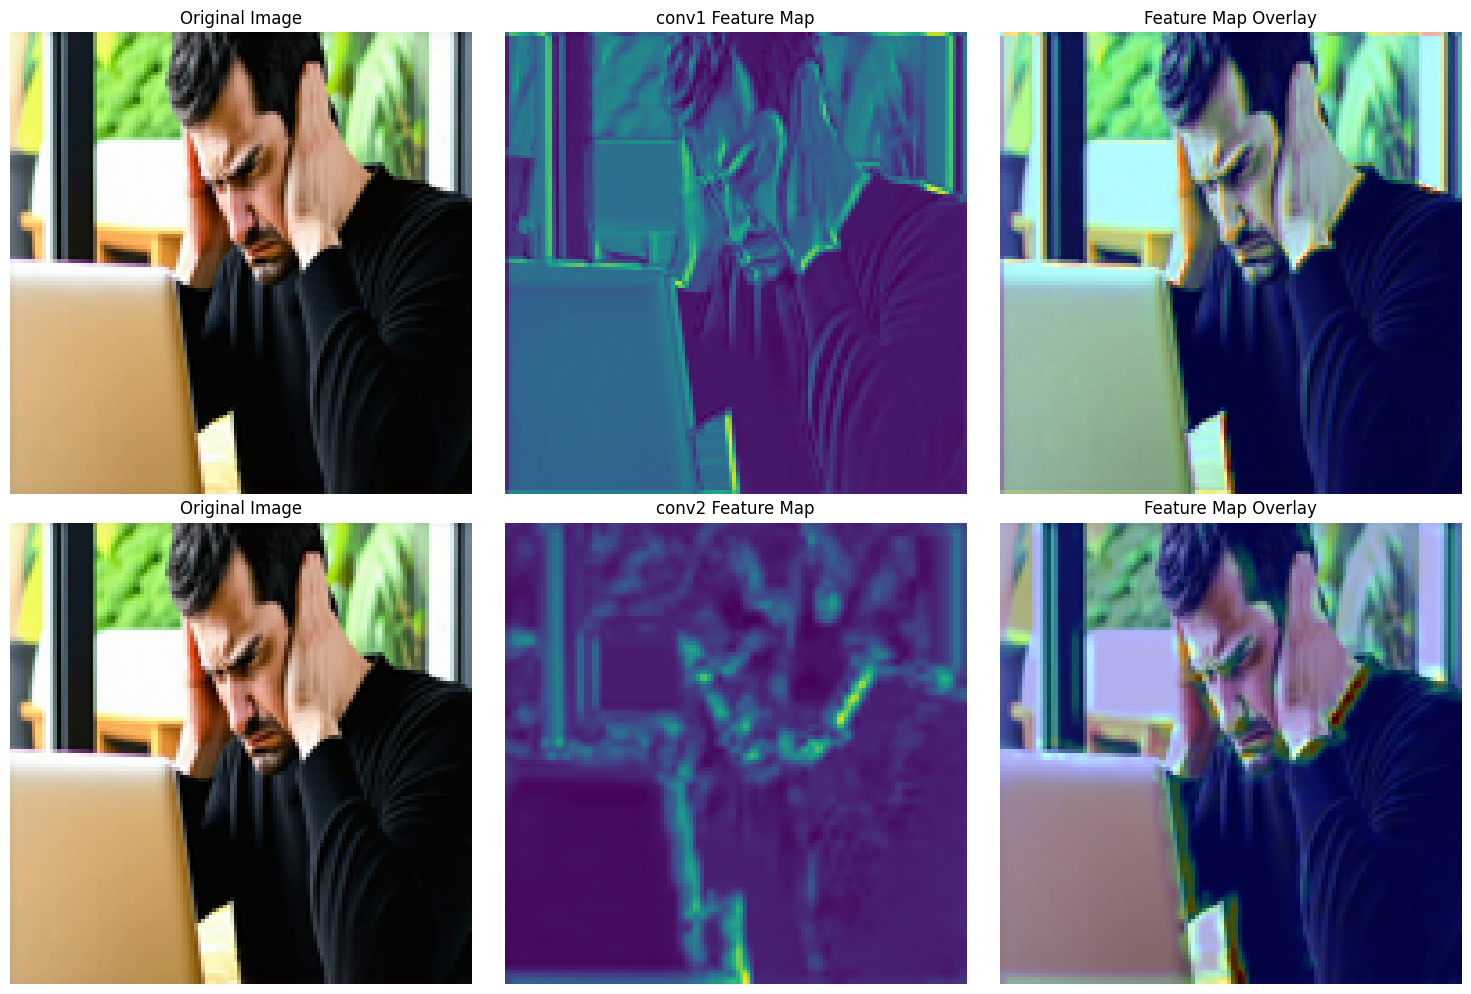

Prediction: Class 1 (1.00)


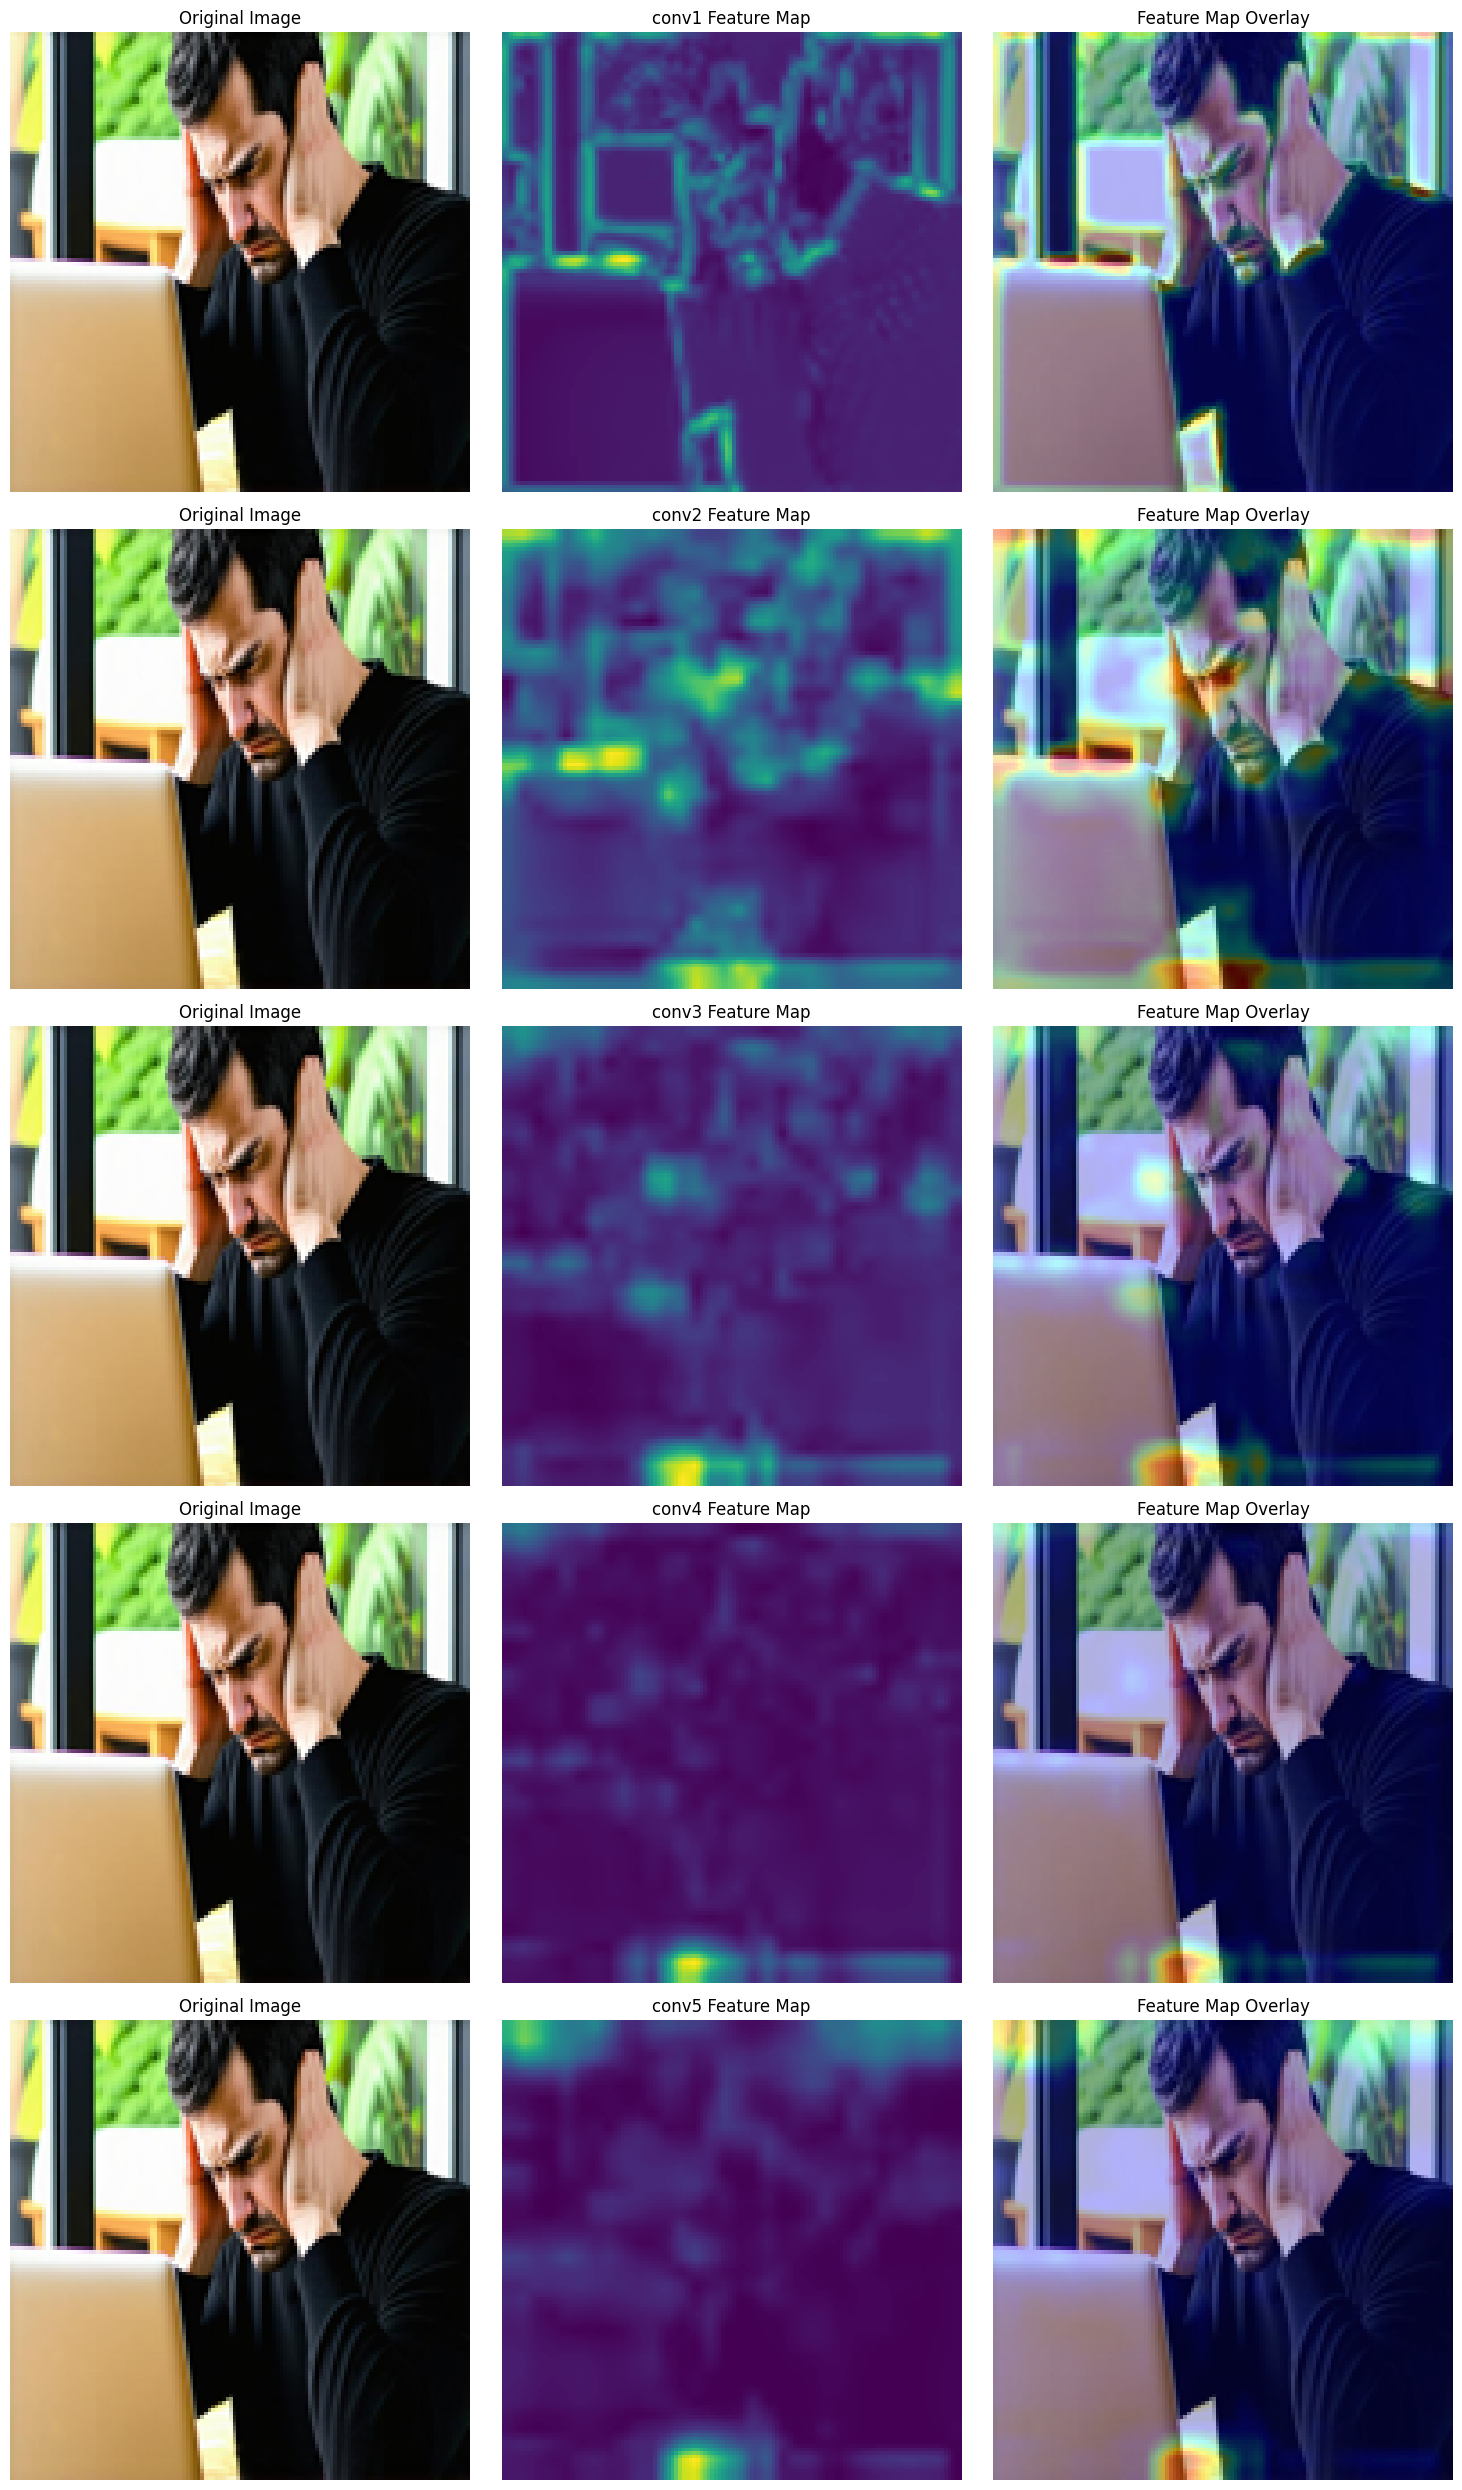

Prediction: Class 1 (1.00)


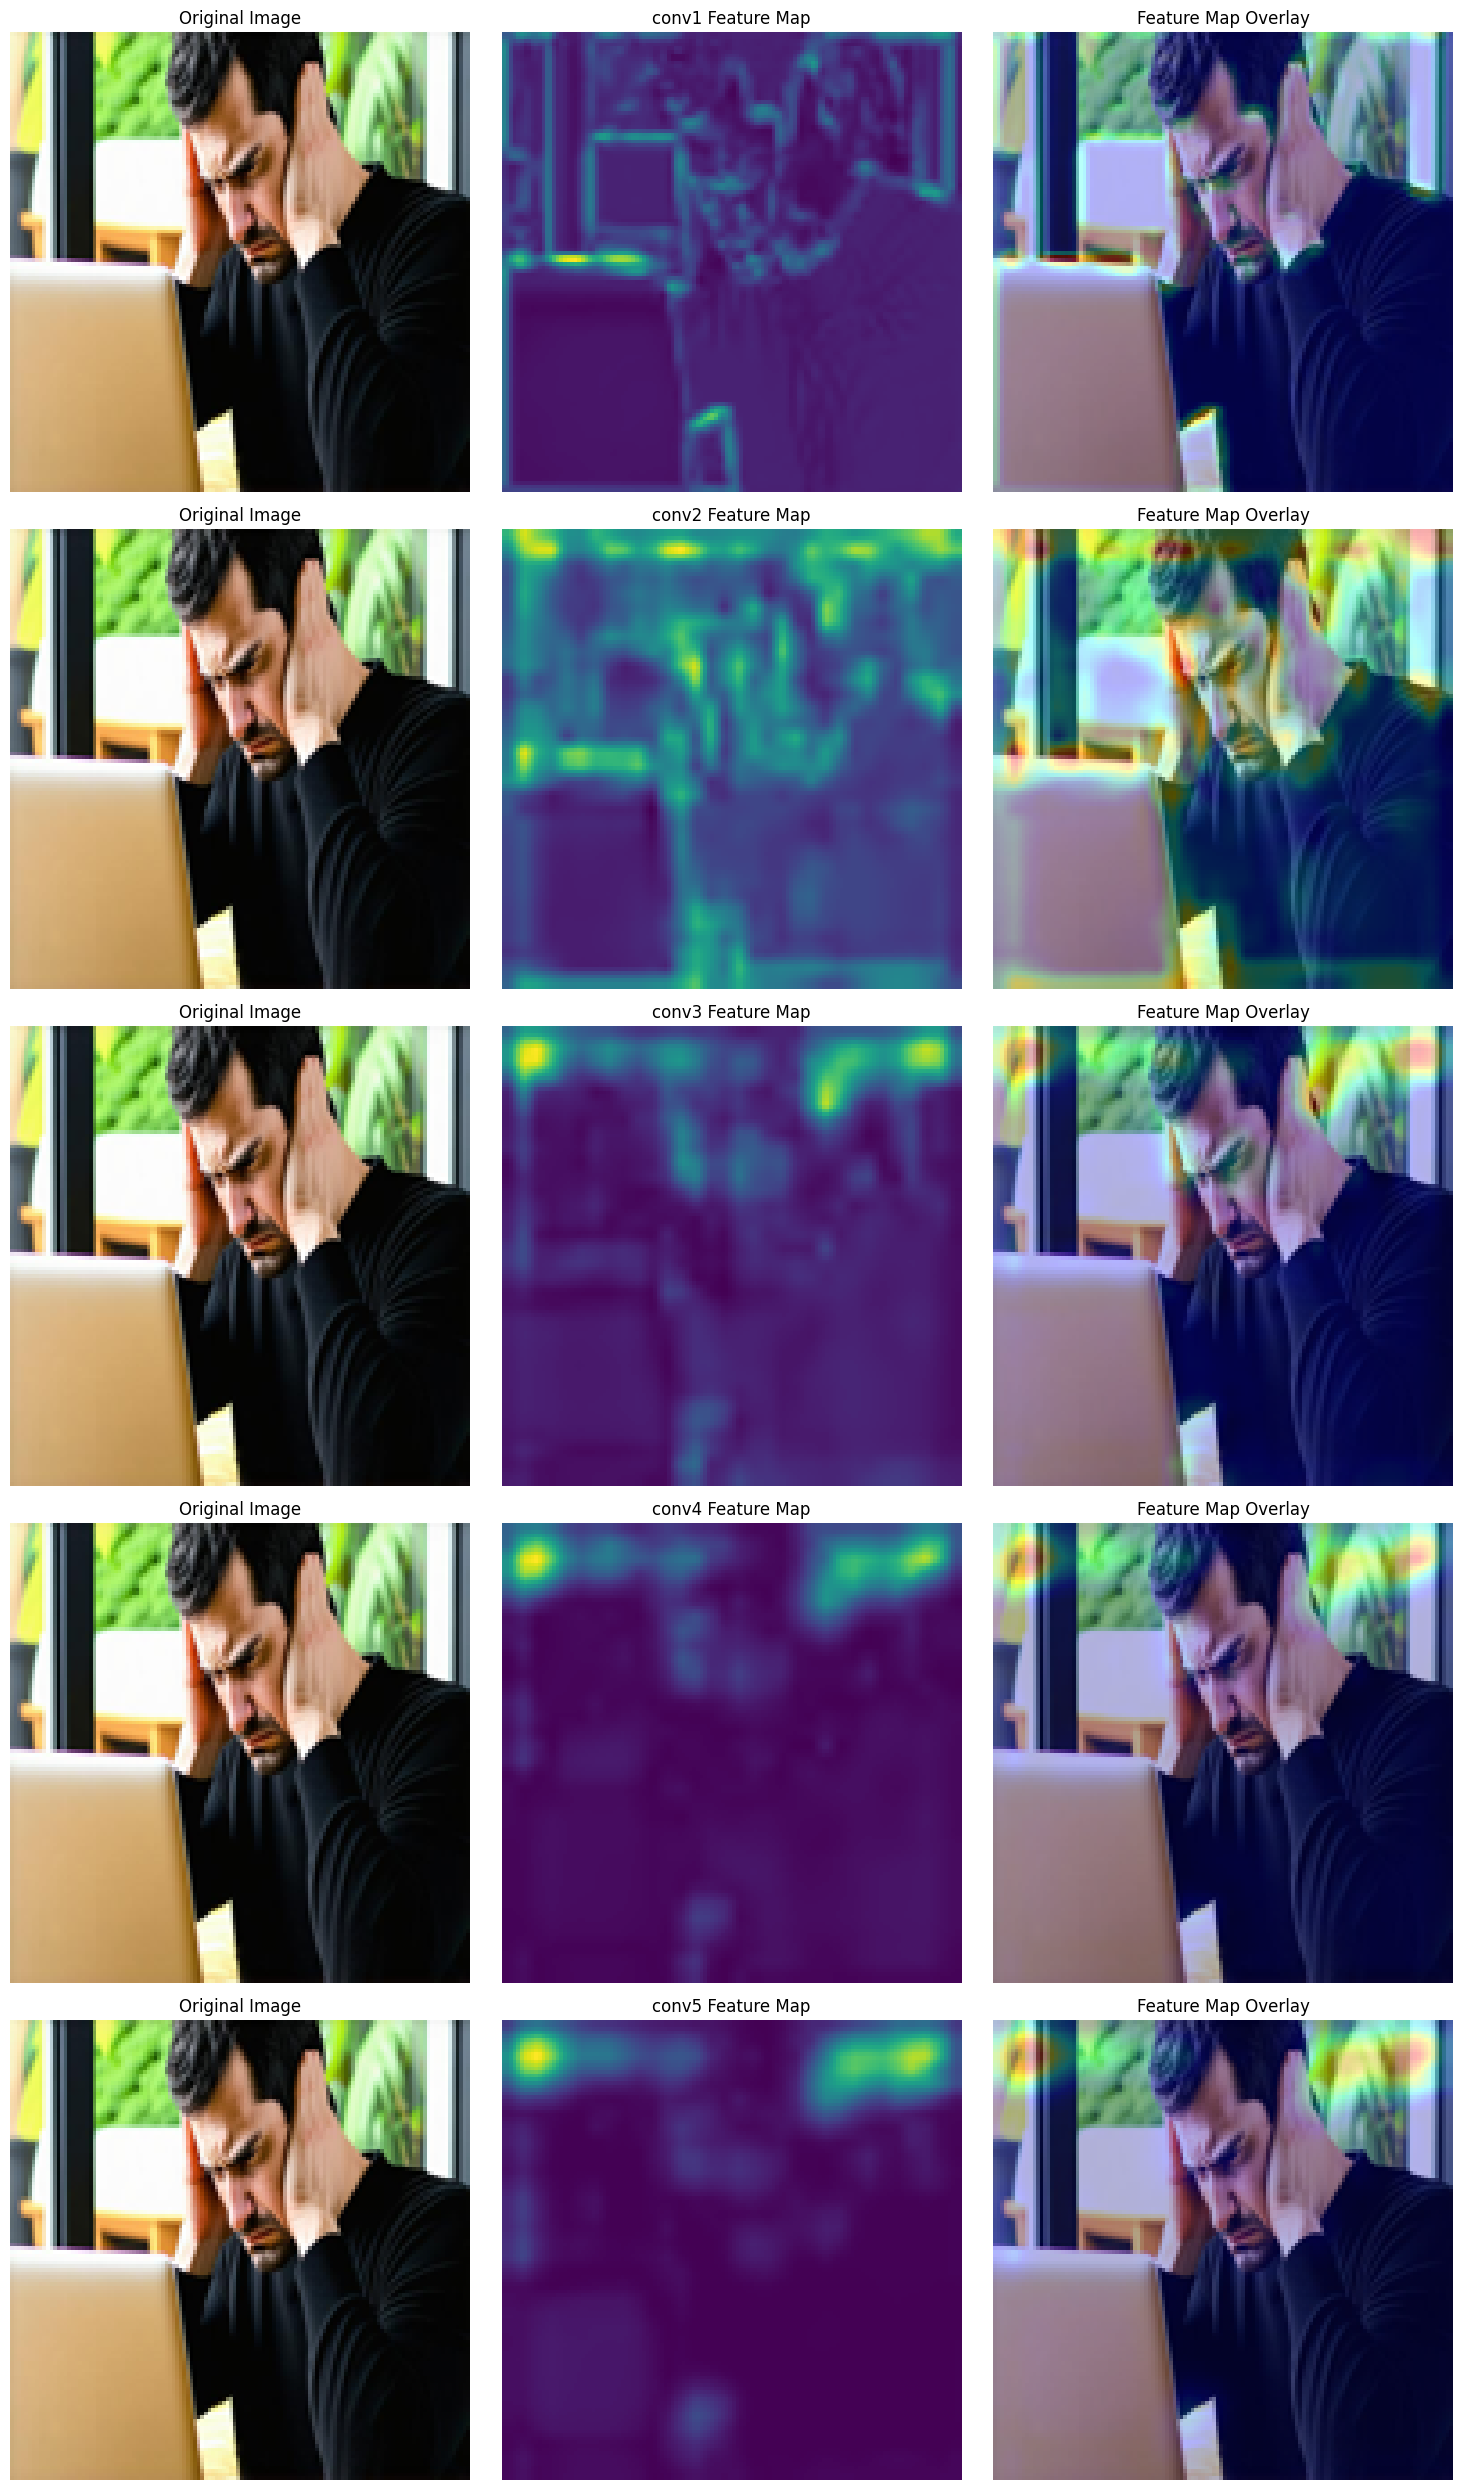

In [ ]:
# Get feature maps
image_path = f"{data_path}/train_data/00abe09522f34b528a461fb9d64555c4.jpg"  # Example image path
# For BaselineCNN
visualize_model_predictions(baseline_cnn_model, image_path, image_size=128)

# For ResNet18
visualize_model_predictions(resnet_model, image_path, image_size=128)

# For CBAMResNet18
visualize_model_predictions(cbam_model, image_path, image_size=128, use_cbam=True)

## Evaluation on Our Generated Images

Up until now, the evaluation has only been performed on the test portion of the `AI vs. Human-Generated Images` dataset. This test set is expected to strongly correlate with the training set, which explains the models' performance so far. So, to further generalize the models, we created our own test dataset, which was generated using three distinct types of image generation models: Variational Autoencoders (VAEs), Generative Adversarial Networks (GANs), and Diffusion Models.

We evaluated each model on 4,000 images for VAE, GAN-Pretrained, and GAN-Finetuned, and on approximately 350 images for the Diffusion Model (limitation of inference credits).





In [ ]:
# Baseline CNN
baseline_cnn_model = BaselineCNN()
baseline_cnn_model.load_state_dict(torch.load(f"{eval_artifact_path}/baseline/best_baseline_model.pth"))
baseline_cnn_model = baseline_cnn_model.to(device)

# ResNet18
resnet_model = ResNet18()
resnet_model.load_state_dict(torch.load(f"{eval_artifact_path}/resnet18/best_resnet18_model.pth"))
resnet_model = resnet_model.to(device)

# CBAM-ResNet18
cbam_model = CBAMResNet18()
cbam_model.load_state_dict(torch.load(f"{eval_artifact_path}/cbamresnet18/best_cbamresnet18_model.pth"))
cbam_model = cbam_model.to(device)

In [ ]:
# Evaluate Baseline CNN
baseline_cnn_model.to(device)
print("Evaluating Baseline CNN on VAE...")
baseline_cnn_accuracy, baseline_cnn_f1, baseline_cnn_cm, baseline_cnn_test_artifact = evaluate_model(baseline_cnn_model, test_loader_vae, device)
print(f"Baseline CNN on VAE - Accuracy: {baseline_cnn_accuracy:.4f}, F1 Score: {baseline_cnn_f1:.4f}")
print("\n")
torch.save(baseline_cnn_test_artifact, f"{eval_artifact_path}/baseline/baseline_cnn_test_vae_artifact.pth")

print("Evaluating Baseline CNN on GAN Pretrained...")
baseline_cnn_accuracy, baseline_cnn_f1, baseline_cnn_cm, baseline_cnn_test_artifact = evaluate_model(baseline_cnn_model, test_loader_ganpt, device)
print(f"Baseline CNN on GAN Pretrained - Accuracy: {baseline_cnn_accuracy:.4f}, F1 Score: {baseline_cnn_f1:.4f}")
print("\n")
torch.save(baseline_cnn_test_artifact, f"{eval_artifact_path}/baseline/baseline_cnn_test_ganpt_artifact.pth")

print("Evaluating Baseline CNN on GAN Finetuned...")
baseline_cnn_accuracy, baseline_cnn_f1, baseline_cnn_cm, baseline_cnn_test_artifact = evaluate_model(baseline_cnn_model, test_loader_ganft, device)
print(f"Baseline CNN on GAN Finetuned - Accuracy: {baseline_cnn_accuracy:.4f}, F1 Score: {baseline_cnn_f1:.4f}")
print("\n")
torch.save(baseline_cnn_test_artifact, f"{eval_artifact_path}/baseline/baseline_cnn_test_ganft_artifact.pth")

print("Evaluating Baseline CNN on Diffusion Model...")
baseline_cnn_accuracy, baseline_cnn_f1, baseline_cnn_cm, baseline_cnn_test_artifact = evaluate_model(baseline_cnn_model, test_loader_dm, device)
print(f"Baseline CNN on Diffusion Model - Accuracy: {baseline_cnn_accuracy:.4f}, F1 Score: {baseline_cnn_f1:.4f}")
print("\n")
torch.save(baseline_cnn_test_artifact, f"{eval_artifact_path}/baseline/baseline_cnn_test_dm_artifact.pth")

Evaluating Baseline CNN on VAE...


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.62it/s]

Confusion Matrix:
 [[  0   0]
 [500   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     500.0

    accuracy                           0.00     500.0
   macro avg       0.00      0.00      0.00     500.0
weighted avg       0.00      0.00      0.00     500.0

Baseline CNN on VAE - Accuracy: 0.0000, F1 Score: 0.0000





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/

Evaluating Baseline CNN on GAN Pretrained...


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 34.11it/s]

Confusion Matrix:
 [[  0   0]
 [498   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.00      0.01       500

    accuracy                           0.00       500
   macro avg       0.50      0.00      0.00       500
weighted avg       1.00      0.00      0.01       500

Baseline CNN on GAN Pretrained - Accuracy: 0.0040, F1 Score: 0.0080


Evaluating Baseline CNN on GAN Finetuned...



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Evaluating: 100%|██████████| 4/4 [00:00<00:00, 30.36it/s]

Confusion Matrix:
 [[  0   0]
 [499   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.00      0.00       500

    accuracy                           0.00       500
   macro avg       0.50      0.00      0.00       500
weighted avg       1.00      0.00      0.00       500

Baseline CNN on GAN Finetuned - Accuracy: 0.0020, F1 Score: 0.0040





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating Baseline CNN on Diffusion Model...


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.45it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[ 0  0]
 [33 11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.25      0.40        44

    accuracy                           0.25        44
   macro avg       0.50      0.12      0.20        44
weighted avg       1.00      0.25      0.40        44

Baseline CNN on Diffusion Model - Accuracy: 0.2500, F1 Score: 0.4000




In [ ]:
# Evaluate ResNet18
print("Evaluating ResNet18 on VAE...")
resnet_model.to(device)
resnet_accuracy, resnet_f1, resnet_cm, resnet_test_artifact = evaluate_model(resnet_model, test_loader_vae, device)
print(f"ResNet18 on VAE- Accuracy: {resnet_accuracy:.4f}, F1 Score: {resnet_f1:.4f}")
print("\n")
torch.save(resnet_test_artifact, f"{eval_artifact_path}/resnet18/resnet18_test_vae_artifact.pth")

print("Evaluating ResNet18 on GAN Pretrained...")
resnet_model.to(device)
resnet_accuracy, resnet_f1, resnet_cm, resnet_test_artifact = evaluate_model(resnet_model, test_loader_ganpt, device)
print(f"ResNet18 on GAN Pretrained - Accuracy: {resnet_accuracy:.4f}, F1 Score: {resnet_f1:.4f}")
print("\n")
torch.save(resnet_test_artifact, f"{eval_artifact_path}/resnet18/resnet18_test_ganpt_artifact.pth")

print("Evaluating ResNet18 on GAN Finetuned...")
resnet_model.to(device)
resnet_accuracy, resnet_f1, resnet_cm, resnet_test_artifact = evaluate_model(resnet_model, test_loader_ganft, device)
print(f"ResNet18 on GAN Finetuned - Accuracy: {resnet_accuracy:.4f}, F1 Score: {resnet_f1:.4f}")
print("\n")
torch.save(resnet_test_artifact, f"{eval_artifact_path}/resnet18/resnet18_test_ganft_artifact.pth")

print("Evaluating ResNet18 on Diffusion Model...")
resnet_model.to(device)
resnet_accuracy, resnet_f1, resnet_cm, resnet_test_artifact = evaluate_model(resnet_model, test_loader_dm, device)
print(f"ResNet18 on Diffusion Model - Accuracy: {resnet_accuracy:.4f}, F1 Score: {resnet_f1:.4f}")
print("\n")
torch.save(resnet_test_artifact, f"{eval_artifact_path}/resnet18/resnet18_test_dm_artifact.pth")


Evaluating ResNet18 on VAE...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Confusion Matrix:
 [[  0   0]
 [500   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     500.0

    accuracy                           0.00     500.0
   macro avg       0.00      0.00      0.00     500.0
weighted avg       0.00      0.00      0.00     500.0

ResNet18 on VAE- Accuracy: 0.0000, F1 Score: 0.0000


Evaluating ResNet18 on GAN Pretrained...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [491   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.02      0.04       500

    accuracy                           0.02       500
   macro avg       0.50      0.01      0.02       500
weighted avg       1.00      0.02      0.04       500

ResNet18 on GAN Pretrained - Accuracy: 0.0180, F1 Score: 0.0354


Evaluating ResNet18 on GAN Finetuned...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [495   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.01      0.02       500

    accuracy                           0.01       500
   macro avg       0.50      0.01      0.01       500
weighted avg       1.00      0.01      0.02       500

ResNet18 on GAN Finetuned - Accuracy: 0.0100, F1 Score: 0.0198


Evaluating ResNet18 on Diffusion Model...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

Confusion Matrix:
 [[ 0  0]
 [31 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.30      0.46        44

    accuracy                           0.30        44
   macro avg       0.50      0.15      0.23        44
weighted avg       1.00      0.30      0.46        44

ResNet18 on Diffusion Model - Accuracy: 0.2955, F1 Score: 0.4561





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluate CBAM-ResNet18
print("Evaluating CBAM-ResNet18 on VAE ...")
cbam_model.to(device)
cbam_accuracy, cbam_f1, cbam_cm, cbam_test_artifacts = evaluate_model(cbam_model, test_loader_vae, device)
print(f"CBAM-ResNet18 on VAE - Accuracy: {cbam_accuracy:.4f}, F1 Score: {cbam_f1:.4f}")
print("\n")
torch.save(cbam_test_artifacts, f"{eval_artifact_path}/cbamresnet18/cbam_resnet_test_vae_artifact.pth")

print("Evaluating CBAM-ResNet18 on GAN Pretrained...")
cbam_model.to(device)
cbam_accuracy, cbam_f1, cbam_cm, cbam_test_artifacts = evaluate_model(cbam_model, test_loader_ganpt, device)
print(f"CBAM-ResNet18 on GAN Pretrained- Accuracy: {cbam_accuracy:.4f}, F1 Score: {cbam_f1:.4f}")
print("\n")
torch.save(cbam_test_artifacts, f"{eval_artifact_path}/cbamresnet18/cbam_resnet_test_ganpt_artifact.pth")

print("Evaluating CBAM-ResNet18 on GAN Finetuned...")
cbam_model.to(device)
cbam_accuracy, cbam_f1, cbam_cm, cbam_test_artifacts = evaluate_model(cbam_model, test_loader_ganft, device)
print(f"CBAM-ResNet18 on GAN Finetuned - Accuracy: {cbam_accuracy:.4f}, F1 Score: {cbam_f1:.4f}")
print("\n")
torch.save(cbam_test_artifacts, f"{eval_artifact_path}/cbamresnet18/cbam_resnet_test_ganft_artifact.pth")

print("Evaluating CBAM-ResNet18 on Diffusion Model ...")
cbam_model.to(device)
cbam_accuracy, cbam_f1, cbam_cm, cbam_test_artifacts = evaluate_model(cbam_model, test_loader_dm, device)
print(f"CBAM-ResNet18 on Diffusion Model - Accuracy: {cbam_accuracy:.4f}, F1 Score: {cbam_f1:.4f}")
print("\n")
torch.save(cbam_test_artifacts, f"{eval_artifact_path}/cbamresnet18/cbam_resnet_test_dm_artifact.pth")

Evaluating CBAM-ResNet18 on VAE ...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Confusion Matrix:
 [[  0   0]
 [500   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     500.0

    accuracy                           0.00     500.0
   macro avg       0.00      0.00      0.00     500.0
weighted avg       0.00      0.00      0.00     500.0

CBAM-ResNet18 on VAE - Accuracy: 0.0000, F1 Score: 0.0000


Evaluating CBAM-ResNet18 on GAN Pretrained...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [498   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.00      0.01       500

    accuracy                           0.00       500
   macro avg       0.50      0.00      0.00       500
weighted avg       1.00      0.00      0.01       500

CBAM-ResNet18 on GAN Pretrained- Accuracy: 0.0040, F1 Score: 0.0080


Evaluating CBAM-ResNet18 on GAN Finetuned...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [499   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.00      0.00       500

    accuracy                           0.00       500
   macro avg       0.50      0.00      0.00       500
weighted avg       1.00      0.00      0.00       500

CBAM-ResNet18 on GAN Finetuned - Accuracy: 0.0020, F1 Score: 0.0040


Evaluating CBAM-ResNet18 on Diffusion Model ...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[ 0  0]
 [32 12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.27      0.43        44

    accuracy                           0.27        44
   macro avg       0.50      0.14      0.21        44
weighted avg       1.00      0.27      0.43        44

CBAM-ResNet18 on Diffusion Model - Accuracy: 0.2727, F1 Score: 0.4286




After evaluating the same models from before on our own generative models, we observed significant flaws, as shown by the table below.

| Model                 | VAE F1 Score | GAN-PT F1 Score | GAN-FT F1 Score | DM F1 Score |
| --------------------- | ------------ | --------------- | --------------- | -------- |
| Two-layer Vanilla CNN | 0 | 0.008 | 0.004 | 0.4 |
| ResNet18              | 0 | 0.0354 | 0.0198 | 0.4561 |
| CBAM ResNet18         | 0 | 0.008 | 0.004 | 0.4286 |

Despite performing very well on the original test set, all of our trained models performed extremely poor on our own generated images. They are able to identify more than 40% of the diffusion model images correctly, which is not surprising as the images from the original data were also generated from a diffusion model, albeit a different one. For the other 3 however, it seems to fail almost completely.

This highlighted their lack of robustness to distributional shifts, which is a common issue when working with data from generative models. This finding is further supported by our earlier exploratory data analysis (EDA), which revealed that the generated images exhibited significantly different characteristics compared to the original dataset.



# Domain Adaptation - Finetuning of Classifier Head on Our Generated Images

Domain adaptation is a subfield of transfer learning that tackles the problem of applying a model trained on a source domain to a different but related target domain, where data distributions differ. Traditional machine learning assumes consistent distributions between training and testing sets, an assumption that often breaks in practice. For example, a sentiment classifier trained on product reviews may underperform on movie reviews due to domain shift. Early domain adaptation techniques, such as instance re-weighting and feature space transformation, aimed to reduce this mismatch by aligning marginal or conditional distributions [12], [13].

A relevant application of domain adaptation is our AI-generated image detection task, which involves distinguishing real from synthetic images. Here, different generators (GANs, VAEs, diffusion models) act as distinct domains due to their unique generation artifacts, as observed in our earlier EDA. Models trained on one generator (e.g., original dataset) tend to perform poorly on others (e.g., VAE), underscoring the need for domain adaptation to ensure generalizability across unseen generators.



To enhance robustness, we employed a domain adaptation approach by fine-tuning the model using synthetic images while freezing all layers except the final classifier head. This preserves the shared feature representations while allowing the model to adapt its decision boundary to new generator domains.

In [ ]:
# Baseline CNN
def finetune_model(model, optimizer, train_loader, val_loader, num_epochs, device, name):
    # Initialize model, loss function, and optimizer
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    print("Starting training...")
    history = {"train_loss": [], "train_acc": [], "train_f1": [], "val_loss": [], "val_acc": [], "val_f1": []}

    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train one epoch
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

        # Save metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # Print epoch results
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), f"{artifact_path}/{name}/best_{name}_model.pth")
            print(f"Model saved with F1 score: {val_f1:.4f}")

    print("Training complete!")

    # Plot history
    plot_history(history, name)

    # Save DataFrames
    df_train.to_csv(f"{cache_path}/train_data.csv", index=False)
    df_val.to_csv(f"{cache_path}/val_data.csv", index=False)

    # Save model and artifacts
    save_project_state(model, optimizer, history, epoch, name, path=artifact_path)

    return model, history

In [ ]:
# Sample for quick check/testing; to train the model fully, set this to False
SHOULD_SAMPLE = True

if SHOULD_SAMPLE:
    sample_size = 0.99 # change as needed
    df_train_vae_subs, _ = train_test_split(df_train_vae, test_size=sample_size, random_state=42)
    df_train_ganpt_subs, _ = train_test_split(df_train_ganpt, test_size=sample_size, random_state=42)
    df_train_ganft_subs, _ = train_test_split(df_train_ganft, test_size=sample_size, random_state=42)
    df_train_dm_subs = df_train_dm # no need to downsample as there are so few images
    df_val_vae_subs, _ = train_test_split(df_val_vae, test_size=sample_size, random_state=42)
    df_val_ganpt_subs, _ = train_test_split(df_val_ganpt, test_size=sample_size, random_state=42)
    df_val_ganft_subs, _ = train_test_split(df_val_ganft, test_size=sample_size, random_state=42)
    df_val_dm_subs = df_val_dm # no need to downsample as there are so few images
else:
    df_train_vae_subs = df_train_vae
    df_train_ganpt_subs = df_train_ganpt
    df_train_ganft_subs = df_train_ganft
    df_train_dm_subs = df_train_dm
    df_val_vae_subs = df_val_vae
    df_val_ganpt_subs = df_val_ganpt
    df_val_ganft_subs = df_val_ganft
    df_val_dm_subs = df_val_dm

train_dataset_vae_orig = CustomImageDataset(df_train_vae_subs, augmented=False, data_dir=gen_data_path, lazy=False)
train_dataset_vae_augm = CustomImageDataset(df_train_vae_subs, augmented=True, data_dir=gen_data_path, lazy=False)
val_dataset_vae = CustomImageDataset(df_val_vae_subs, augmented=False, data_dir=gen_data_path, lazy=False)

train_dataset_ganpt_orig = CustomImageDataset(df_train_ganpt_subs, augmented=False, data_dir=gen_data_path, lazy=False)
train_dataset_ganpt_augm = CustomImageDataset(df_train_ganpt_subs, augmented=True, data_dir=gen_data_path, lazy=False)
val_dataset_ganpt = CustomImageDataset(df_val_ganpt_subs, augmented=False, data_dir=gen_data_path, lazy=False)

train_dataset_ganft_orig = CustomImageDataset(df_train_ganft_subs, augmented=False, data_dir=gen_data_path, lazy=False)
train_dataset_ganft_augm = CustomImageDataset(df_train_ganft_subs, augmented=True, data_dir=gen_data_path, lazy=False)
val_dataset_ganft = CustomImageDataset(df_val_ganft_subs, augmented=False, data_dir=gen_data_path, lazy=False)

train_dataset_dm_orig = CustomImageDataset(df_train_dm_subs, augmented=False, data_dir=gen_data_path, lazy=False)
train_dataset_dm_augm = CustomImageDataset(df_train_dm_subs, augmented=True, data_dir=gen_data_path, lazy=False)
val_dataset_dm = CustomImageDataset(df_val_dm_subs, augmented=False, data_dir=gen_data_path, lazy=False)

train_gen_dataset_orig = ConcatDataset([train_dataset_vae_orig, train_dataset_ganpt_orig, train_dataset_ganft_orig, train_dataset_dm_orig])
train_gen_dataset_augm = ConcatDataset([train_dataset_vae_augm, train_dataset_ganpt_augm, train_dataset_ganft_augm, train_dataset_dm_augm])
val_gen_dataset = ConcatDataset([val_dataset_vae, val_dataset_ganpt, val_dataset_ganft, val_dataset_dm])

train_gen_loader_orig = DataLoader(train_gen_dataset_orig, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_gen_loader_augm = DataLoader(train_gen_dataset_augm, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_gen_loader = DataLoader(val_gen_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

100%|██████████| 44/44 [00:00<00:00, 172.44it/s]


Starting training...

Epoch 1/1


Validating: 100%|██████████| 1/1 [00:00<00:00, 70.52it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.39      0.56        59

    accuracy                           0.39        59
   macro avg       0.50      0.19      0.28        59
weighted avg       1.00      0.39      0.56        59

Confusion Matrix:
[[ 0  0]
 [36 23]]
Train - Loss: 1.6116, Acc: 0.5894, F1: 0.7416
Val - Loss: 2.8300, Acc: 0.3898, F1: 0.5610
Model saved with F1 score: 0.5610
Training complete!


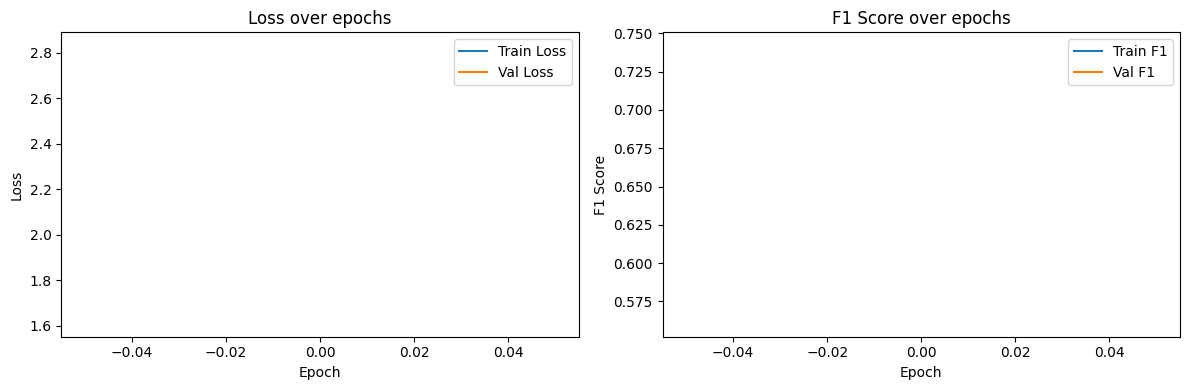

Project state saved to /kaggle/artifacts/baseline_finetune


In [ ]:
os.makedirs(f'{artifact_path}/baseline_finetune', exist_ok=True)
for param in baseline_cnn_model.parameters():
    param.requires_grad = False

for param in baseline_cnn_model.fc2.parameters():
    param.requires_grad = True

# Baseline CNN
baseline_cnn_model = BaselineCNN()
baseline_cnn_model.load_state_dict(torch.load(f"{artifact_path}/baseline/best_baseline_model.pth"))
baseline_cnn_model = baseline_cnn_model.to(device)

optimizer = optim.AdamW(baseline_cnn_model.fc2.parameters(), lr=0.0000001)
model_baselinecnn_finetune, history_baseline_finetune = finetune_model(baseline_cnn_model, optimizer, [train_gen_loader_orig, train_gen_loader_augm], val_gen_loader, 1, device, "baseline_finetune")

Starting training...

Epoch 1/1


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.37      0.54        59

    accuracy                           0.37        59
   macro avg       0.50      0.19      0.27        59
weighted avg       1.00      0.37      0.54        59

Confusion Matrix:
[[ 0  0]
 [37 22]]
Train - Loss: 0.9882, Acc: 0.5479, F1: 0.7079
Val - Loss: 1.3755, Acc: 0.3729, F1: 0.5432
Model saved with F1 score: 0.5432
Training complete!


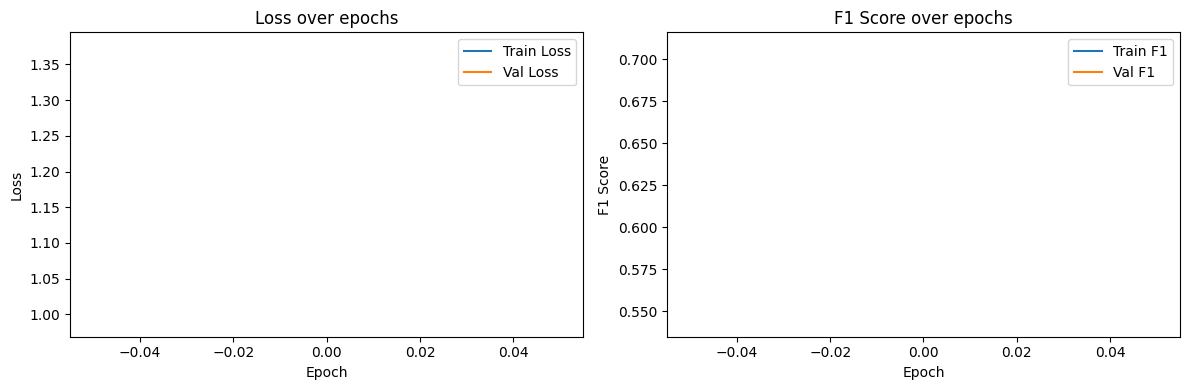

Project state saved to /kaggle/artifacts/resnet18_finetune


In [ ]:
# ResNet18
resnet_model = ResNet18()
resnet_model.load_state_dict(torch.load(f"{artifact_path}/resnet18/best_resnet18_model.pth"))
resnet_model = resnet_model.to(device)

os.makedirs(f'{artifact_path}/resnet18_finetune', exist_ok=True)
for param in resnet_model.parameters():
    param.requires_grad = False

for param in resnet_model.linear.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(resnet_model.linear.parameters(), lr=0.0000001)
model_resnet18_finetune, history_resnet18_finetune = finetune_model(resnet_model, optimizer, [train_gen_loader_orig, train_gen_loader_augm], val_gen_loader, 1, device, "resnet18_finetune")

Starting training...

Epoch 1/1


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.34      0.51        59

    accuracy                           0.34        59
   macro avg       0.50      0.17      0.25        59
weighted avg       1.00      0.34      0.51        59

Confusion Matrix:
[[ 0  0]
 [39 20]]
Train - Loss: 1.0269, Acc: 0.5553, F1: 0.7141
Val - Loss: 1.5233, Acc: 0.3390, F1: 0.5063
Model saved with F1 score: 0.5063
Training complete!


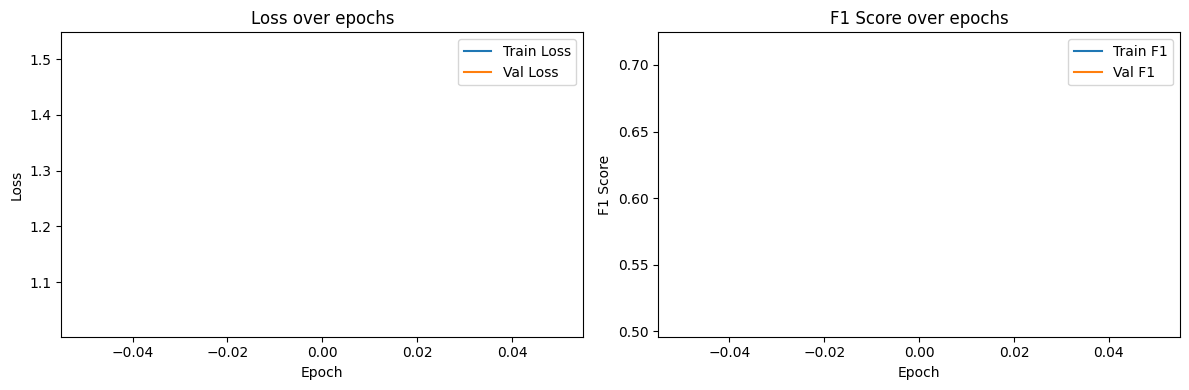

Project state saved to /kaggle/artifacts/cbamresnet18_finetune


In [ ]:
# CBAM-ResNet18
cbam_model = CBAMResNet18()
cbam_model.load_state_dict(torch.load(f"{artifact_path}/cbamresnet18/best_cbamresnet18_model.pth"))
cbam_model = cbam_model.to(device)

os.makedirs(f'{artifact_path}/cbamresnet18_finetune', exist_ok=True)
for param in cbam_model.parameters():
    param.requires_grad = False

for param in cbam_model.linear.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(cbam_model.linear.parameters(), lr=0.0000001)
model_cbamresnet18_finetune, history_cbamresnet18_finetune = finetune_model(cbam_model, optimizer, [train_gen_loader_orig, train_gen_loader_augm], val_gen_loader, 1, device, "cbamresnet18_finetune")

## Evaluation on All Datasets

To evaluate the effectiveness of our domain adaptation strategy, we re-assessed the adapted models on all test datasets previously used, including those containing images from various generative models. By comparing the post-adaptation performance with the original results, we aimed to determine whether fine-tuning on generated data improved the model’s ability to generalize across different domains. This comparative evaluation allows us to directly measure the impact of our approach on robustness, particularly in scenarios involving significant distributional shifts between the training and testing data.

In [ ]:
# Evaluate baseline_finetune CNN
baseline_finetune_cnn_model = BaselineCNN()
baseline_finetune_cnn_model.load_state_dict(torch.load(f"{eval_artifact_path}/baseline_finetune/best_baseline_finetune_model.pth"))
baseline_finetune_cnn_model.to(device)

# Evaluate baseline_finetune CNN
print("Evaluating baseline_finetune CNN...")
baseline_finetune_cnn_accuracy, baseline_finetune_cnn_f1, baseline_finetune_cnn_cm, baseline_finetune_cnn_test_artifact = evaluate_model(baseline_finetune_cnn_model, test_loader, device)
print(f"baseline_finetune CNN - Accuracy: {baseline_finetune_cnn_accuracy:.4f}, F1 Score: {baseline_finetune_cnn_f1:.4f}")
print("\n")
torch.save(baseline_finetune_cnn_test_artifact, f"{eval_artifact_path}/baseline_finetune/baseline_finetune_cnn_test_artifact.pth")

print("Evaluating baseline_finetune CNN on VAE...")
baseline_finetune_cnn_accuracy, baseline_finetune_cnn_f1, baseline_finetune_cnn_cm, baseline_finetune_cnn_test_artifact = evaluate_model(baseline_finetune_cnn_model, test_loader_vae, device)
print(f"baseline_finetune CNN on VAE - Accuracy: {baseline_finetune_cnn_accuracy:.4f}, F1 Score: {baseline_finetune_cnn_f1:.4f}")
print("\n")
torch.save(baseline_finetune_cnn_test_artifact, f"{eval_artifact_path}/baseline_finetune/baseline_finetune_cnn_test_vae_artifact.pth")

print("Evaluating baseline_finetune CNN on GAN Pretrained...")
baseline_finetune_cnn_accuracy, baseline_finetune_cnn_f1, baseline_finetune_cnn_cm, baseline_finetune_cnn_test_artifact = evaluate_model(baseline_finetune_cnn_model, test_loader_ganpt, device)
print(f"baseline_finetune CNN on GAN Pretrained - Accuracy: {baseline_finetune_cnn_accuracy:.4f}, F1 Score: {baseline_finetune_cnn_f1:.4f}")
print("\n")
torch.save(baseline_finetune_cnn_test_artifact, f"{eval_artifact_path}/baseline_finetune/baseline_finetune_cnn_test_ganpt_artifact.pth")

print("Evaluating baseline_finetune CNN on GAN Finetuned...")
baseline_finetune_cnn_accuracy, baseline_finetune_cnn_f1, baseline_finetune_cnn_cm, baseline_finetune_cnn_test_artifact = evaluate_model(baseline_finetune_cnn_model, test_loader_ganft, device)
print(f"baseline_finetune CNN on GAN Finetuned - Accuracy: {baseline_finetune_cnn_accuracy:.4f}, F1 Score: {baseline_finetune_cnn_f1:.4f}")
print("\n")
torch.save(baseline_finetune_cnn_test_artifact, f"{eval_artifact_path}/baseline_finetune/baseline_finetune_cnn_test_ganft_artifact.pth")

print("Evaluating baseline_finetune CNN on Diffusion Model...")
baseline_finetune_cnn_accuracy, baseline_finetune_cnn_f1, baseline_finetune_cnn_cm, baseline_finetune_cnn_test_artifact = evaluate_model(baseline_finetune_cnn_model, test_loader_dm, device)
print(f"baseline_finetune CNN on Diffusion Model - Accuracy: {baseline_finetune_cnn_accuracy:.4f}, F1 Score: {baseline_finetune_cnn_f1:.4f}")
print("\n")
torch.save(baseline_finetune_cnn_test_artifact, f"{eval_artifact_path}/baseline_finetune/baseline_finetune_cnn_test_dm_artifact.pth")

Evaluating baseline_finetune CNN...


Evaluating: 100%|██████████| 63/63 [01:19<00:00,  1.27s/it]


Confusion Matrix:
 [[2874 1123]
 [   2 3996]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.72      0.84      3997
           1       0.78      1.00      0.88      3998

    accuracy                           0.86      7995
   macro avg       0.89      0.86      0.86      7995
weighted avg       0.89      0.86      0.86      7995

baseline_finetune CNN - Accuracy: 0.8593, F1 Score: 0.8565


Evaluating baseline_finetune CNN on VAE...


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 29.21it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [495   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.01      0.02       500

    accuracy                           0.01       500
   macro avg       0.50      0.01      0.01       500
weighted avg       1.00      0.01      0.02       500

baseline_finetune CNN on VAE - Accuracy: 0.0100, F1 Score: 0.0198


Evaluating baseline_finetune CNN on GAN Pretrained...


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.39it/s]

Confusion Matrix:
 [[  0   0]
 [405  95]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.19      0.32       500

    accuracy                           0.19       500
   macro avg       0.50      0.10      0.16       500
weighted avg       1.00      0.19      0.32       500

baseline_finetune CNN on GAN Pretrained - Accuracy: 0.1900, F1 Score: 0.3193





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating baseline_finetune CNN on GAN Finetuned...


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 30.89it/s]

Confusion Matrix:
 [[  0   0]
 [435  65]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.13      0.23       500

    accuracy                           0.13       500
   macro avg       0.50      0.07      0.12       500
weighted avg       1.00      0.13      0.23       500

baseline_finetune CNN on GAN Finetuned - Accuracy: 0.1300, F1 Score: 0.2301





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating baseline_finetune CNN on Diffusion Model...


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 76.62it/s]

Confusion Matrix:
 [[ 0  0]
 [12 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.73      0.84        44

    accuracy                           0.73        44
   macro avg       0.50      0.36      0.42        44
weighted avg       1.00      0.73      0.84        44

baseline_finetune CNN on Diffusion Model - Accuracy: 0.7273, F1 Score: 0.8421





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluate ResNet_finetune
resnet18_finetune_model = ResNet18()
resnet18_finetune_model.load_state_dict(torch.load(f"{eval_artifact_path}/resnet18_finetune/best_resnet18_finetune_model.pth"))
resnet18_finetune_model.to(device)

# Evaluate resnet18_finetune
print("Evaluating resnet18_finetune...")
resnet18_finetune_accuracy, resnet18_finetune_f1, resnet18_finetune_cm, resnet18_finetune_test_artifact = evaluate_model(resnet18_finetune_model, test_loader, device)
print(f"resnet18_finetune - Accuracy: {resnet18_finetune_accuracy:.4f}, F1 Score: {resnet18_finetune_f1:.4f}")
print("\n")
torch.save(resnet18_finetune_test_artifact, f"{eval_artifact_path}/resnet18_finetune/resnet18_finetune_test_artifact.pth")

print("Evaluating resnet18_finetune on VAE...")
resnet18_finetune_accuracy, resnet18_finetune_f1, resnet18_finetune_cm, resnet18_finetune_test_artifact = evaluate_model(resnet18_finetune_model, test_loader_vae, device)
print(f"resnet18_finetune on VAE - Accuracy: {resnet18_finetune_accuracy:.4f}, F1 Score: {resnet18_finetune_f1:.4f}")
print("\n")
torch.save(resnet18_finetune_test_artifact, f"{eval_artifact_path}/resnet18_finetune/resnet18_finetune_test_vae_artifact.pth")

print("Evaluating resnet18_finetune on GAN Pretrained...")
resnet18_finetune_accuracy, resnet18_finetune_f1, resnet18_finetune_cm, resnet18_finetune_test_artifact = evaluate_model(resnet18_finetune_model, test_loader_ganpt, device)
print(f"resnet18_finetune on GAN Pretrained - Accuracy: {resnet18_finetune_accuracy:.4f}, F1 Score: {resnet18_finetune_f1:.4f}")
print("\n")
torch.save(resnet18_finetune_test_artifact, f"{eval_artifact_path}/resnet18_finetune/resnet18_finetune_test_ganpt_artifact.pth")

print("Evaluating resnet18_finetune on GAN Finetuned...")
resnet18_finetune_accuracy, resnet18_finetune_f1, resnet18_finetune_cm, resnet18_finetune_test_artifact = evaluate_model(resnet18_finetune_model, test_loader_ganft, device)
print(f"resnet18_finetune on GAN Finetuned - Accuracy: {resnet18_finetune_accuracy:.4f}, F1 Score: {resnet18_finetune_f1:.4f}")
print("\n")
torch.save(resnet18_finetune_test_artifact, f"{eval_artifact_path}/resnet18_finetune/resnet18_finetune_test_ganft_artifact.pth")

print("Evaluating resnet18_finetune on Diffusion Model...")
resnet18_finetune_accuracy, resnet18_finetune_f1, resnet18_finetune_cm, resnet18_finetune_test_artifact = evaluate_model(resnet18_finetune_model, test_loader_dm, device)
print(f"resnet18_finetune on Diffusion Model - Accuracy: {resnet18_finetune_accuracy:.4f}, F1 Score: {resnet18_finetune_f1:.4f}")
print("\n")
torch.save(resnet18_finetune_test_artifact, f"{eval_artifact_path}/resnet18_finetune/resnet18_finetune_test_dm_artifact.pth")

Evaluating resnet18_finetune...


Evaluating: 100%|██████████| 63/63 [01:16<00:00,  1.21s/it]


Confusion Matrix:
 [[1055 2942]
 [   0 3998]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.26      0.42      3997
           1       0.58      1.00      0.73      3998

    accuracy                           0.63      7995
   macro avg       0.79      0.63      0.57      7995
weighted avg       0.79      0.63      0.57      7995

resnet18_finetune - Accuracy: 0.6320, F1 Score: 0.5744


Evaluating resnet18_finetune on VAE...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [431  69]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.14      0.24       500

    accuracy                           0.14       500
   macro avg       0.50      0.07      0.12       500
weighted avg       1.00      0.14      0.24       500

resnet18_finetune on VAE - Accuracy: 0.1380, F1 Score: 0.2425


Evaluating resnet18_finetune on GAN Pretrained...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [188 312]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.62      0.77       500

    accuracy                           0.62       500
   macro avg       0.50      0.31      0.38       500
weighted avg       1.00      0.62      0.77       500

resnet18_finetune on GAN Pretrained - Accuracy: 0.6240, F1 Score: 0.7685


Evaluating resnet18_finetune on GAN Finetuned...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [259 241]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.48      0.65       500

    accuracy                           0.48       500
   macro avg       0.50      0.24      0.33       500
weighted avg       1.00      0.48      0.65       500

resnet18_finetune on GAN Finetuned - Accuracy: 0.4820, F1 Score: 0.6505


Evaluating resnet18_finetune on Diffusion Model...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[ 0  0]
 [ 1 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.98      0.99        44

    accuracy                           0.98        44
   macro avg       0.50      0.49      0.49        44
weighted avg       1.00      0.98      0.99        44

resnet18_finetune on Diffusion Model - Accuracy: 0.9773, F1 Score: 0.9885




In [ ]:
# CBAM-ResNet18
cbamresnet18_finetune_model = CBAMResNet18()
cbamresnet18_finetune_model.load_state_dict(torch.load(f"{eval_artifact_path}/cbamresnet18_finetune/best_cbamresnet18_finetune_model.pth"))
cbamresnet18_finetune_model = cbamresnet18_finetune_model.to(device)

# Evaluate cbamresnet18_finetune
print("Evaluating cbamresnet18_finetune...")
cbamresnet18_finetune_accuracy, cbamresnet18_finetune_f1, cbamresnet18_finetune_cm, cbamresnet18_finetune_test_artifact = evaluate_model(cbamresnet18_finetune_model, test_loader, device)
print(f"cbamresnet18_finetune - Accuracy: {cbamresnet18_finetune_accuracy:.4f}, F1 Score: {cbamresnet18_finetune_f1:.4f}")
print("\n")
torch.save(cbamresnet18_finetune_test_artifact, f"{eval_artifact_path}/cbamresnet18_finetune/cbamresnet18_finetune_test_artifact.pth")

print("Evaluating cbamresnet18_finetune on VAE...")
cbamresnet18_finetune_accuracy, cbamresnet18_finetune_f1, cbamresnet18_finetune_cm, cbamresnet18_finetune_test_artifact = evaluate_model(cbamresnet18_finetune_model, test_loader_vae, device)
print(f"cbamresnet18_finetune on VAE - Accuracy: {cbamresnet18_finetune_accuracy:.4f}, F1 Score: {cbamresnet18_finetune_f1:.4f}")
print("\n")
torch.save(cbamresnet18_finetune_test_artifact, f"{eval_artifact_path}/cbamresnet18_finetune/cbamresnet18_finetune_test_vae_artifact.pth")

print("Evaluating cbamresnet18_finetune on GAN Pretrained...")
cbamresnet18_finetune_accuracy, cbamresnet18_finetune_f1, cbamresnet18_finetune_cm, cbamresnet18_finetune_test_artifact = evaluate_model(cbamresnet18_finetune_model, test_loader_ganpt, device)
print(f"cbamresnet18_finetune on GAN Pretrained - Accuracy: {cbamresnet18_finetune_accuracy:.4f}, F1 Score: {cbamresnet18_finetune_f1:.4f}")
print("\n")
torch.save(cbamresnet18_finetune_test_artifact, f"{eval_artifact_path}/cbamresnet18_finetune/cbamresnet18_finetune_test_ganpt_artifact.pth")

print("Evaluating cbamresnet18_finetune on GAN Finetuned...")
cbamresnet18_finetune_accuracy, cbamresnet18_finetune_f1, cbamresnet18_finetune_cm, cbamresnet18_finetune_test_artifact = evaluate_model(cbamresnet18_finetune_model, test_loader_ganft, device)
print(f"cbamresnet18_finetune on GAN Finetuned - Accuracy: {cbamresnet18_finetune_accuracy:.4f}, F1 Score: {cbamresnet18_finetune_f1:.4f}")
print("\n")
torch.save(cbamresnet18_finetune_test_artifact, f"{eval_artifact_path}/cbamresnet18_finetune/cbamresnet18_finetune_test_ganft_artifact.pth")

print("Evaluating cbamresnet18_finetune on Diffusion Model...")
cbamresnet18_finetune_accuracy, cbamresnet18_finetune_f1, cbamresnet18_finetune_cm, cbamresnet18_finetune_test_artifact = evaluate_model(cbamresnet18_finetune_model, test_loader_dm, device)
print(f"cbamresnet18_finetune on Diffusion Model - Accuracy: {cbamresnet18_finetune_accuracy:.4f}, F1 Score: {cbamresnet18_finetune_f1:.4f}")
print("\n")
torch.save(cbamresnet18_finetune_test_artifact, f"{eval_artifact_path}/cbamresnet18_finetune/cbamresnet18_finetune_test_dm_artifact.pth")

Evaluating cbamresnet18_finetune...


Evaluating: 100%|██████████| 63/63 [01:22<00:00,  1.31s/it]


Confusion Matrix:
 [[ 494 3503]
 [   0 3998]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22      3997
           1       0.53      1.00      0.70      3998

    accuracy                           0.56      7995
   macro avg       0.77      0.56      0.46      7995
weighted avg       0.77      0.56      0.46      7995

cbamresnet18_finetune - Accuracy: 0.5619, F1 Score: 0.4577


Evaluating cbamresnet18_finetune on VAE...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [453  47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.09      0.17       500

    accuracy                           0.09       500
   macro avg       0.50      0.05      0.09       500
weighted avg       1.00      0.09      0.17       500

cbamresnet18_finetune on VAE - Accuracy: 0.0940, F1 Score: 0.1718


Evaluating cbamresnet18_finetune on GAN Pretrained...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [162 338]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.68      0.81       500

    accuracy                           0.68       500
   macro avg       0.50      0.34      0.40       500
weighted avg       1.00      0.68      0.81       500

cbamresnet18_finetune on GAN Pretrained - Accuracy: 0.6760, F1 Score: 0.8067


Evaluating cbamresnet18_finetune on GAN Finetuned...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [211 289]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.58      0.73       500

    accuracy                           0.58       500
   macro avg       0.50      0.29      0.37       500
weighted avg       1.00      0.58      0.73       500

cbamresnet18_finetune on GAN Finetuned - Accuracy: 0.5780, F1 Score: 0.7326


Evaluating cbamresnet18_finetune on Diffusion Model...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[ 0  0]
 [ 1 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.98      0.99        44

    accuracy                           0.98        44
   macro avg       0.50      0.49      0.49        44
weighted avg       1.00      0.98      0.99        44

cbamresnet18_finetune on Diffusion Model - Accuracy: 0.9773, F1 Score: 0.9885




Below is a comparison of results between our original models with our domain-adapted models.

Previous Result:

| Model |Test F1 Score | VAE F1 Score | GAN-PT F1 Score | GAN-FT F1 Score | DM F1 Score |
| --------------------- | ------------ | --------------- | --------------- | -------- | --- |
| Two-layer Vanilla CNN | 0.9755 | 0 | 0.008 | 0.004 | 0.4 |
| ResNet18            | 0.9814 | 0 | 0.0354 | 0.0198 | 0.4561 |
| CBAM ResNet18        | 0.9814 | 0 | 0.008 | 0.004 | 0.4286 |

New Result:

| Model |Test F1 Score | VAE F1 Score | GAN-PT F1 Score | GAN-FT F1 Score | DM F1 Score |
| --------------------- | ------------ | --------------- | --------------- | -------- | --- |
| Two-layer Vanilla CNN | 0.8565 | 0.0198 | 0.3193 | 0.2301 | 0.8421 |
| ResNet18              | 0.5744 | 0.2425 | 0.7685 | 0.6505 | 0.9885 |
| CBAM ResNet18         | 0.4577 | 0.1718 | 0.8067 | 0.7326 | 0.9885 |

From the table above, we observe three clear trends:

- None of the models perform well on the VAE-generated images, indicating a consistent weakness across architectures.

- For the CNN model, the F1 scores remain relatively stable across datasets, with a slight decrease on the original test set and a modest improvement on the GAN dataset. However, it performs particularly well on the Diffusion Model images.

- In contrast, the two ResNet models exhibit more noticeable changes, achieving better performance on the GAN and diffusion datasets but with a trade-off in reduced accuracy on the original test set.

In conclusion, the results demonstrate the importance of domain adaptation in improving model generalization across different generative domains. While none of the models performed well on the VAE-generated images, the domain adaptation strategy showed varying degrees of success across architectures. The CNN model showed limited improvement, especially excelling in Diffusion Model detection, suggesting that it may require more extensive adaptation for better performance across diverse datasets. In contrast, the ResNet models displayed more significant gains on the GAN and Diffusion datasets, although this came at the cost of reduced performance on the original test set. These findings indicate that our domain adaptation strategy, involving fine-tuning only the classifier head, can enhance performance on specific generators but may also lead to some trade-offs. This highlights the need for further exploration into more advanced adaptation techniques that could minimize these performance shifts while maximizing robustness across multiple domains.

# Full Re-training on Combined Dataset

Finally, to ascertain that it is possible to create a model that can detect different kinds of AI-generated images, a full re-training is done using a dataset that is a combination of the Kaggle's dataset and the self-generated images. The generated images are subjected to the same data pre-processing as the Kaggle counterparts, and the ratio of the images used for training/validation/testing is kept constant at 80%-10%-10%.

Due to time and resource limitation, the full re-training was only done for 4 epochs and excludes the baseline CNN model. The code is provided for all 3 models at full 10 epochs.

In [ ]:
df_train_combined = pd.concat([df_train, df_train_vae, df_train_ganpt, df_train_ganft, df_train_dm])
df_val_combined = pd.concat([df_val, df_val_vae, df_val_ganpt, df_val_ganft, df_val_dm])

# Sample for quick check/testing; to train the model fully, set this to False
SHOULD_SAMPLE = True

if SHOULD_SAMPLE:
    sample_size = 0.99 # change as needed
    df_train_combined_subs, _ = train_test_split(df_train_combined, test_size=sample_size, random_state=42, stratify=df_train_combined['label'])
    df_val_combined_subs, _ = train_test_split(df_val_combined, test_size=sample_size, random_state=42, stratify=df_val_combined['label'])
else:
    df_train_combined_subs = df_train_combined
    df_val_combined_subs = df_val_combined

train_orig_combined_dataset = CustomImageDataset(df_train_combined_subs, augmented=False)  # Original training dataset
train_augm_combined_dataset = CustomImageDataset(df_train_combined_subs, augmented=True)  # Original training dataset
val_combined_dataset = CustomImageDataset(df_val_combined_subs, augmented=False)  # No augmentation for validation

# Create DataLoaders
train_orig_combined_loader = DataLoader(train_orig_combined_dataset, batch_size=BATCH_SIZE // 2, shuffle=True, num_workers=0)
train_augm_combined_loader = DataLoader(train_augm_combined_dataset, batch_size=BATCH_SIZE // 2, shuffle=True, num_workers=0)
val_combined_loader = DataLoader(val_combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Starting training...

Epoch 1/10


Validating: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.58      1.00      0.73        55

    accuracy                           0.58        95
   macro avg       0.29      0.50      0.37        95
weighted avg       0.34      0.58      0.42        95

Confusion Matrix:
[[ 0 40]
 [ 0 55]]
Train - Loss: 1.7886, Acc: 0.6710, F1: 0.6680
Val - Loss: 5.5936, Acc: 0.5789, F1: 0.4246
Model saved with F1 score: 0.4246

Epoch 2/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.57      0.98      0.72        55

    accuracy                           0.57        95
   macro avg       0.29      0.49      0.36        95
weighted avg       0.33      0.57      0.42        95

Confusion Matrix:
[[ 0 40]
 [ 1 54]]
Train - Loss: 0.6885, Acc: 0.7379, F1: 0.7379
Val - Loss: 6.8794, Acc: 0.5684, F1: 0.4196

Epoch 3/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.23      0.30        40
           1       0.58      0.78      0.67        55

    accuracy                           0.55        95
   macro avg       0.50      0.50      0.48        95
weighted avg       0.52      0.55      0.51        95

Confusion Matrix:
[[ 9 31]
 [12 43]]
Train - Loss: 0.4950, Acc: 0.7805, F1: 0.7814
Val - Loss: 4.4339, Acc: 0.5474, F1: 0.5102
Model saved with F1 score: 0.5102

Epoch 4/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.78      0.64        40
           1       0.76      0.53      0.62        55

    accuracy                           0.63        95
   macro avg       0.65      0.65      0.63        95
weighted avg       0.67      0.63      0.63        95

Confusion Matrix:
[[31  9]
 [26 29]]
Train - Loss: 0.4225, Acc: 0.8087, F1: 0.8087
Val - Loss: 1.1321, Acc: 0.6316, F1: 0.6302
Model saved with F1 score: 0.6302

Epoch 5/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        40
           1       0.89      0.73      0.80        55

    accuracy                           0.79        95
   macro avg       0.79      0.80      0.79        95
weighted avg       0.81      0.79      0.79        95

Confusion Matrix:
[[35  5]
 [15 40]]
Train - Loss: 0.3595, Acc: 0.8414, F1: 0.8422
Val - Loss: 0.5849, Acc: 0.7895, F1: 0.7906
Model saved with F1 score: 0.7906

Epoch 6/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        40
           1       0.92      0.80      0.85        55

    accuracy                           0.84        95
   macro avg       0.84      0.85      0.84        95
weighted avg       0.85      0.84      0.84        95

Confusion Matrix:
[[36  4]
 [11 44]]
Train - Loss: 0.3262, Acc: 0.8637, F1: 0.8640
Val - Loss: 0.4648, Acc: 0.8421, F1: 0.8431
Model saved with F1 score: 0.8431

Epoch 7/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81        40
           1       0.90      0.80      0.85        55

    accuracy                           0.83        95
   macro avg       0.83      0.84      0.83        95
weighted avg       0.84      0.83      0.83        95

Confusion Matrix:
[[35  5]
 [11 44]]
Train - Loss: 0.3103, Acc: 0.8729, F1: 0.8733
Val - Loss: 0.4279, Acc: 0.8316, F1: 0.8326

Epoch 8/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        40
           1       0.88      0.78      0.83        55

    accuracy                           0.81        95
   macro avg       0.81      0.82      0.81        95
weighted avg       0.82      0.81      0.81        95

Confusion Matrix:
[[34  6]
 [12 43]]
Train - Loss: 0.2894, Acc: 0.8834, F1: 0.8835
Val - Loss: 0.5951, Acc: 0.8105, F1: 0.8117

Epoch 9/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        40
           1       0.80      0.82      0.81        55

    accuracy                           0.78        95
   macro avg       0.77      0.77      0.77        95
weighted avg       0.78      0.78      0.78        95

Confusion Matrix:
[[29 11]
 [10 45]]
Train - Loss: 0.3014, Acc: 0.8650, F1: 0.8654
Val - Loss: 0.5418, Acc: 0.7789, F1: 0.7785

Epoch 10/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        40
           1       0.84      0.84      0.84        55

    accuracy                           0.81        95
   macro avg       0.81      0.81      0.81        95
weighted avg       0.81      0.81      0.81        95

Confusion Matrix:
[[31  9]
 [ 9 46]]
Train - Loss: 0.2771, Acc: 0.8781, F1: 0.8786
Val - Loss: 0.5441, Acc: 0.8105, F1: 0.8105
Training complete!


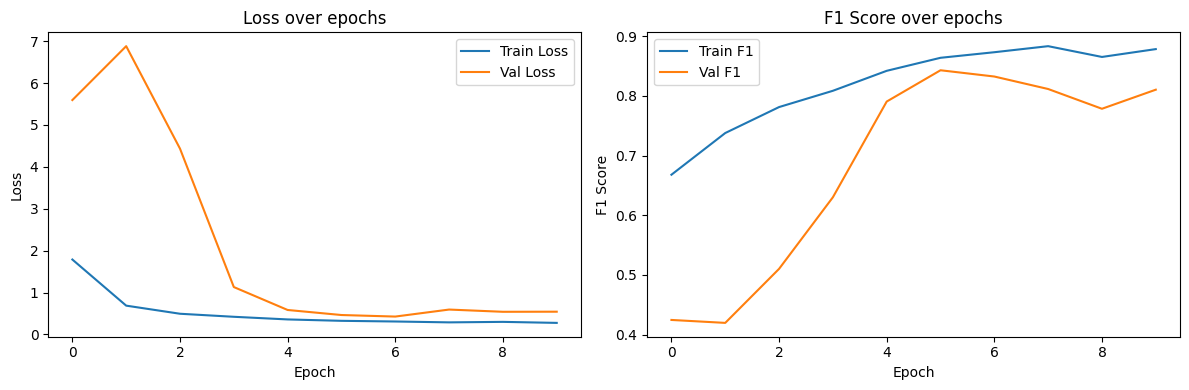

Project state saved to /kaggle/artifacts/baseline_combined


In [ ]:
# Baseline CNN
os.makedirs(f'{artifact_path}/baseline_combined', exist_ok=True)
model_baselinecnn, history_baseline = train_model(BaselineCNN(), [train_orig_combined_loader, train_augm_combined_loader], val_combined_loader, NUM_EPOCHS, device, "baseline_combined")

Starting training...

Epoch 1/10


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.58      1.00      0.73        55

    accuracy                           0.58        95
   macro avg       0.29      0.50      0.37        95
weighted avg       0.34      0.58      0.42        95

Confusion Matrix:
[[ 0 40]
 [ 0 55]]
Train - Loss: 0.7308, Acc: 0.6566, F1: 0.6587
Val - Loss: 30.1789, Acc: 0.5789, F1: 0.4246
Model saved with F1 score: 0.4246

Epoch 2/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.58      1.00      0.73        55

    accuracy                           0.58        95
   macro avg       0.29      0.50      0.37        95
weighted avg       0.34      0.58      0.42        95

Confusion Matrix:
[[ 0 40]
 [ 0 55]]
Train - Loss: 0.5874, Acc: 0.6959, F1: 0.6979
Val - Loss: 7.7752, Acc: 0.5789, F1: 0.4246

Epoch 3/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.17      0.28        40
           1       0.61      0.95      0.74        55

    accuracy                           0.62        95
   macro avg       0.66      0.56      0.51        95
weighted avg       0.65      0.62      0.55        95

Confusion Matrix:
[[ 7 33]
 [ 3 52]]
Train - Loss: 0.5261, Acc: 0.7431, F1: 0.7438
Val - Loss: 0.9532, Acc: 0.6211, F1: 0.5480
Model saved with F1 score: 0.5480

Epoch 4/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        40
           1       0.63      0.78      0.70        55

    accuracy                           0.61        95
   macro avg       0.59      0.58      0.57        95
weighted avg       0.60      0.61      0.59        95

Confusion Matrix:
[[15 25]
 [12 43]]
Train - Loss: 0.5125, Acc: 0.7392, F1: 0.7405
Val - Loss: 0.6331, Acc: 0.6105, F1: 0.5933
Model saved with F1 score: 0.5933

Epoch 5/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        40
           1       0.73      0.75      0.74        55

    accuracy                           0.69        95
   macro avg       0.69      0.69      0.69        95
weighted avg       0.69      0.69      0.69        95

Confusion Matrix:
[[25 15]
 [14 41]]
Train - Loss: 0.4881, Acc: 0.7687, F1: 0.7696
Val - Loss: 0.6572, Acc: 0.6947, F1: 0.6942
Model saved with F1 score: 0.6942

Epoch 6/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.67        40
           1       0.75      0.78      0.77        55

    accuracy                           0.73        95
   macro avg       0.72      0.72      0.72        95
weighted avg       0.72      0.73      0.73        95

Confusion Matrix:
[[26 14]
 [12 43]]
Train - Loss: 0.4714, Acc: 0.7582, F1: 0.7587
Val - Loss: 0.4656, Acc: 0.7263, F1: 0.7253
Model saved with F1 score: 0.7253

Epoch 7/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        40
           1       0.81      0.64      0.71        55

    accuracy                           0.71        95
   macro avg       0.71      0.72      0.70        95
weighted avg       0.73      0.71      0.71        95

Confusion Matrix:
[[32  8]
 [20 35]]
Train - Loss: 0.4474, Acc: 0.7811, F1: 0.7815
Val - Loss: 0.4867, Acc: 0.7053, F1: 0.7064

Epoch 8/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        40
           1       0.77      0.91      0.83        55

    accuracy                           0.79        95
   macro avg       0.80      0.77      0.77        95
weighted avg       0.80      0.79      0.78        95

Confusion Matrix:
[[25 15]
 [ 5 50]]
Train - Loss: 0.4662, Acc: 0.7851, F1: 0.7848
Val - Loss: 0.4157, Acc: 0.7895, F1: 0.7832
Model saved with F1 score: 0.7832

Epoch 9/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.07      0.14        40
           1       0.60      1.00      0.75        55

    accuracy                           0.61        95
   macro avg       0.80      0.54      0.44        95
weighted avg       0.77      0.61      0.49        95

Confusion Matrix:
[[ 3 37]
 [ 0 55]]
Train - Loss: 0.4388, Acc: 0.7877, F1: 0.7879
Val - Loss: 1.6143, Acc: 0.6105, F1: 0.4920

Epoch 10/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        40
           1       0.82      0.82      0.82        55

    accuracy                           0.79        95
   macro avg       0.78      0.78      0.78        95
weighted avg       0.79      0.79      0.79        95

Confusion Matrix:
[[30 10]
 [10 45]]
Train - Loss: 0.4469, Acc: 0.7844, F1: 0.7840
Val - Loss: 0.5094, Acc: 0.7895, F1: 0.7895
Model saved with F1 score: 0.7895
Training complete!


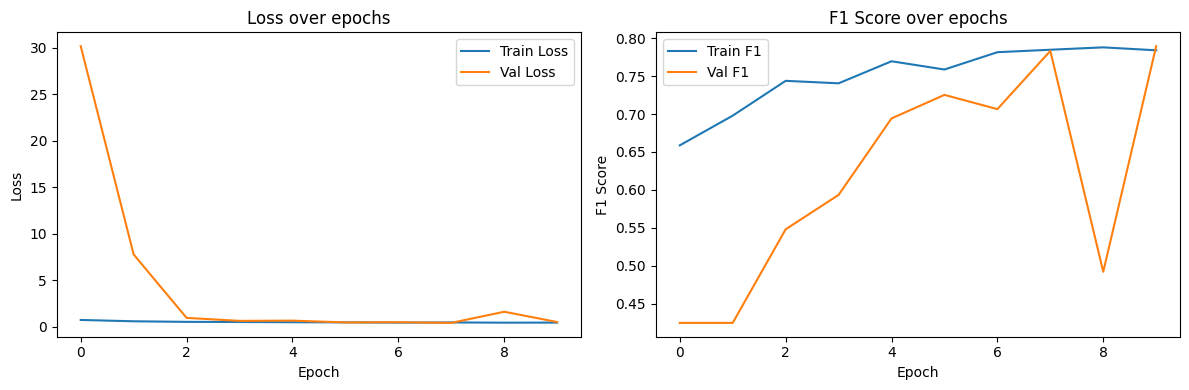

Project state saved to /kaggle/artifacts/resnet18_combined


In [ ]:
# ResNet18
os.makedirs(f'{artifact_path}/resnet18_combined', exist_ok=True)
model_resnet18, history_resnet18 = train_model(ResNet18(), [train_orig_combined_loader, train_augm_combined_loader], val_combined_loader, NUM_EPOCHS, device, 'resnet18_combined')

Starting training...

Epoch 1/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.58      1.00      0.73        55

    accuracy                           0.58        95
   macro avg       0.29      0.50      0.37        95
weighted avg       0.34      0.58      0.42        95

Confusion Matrix:
[[ 0 40]
 [ 0 55]]
Train - Loss: 0.8721, Acc: 0.6081, F1: 0.6107
Val - Loss: 19.6211, Acc: 0.5789, F1: 0.4246
Model saved with F1 score: 0.4246

Epoch 2/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.10      0.16        40
           1       0.58      0.91      0.71        55

    accuracy                           0.57        95
   macro avg       0.51      0.50      0.44        95
weighted avg       0.52      0.57      0.48        95

Confusion Matrix:
[[ 4 36]
 [ 5 50]]
Train - Loss: 0.5593, Acc: 0.7353, F1: 0.7358
Val - Loss: 2.3794, Acc: 0.5684, F1: 0.4793
Model saved with F1 score: 0.4793

Epoch 3/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.10      0.16        40
           1       0.58      0.89      0.70        55

    accuracy                           0.56        95
   macro avg       0.49      0.50      0.43        95
weighted avg       0.50      0.56      0.47        95

Confusion Matrix:
[[ 4 36]
 [ 6 49]]
Train - Loss: 0.5193, Acc: 0.7543, F1: 0.7545
Val - Loss: 1.0512, Acc: 0.5579, F1: 0.4726

Epoch 4/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        40
           1       0.73      0.78      0.75        55

    accuracy                           0.71        95
   macro avg       0.70      0.69      0.69        95
weighted avg       0.70      0.71      0.70        95

Confusion Matrix:
[[24 16]
 [12 43]]
Train - Loss: 0.4765, Acc: 0.7687, F1: 0.7694
Val - Loss: 0.5661, Acc: 0.7053, F1: 0.7027
Model saved with F1 score: 0.7027

Epoch 5/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.65      0.73        40
           1       0.78      0.91      0.84        55

    accuracy                           0.80        95
   macro avg       0.81      0.78      0.79        95
weighted avg       0.81      0.80      0.79        95

Confusion Matrix:
[[26 14]
 [ 5 50]]
Train - Loss: 0.4542, Acc: 0.7851, F1: 0.7845
Val - Loss: 0.4616, Acc: 0.8000, F1: 0.7949
Model saved with F1 score: 0.7949

Epoch 6/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        40
           1       0.79      0.84      0.81        55

    accuracy                           0.78        95
   macro avg       0.77      0.77      0.77        95
weighted avg       0.78      0.78      0.78        95

Confusion Matrix:
[[28 12]
 [ 9 46]]
Train - Loss: 0.4536, Acc: 0.7844, F1: 0.7855
Val - Loss: 0.4714, Acc: 0.7789, F1: 0.7776

Epoch 7/10


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.85      0.75        40
           1       0.86      0.69      0.77        55

    accuracy                           0.76        95
   macro avg       0.77      0.77      0.76        95
weighted avg       0.78      0.76      0.76        95

Confusion Matrix:
[[34  6]
 [17 38]]
Train - Loss: 0.4533, Acc: 0.7936, F1: 0.7937
Val - Loss: 0.5485, Acc: 0.7579, F1: 0.7591

Epoch 8/10


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.88      0.71        40
           1       0.86      0.58      0.70        55

    accuracy                           0.71        95
   macro avg       0.73      0.73      0.70        95
weighted avg       0.75      0.71      0.70        95

Confusion Matrix:
[[35  5]
 [23 32]]
Train - Loss: 0.4084, Acc: 0.8028, F1: 0.8028
Val - Loss: 0.5833, Acc: 0.7053, F1: 0.7035

Epoch 9/10


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69        40
           1       0.77      0.80      0.79        55

    accuracy                           0.75        95
   macro avg       0.74      0.74      0.74        95
weighted avg       0.75      0.75      0.75        95

Confusion Matrix:
[[27 13]
 [11 44]]
Train - Loss: 0.4090, Acc: 0.8139, F1: 0.8146
Val - Loss: 0.5203, Acc: 0.7474, F1: 0.7464

Epoch 10/10


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]



Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.60      0.72        40
           1       0.76      0.95      0.85        55

    accuracy                           0.80        95
   macro avg       0.83      0.77      0.78        95
weighted avg       0.82      0.80      0.79        95

Confusion Matrix:
[[24 16]
 [ 3 52]]
Train - Loss: 0.4097, Acc: 0.8159, F1: 0.8161
Val - Loss: 0.5210, Acc: 0.8000, F1: 0.7912
Training complete!


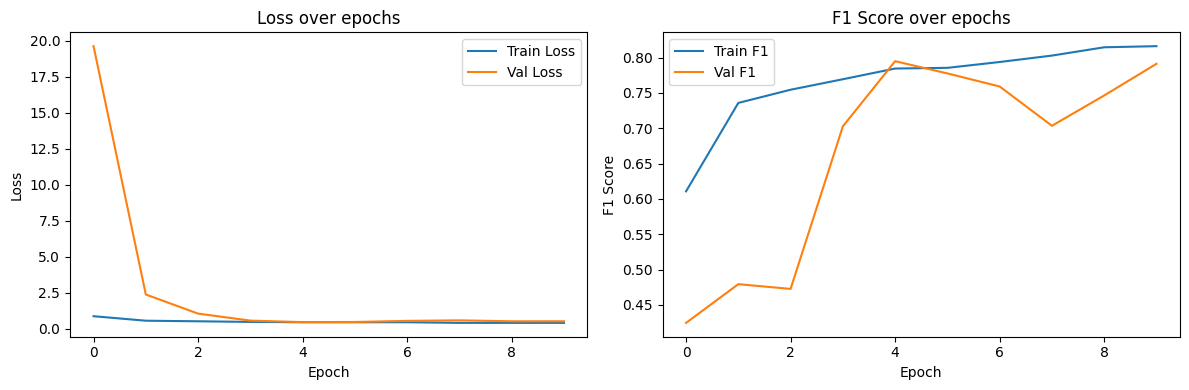

Project state saved to /kaggle/artifacts/cbamresnet18_combined


In [ ]:
# CBAM-ResNet18
os.makedirs(f'{artifact_path}/cbamresnet18_combined', exist_ok=True)
model_cbamresnet18, history_cbamresnet18 = train_model(CBAMResNet18(), [train_orig_combined_loader, train_augm_combined_loader], val_combined_loader, NUM_EPOCHS, device, 'cbamresnet18_combined')

## Evaluation on All Datasets

In [ ]:
# ResNet18
resnet18_combined_model = ResNet18()
resnet18_combined_model.load_state_dict(torch.load(f"{eval_artifact_path}/resnet18_combined/best_resnet18_model_combined_ep4.pth"))
resnet18_combined_model = resnet18_combined_model.to(device)

# Evaluate resnet18_combined
print("Evaluating resnet18_combined...")
resnet18_combined_accuracy, resnet18_combined_f1, resnet18_combined_cm, resnet18_combined_test_artifact = evaluate_model(resnet18_combined_model, test_loader, device)
print(f"resnet18_combined - Accuracy: {resnet18_combined_accuracy:.4f}, F1 Score: {resnet18_combined_f1:.4f}")
print("\n")
torch.save(resnet18_combined_test_artifact, f"{eval_artifact_path}/resnet18_combined/resnet18_combined_test_artifact.pth")

print("Evaluating resnet18_combined on VAE...")
resnet18_combined_accuracy, resnet18_combined_f1, resnet18_combined_cm, resnet18_combined_test_artifact = evaluate_model(resnet18_combined_model, test_loader_vae, device)
print(f"resnet18_combined on VAE - Accuracy: {resnet18_combined_accuracy:.4f}, F1 Score: {resnet18_combined_f1:.4f}")
print("\n")
torch.save(resnet18_combined_test_artifact, f"{eval_artifact_path}/resnet18_combined/resnet18_combined_test_vae_artifact.pth")

print("Evaluating resnet18_combined on GAN Pretrained...")
resnet18_combined_accuracy, resnet18_combined_f1, resnet18_combined_cm, resnet18_combined_test_artifact = evaluate_model(resnet18_combined_model, test_loader_ganpt, device)
print(f"resnet18_combined on GAN Pretrained - Accuracy: {resnet18_combined_accuracy:.4f}, F1 Score: {resnet18_combined_f1:.4f}")
print("\n")
torch.save(resnet18_combined_test_artifact, f"{eval_artifact_path}/resnet18_combined/resnet18_combined_test_ganpt_artifact.pth")

print("Evaluating resnet18_combined on GAN Finetuned...")
resnet18_combined_accuracy, resnet18_combined_f1, resnet18_combined_cm, resnet18_combined_test_artifact = evaluate_model(resnet18_combined_model, test_loader_ganft, device)
print(f"resnet18_combined on GAN Finetuned - Accuracy: {resnet18_combined_accuracy:.4f}, F1 Score: {resnet18_combined_f1:.4f}")
print("\n")
torch.save(resnet18_combined_test_artifact, f"{eval_artifact_path}/resnet18_combined/resnet18_combined_test_ganft_artifact.pth")

print("Evaluating resnet18_combined on Diffusion Model...")
resnet18_combined_accuracy, resnet18_combined_f1, resnet18_combined_cm, resnet18_combined_test_artifact = evaluate_model(resnet18_combined_model, test_loader_dm, device)
print(f"resnet18_combined on Diffusion Model - Accuracy: {resnet18_combined_accuracy:.4f}, F1 Score: {resnet18_combined_f1:.4f}")
print("\n")
torch.save(resnet18_combined_test_artifact, f"{eval_artifact_path}/resnet18_combined/resnet18_combined_test_dm_artifact.pth")

Evaluating resnet18_combined...


Evaluating: 100%|██████████| 63/63 [01:26<00:00,  1.37s/it]


Confusion Matrix:
 [[3840  157]
 [  98 3900]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      3997
           1       0.96      0.98      0.97      3998

    accuracy                           0.97      7995
   macro avg       0.97      0.97      0.97      7995
weighted avg       0.97      0.97      0.97      7995

resnet18_combined - Accuracy: 0.9681, F1 Score: 0.9681


Evaluating resnet18_combined on VAE...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [  3 497]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      1.00       500

    accuracy                           0.99       500
   macro avg       0.50      0.50      0.50       500
weighted avg       1.00      0.99      1.00       500

resnet18_combined on VAE - Accuracy: 0.9940, F1 Score: 0.9970


Evaluating resnet18_combined on GAN Pretrained...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [ 26 474]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97       500

    accuracy                           0.95       500
   macro avg       0.50      0.47      0.49       500
weighted avg       1.00      0.95      0.97       500

resnet18_combined on GAN Pretrained - Accuracy: 0.9480, F1 Score: 0.9733


Evaluating resnet18_combined on GAN Finetuned...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [ 33 467]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.93      0.97       500

    accuracy                           0.93       500
   macro avg       0.50      0.47      0.48       500
weighted avg       1.00      0.93      0.97       500

resnet18_combined on GAN Finetuned - Accuracy: 0.9340, F1 Score: 0.9659


Evaluating resnet18_combined on Diffusion Model...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

Confusion Matrix:
 [[ 0  0]
 [22 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67        44

    accuracy                           0.50        44
   macro avg       0.50      0.25      0.33        44
weighted avg       1.00      0.50      0.67        44

resnet18_combined on Diffusion Model - Accuracy: 0.5000, F1 Score: 0.6667





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# CBAM-ResNet18
cbamresnet18_combined_model = CBAMResNet18()
cbamresnet18_combined_model.load_state_dict(torch.load(f"{eval_artifact_path}/cbamresnet18_combined/best_cbamresnet18_model_combined_ep4.pth"))
cbamresnet18_combined_model = cbamresnet18_combined_model.to(device)

# Evaluate cbamresnet18_combined
print("Evaluating cbamresnet18_combined...")
cbamresnet18_combined_accuracy, cbamresnet18_combined_f1, cbamresnet18_combined_cm, cbamresnet18_combined_test_artifact = evaluate_model(cbamresnet18_combined_model, test_loader, device)
print(f"cbamresnet18_combined - Accuracy: {cbamresnet18_combined_accuracy:.4f}, F1 Score: {cbamresnet18_combined_f1:.4f}")
print("\n")
torch.save(cbamresnet18_combined_test_artifact, f"{eval_artifact_path}/cbamresnet18_combined/cbamresnet18_combined_test_artifact.pth")

print("Evaluating cbamresnet18_combined on VAE...")
cbamresnet18_combined_accuracy, cbamresnet18_combined_f1, cbamresnet18_combined_cm, cbamresnet18_combined_test_artifact = evaluate_model(cbamresnet18_combined_model, test_loader_vae, device)
print(f"cbamresnet18_combined on VAE - Accuracy: {cbamresnet18_combined_accuracy:.4f}, F1 Score: {cbamresnet18_combined_f1:.4f}")
print("\n")
torch.save(cbamresnet18_combined_test_artifact, f"{eval_artifact_path}/cbamresnet18_combined/cbamresnet18_combined_test_vae_artifact.pth")

print("Evaluating cbamresnet18_combined on GAN Pretrained...")
cbamresnet18_combined_accuracy, cbamresnet18_combined_f1, cbamresnet18_combined_cm, cbamresnet18_combined_test_artifact = evaluate_model(cbamresnet18_combined_model, test_loader_ganpt, device)
print(f"cbamresnet18_combined on GAN Pretrained - Accuracy: {cbamresnet18_combined_accuracy:.4f}, F1 Score: {cbamresnet18_combined_f1:.4f}")
print("\n")
torch.save(cbamresnet18_combined_test_artifact, f"{eval_artifact_path}/cbamresnet18_combined/cbamresnet18_combined_test_ganpt_artifact.pth")

print("Evaluating cbamresnet18_combined on GAN Finetuned...")
cbamresnet18_combined_accuracy, cbamresnet18_combined_f1, cbamresnet18_combined_cm, cbamresnet18_combined_test_artifact = evaluate_model(cbamresnet18_combined_model, test_loader_ganft, device)
print(f"cbamresnet18_combined on GAN Finetuned - Accuracy: {cbamresnet18_combined_accuracy:.4f}, F1 Score: {cbamresnet18_combined_f1:.4f}")
print("\n")
torch.save(cbamresnet18_combined_test_artifact, f"{eval_artifact_path}/cbamresnet18_combined/cbamresnet18_combined_test_ganft_artifact.pth")

print("Evaluating cbamresnet18_combined on Diffusion Model...")
cbamresnet18_combined_accuracy, cbamresnet18_combined_f1, cbamresnet18_combined_cm, cbamresnet18_combined_test_artifact = evaluate_model(cbamresnet18_combined_model, test_loader_dm, device)
print(f"cbamresnet18_combined on Diffusion Model - Accuracy: {cbamresnet18_combined_accuracy:.4f}, F1 Score: {cbamresnet18_combined_f1:.4f}")
print("\n")
torch.save(cbamresnet18_combined_test_artifact, f"{eval_artifact_path}/cbamresnet18_combined/cbamresnet18_combined_test_dm_artifact.pth")

Evaluating cbamresnet18_combined...


Evaluating: 100%|██████████| 63/63 [01:29<00:00,  1.42s/it]


Confusion Matrix:
 [[3895  102]
 [ 477 3521]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93      3997
           1       0.97      0.88      0.92      3998

    accuracy                           0.93      7995
   macro avg       0.93      0.93      0.93      7995
weighted avg       0.93      0.93      0.93      7995

cbamresnet18_combined - Accuracy: 0.9276, F1 Score: 0.9274


Evaluating cbamresnet18_combined on VAE...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Confusion Matrix:
 [[500]]
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       500

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

cbamresnet18_combined on VAE - Accuracy: 1.0000, F1 Score: 1.0000


Evaluating cbamresnet18_combined on GAN Pretrained...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [  7 493]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      0.99       500

    accuracy                           0.99       500
   macro avg       0.50      0.49      0.50       500
weighted avg       1.00      0.99      0.99       500

cbamresnet18_combined on GAN Pretrained - Accuracy: 0.9860, F1 Score: 0.9930


Evaluating cbamresnet18_combined on GAN Finetuned...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[  0   0]
 [ 13 487]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.97      0.99       500

    accuracy                           0.97       500
   macro avg       0.50      0.49      0.49       500
weighted avg       1.00      0.97      0.99       500

cbamresnet18_combined on GAN Finetuned - Accuracy: 0.9740, F1 Score: 0.9868


Evaluating cbamresnet18_combined on Diffusion Model...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

Confusion Matrix:
 [[ 0  0]
 [18 26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.59      0.74        44

    accuracy                           0.59        44
   macro avg       0.50      0.30      0.37        44
weighted avg       1.00      0.59      0.74        44

cbamresnet18_combined on Diffusion Model - Accuracy: 0.5909, F1 Score: 0.7429





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Below is a comparison of results between our domain-adapted original models and models which are trained using the combined dataset of Kaggle images and self-generated images.

Previous Result:

| Model |Test F1 Score | VAE F1 Score | GAN-PT F1 Score | GAN-FT F1 Score | DM F1 Score |
| --------------------- | ------------ | --------------- | --------------- | -------- | --- |
| ResNet18              | 0.5744 | 0.2425 | 0.7685 | 0.6505 | 0.9885 |
| CBAM ResNet18         | 0.4577 | 0.1718 | 0.8067 | 0.7326 | 0.9885 |

New Result:

| Model |Test F1 Score | VAE F1 Score | GAN-PT F1 Score | GAN-FT F1 Score | DM F1 Score |
| --------------------- | ------------ | --------------- | --------------- | -------- | --- |
| ResNet18              | 0.9681 | 0.9970 | 0.9733 | 0.9659 | 0.6667 |
| CBAM ResNet18         | 0.9274 | 1.0000 | 0.9930 | 0.9868 | 0.7429 |

It can be observed that:

- With the right training data, it is possible to create a model that can predict images generated by different generative models to a very satisfactory degree.
  - While the models perform worse than the baseline trained models in predicting the images from the Kaggle dataset, this is offset by the gained capability to detect AI-generated images from different models.
- Images generated with VAE model can be predicted nearly perfectly by the model because, as can be seen from the data analysis, VAE-generated images possess very distinctive values in aspects such as contrast and ORB keypoints.
- The models are worst at predicting images generated with DM model, understandably due to lack of training data.

# Limitations and Future Improvements

Throughout the lifecycle of the project, we encountered several operational limitations that, if addressed, could have led to the development of even better models:

- Resource Constraints: Model training requires a substantial amount of RAM (due to image preprocessing) and significant GPU power, which were not readily available to any of the project members. As a result, we could only conduct full model training sparingly. While experimentation with small subsets of the datasets was feasible, insights gained from these small-scale experiments were not always directly applicable to full-dataset training.

- Limited Real Image Data: Although we were able to generate our own images for both training and testing purposes, our ability to source real images was limited. Unlike AI-generated images, we could not confidently verify that the model would generalize well to real-world images beyond the provided Kaggle dataset.

    - Additionally, due to time and resource constraints, we were unable to generate as many diffusion model (DM)-based images compared to other AI-generated types, such as GAN- and VAE-generated images.

- Domain Generalization: While we successfully applied domain adaptation techniques, we anticipate that the model's performance may still be limited when encountering entirely new, unseen domains. Future research could explore domain generalization techniques to further improve the model's robustness across novel domains.


# References

[1] Dell'Acqua, Fabrizio and McFowland III, Edward and Mollick, Ethan R. and Lifshitz-Assaf, Hila and Kellogg, Katherine and Rajendran, Saran and Krayer, Lisa and Candelon, François and Lakhani, Karim R., Navigating the Jagged Technological Frontier: Field Experimental Evidence of the Effects of AI on Knowledge Worker Productivity and Quality (September 15, 2023). Harvard Business School Technology & Operations Mgt. Unit Working Paper No. 24-013, The Wharton School Research Paper, Available at SSRN: https://ssrn.com/abstract=4573321 or http://dx.doi.org/10.2139/ssrn.4573321

[2] ‘Public urged to be on guard as deepfake content will grow more sophisticated: Experts’, The Straits Times, Singapore, Dec. 29, 2023. Accessed: Mar. 05, 2025. [Online]. Available: https://www.straitstimes.com/tech/public-urged-to-be-on-guard-as-deepfake-content-will-grow-more-sophisticated-experts

[3] Alessandra Sala, Harshika, Manuela Jeyaraj, Margarita Pitsiani, Niamh Belton, and Toma Ijatomi. Detect AI vs. Human-Generated Images. https://kaggle.com/competitions/detect-ai-vs-human-generated-images, 2025. Kaggle.

[4] Y. LeCun et al., ‘Handwritten Digit Recognition with a Back-Propagation Network’, in Advances in Neural Information Processing Systems, Morgan-Kaufmann, 1989. Accessed: Apr. 19, 2025. [Online]. Available: https://proceedings.neurips.cc/paper/1989/hash/53c3bce66e43be4f209556518c2fcb54-Abstract.html

[5] K. He, X. Zhang, S. Ren, and J. Sun, ‘Deep Residual Learning for Image Recognition’, Dec. 10, 2015, arXiv: arXiv:1512.03385. doi: 10.48550/arXiv.1512.03385.

[6] A. Vaswani et al., ‘Attention Is All You Need’, Aug. 02, 2023, arXiv: arXiv:1706.03762. doi: 10.48550/arXiv.1706.03762.

[7] S. Woo, J. Park, J.-Y. Lee, and I. S. Kweon, ‘CBAM: Convolutional Block Attention Module’, Jul. 18, 2018, arXiv: arXiv:1807.06521. doi: 10.48550/arXiv.1807.06521.

[8] D. P. Kingma and M. Welling, “Auto-Encoding Variational Bayes,” Dec. 20, 2013, arXiv:1312.6114. doi: 10.48550/arXiv.1312.6114.

[9] T. Karras, S. Laine, and T. Aila, “A Style-Based Generator Architecture for Generative Adversarial Networks,” in Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2019, pp. 4401–4410. doi: 10.1109/CVPR.2019.00453.

[10] NVIDIA, “stylegan3,” GitHub repository, Oct. 2021. [Online]. Available: https://github.com/NVlabs/stylegan3

[11] Stability AI, “Stable Diffusion 3.5 Large,” Hugging Face, 2024. [Online]. Available: https://huggingface.co/stabilityai/stable-diffusion-3.5-large

[12] M. Sugiyama, M. Krauledat, and K.-R. Müller, “Covariate shift adaptation by importance weighted cross validation,” JMLR, vol. 8, pp. 985–1005, 2007.

[13] J. Jiang and C. Zhai, “Instance weighting for domain adaptation in NLP,” in ACL, 2007.

[14] I. Goodfellow, J. Pouget-Abadie, M. Mirza, B. Xu, D. Warde-Farley, S. Ozair, A. Courville, and Y. Bengio, "Generative adversarial nets," in Advances in Neural Information Processing Systems, vol. 27, 2014.

[15] J. Ho, A. Jain, and P. Abbeel, "Denoising diffusion probabilistic models," in Advances in Neural Information Processing Systems, vol. 33, pp. 6840–6851, 2020.